In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### 可以使用torchvision中提供的API快速的创建一个reader实现在训练的过程中不断地读取图像和类别信息
**transform** 表示把读取的图像resize到227 * 227并转换为PyTorch中的tensor类型，同时将其标准化到\[ -1 , 1 \]之间。

In [2]:
def read_csv_file():


    DATASET_MEDIUM_DIR = 'can_be_train.csv'
    Image.MAX_IMAGE_PIXELS = None

    imgs_dirs = []
    dataset_read_result = pd.read_csv(DATASET_MEDIUM_DIR)
    i = 0
    for each_img_dir, \
        each_landmarks_dir, \
        each_target_image, \
        each_target_landmarks, \
        each_status in zip(dataset_read_result['Source image'],
                           dataset_read_result['Source landmarks'],
                           dataset_read_result['Target image'],
                           dataset_read_result['Target landmarks'],
                           dataset_read_result['status']):
        each_img_dir = 'images/' + each_img_dir
        each_landmarks_dir = 'landmarks/' + each_landmarks_dir
        each_target_image = 'images/' + each_target_image
        each_target_landmarks = 'landmarks/' + each_target_landmarks

        dataset_read_result.set_value(index=i, col='Source image', value=each_img_dir)
        dataset_read_result.set_value(index=i, col='Source landmarks', value=each_landmarks_dir)
        dataset_read_result.set_value(index=i, col='Target image', value=each_target_image)
        dataset_read_result.set_value(index=i, col='Target landmarks', value=each_target_landmarks)

        imgs_dirs.append(each_img_dir)
        i = i + 1

    print(dataset_read_result['Source image'][1])
    print(imgs_dirs[1])
    return dataset_read_result


dataset_read_result = read_csv_file()

# the first 10
source_image_array = dataset_read_result['Source image']
target_image_array = dataset_read_result['Target image']
source_image_landmarks = dataset_read_result['Source landmarks']
target_image_landmarks = dataset_read_result['Target landmarks']

images/lung-lesion_2/scale-25pc/29-041-Izd2-w35-He-les2.jpg
images/lung-lesion_2/scale-25pc/29-041-Izd2-w35-He-les2.jpg


C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [3]:
transform = transforms.Compose(
    [transforms.Resize([227,227]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

loader = torch.utils.data.DataLoader(source_image_array, batch_size=1,shuffle=True, num_workers=2)

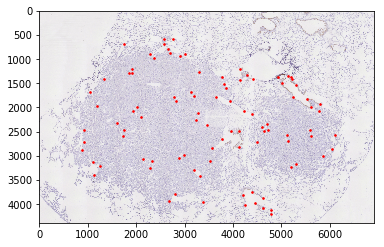

In [4]:
def show_landmarks(image, X,Y):
    plt.imshow(image)
    plt.scatter(X, Y, s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
source_image_1 = source_image_array[0]
source_image_landmark = source_image_landmarks[0]
current = pd.read_csv(source_image_landmark)
X = current['X']
Y = current['Y']

show_landmarks(io.imread(source_image_1),X,Y)
plt.show()

#### 训练
由于开始PIL读取图片导致图片过大，改了PIL文件Image.py中的MAX_IMAGE_PIXELS=none

计算 output size feature size
output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

In [5]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride)+1 
    return output
print(outputSize(512,3,2,0))
print(outputSize(255,2,1,0))

255
254


In [40]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class regNet_2D(nn.Module):
    def __init__(self):
        #使用super()方法调用基类的构造器，即nn.Module.__init__(self)
        super(regNet_2D,self).__init__()
        # The first layer 
        # Input channels = 3, output channels = 6 ,,5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1) 
        self.bn1=nn.BatchNorm2d(32)
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        
        
        self.reg_1 = torch.nn.Linear(128 * 16 * 16, 700)
        self.reg_1_1 = torch.nn.Linear(700, 70)
        # self.reg_1_2 = torch.nn.Linear(70, 70)
        
        
        self.deconv1=nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        self.bn_deconv1=nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn4=nn.BatchNorm2d(64)
        self.reg_2 = torch.nn.Linear(64 * 17 * 17, 700)
        self.reg_2_1 = torch.nn.Linear(700, 70)
        # self.reg_2_2 = torch.nn.Linear(70, 70)
        #64 input features, 10 output features for our 10 defined classes
        # self.fc2 = torch.nn.Linear(78, 78)
        
        ########### end of the first
        self.conv1_y = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1) 
        self.bn1_y=nn.BatchNorm2d(32)
        self.pool_1_y = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.conv2_y = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2_y = nn.BatchNorm2d(64)
        self.pool_2_y  = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3_y = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        
        self.reg_1_y = torch.nn.Linear(128 * 16 * 16, 70)
        self.reg_1_1_y = torch.nn.Linear(70, 70)
        
        self.deconv1_y = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        self.bn_deconv1_y = nn.BatchNorm2d(64)
        self.conv4_y = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn4_y=nn.BatchNorm2d(64)
        self.reg_2_y = torch.nn.Linear(64 * 17 * 17, 70)
        self.reg_2_1_y = torch.nn.Linear(70, 70)
        
        
    def forward(self,x,y):
        #Size changes from (3, height, weight) to (6, height, weight)
        x = F.relu(self.bn1(self.conv1(x)))
        #Size changes from (6, height, weight) to (6, height/2, weight/2)
        x = self.pool_1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool_2(x)
        x = F.relu(self.conv3(x))
        #Reshape data to input to the input layer of the neural net
        #Size changes from (6, height/2, weight/2) to (1, 6*height/2*weight/2)
        #Recall that the -1 infers this dimension from the other given dimension
        x_1 = x.view(-1, 128 * 16 * 16)
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 78)
        x_1 = self.reg_1(x_1)
        x_1 = self.reg_1_1(x_1)
        
        x = F.relu(self.bn_deconv1(self.deconv1(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x_2 = x.view(-1, 64 * 17 * 17)
        x_2 = self.reg_2(x_2)
        x_2 = self.reg_2_1(x_2)
        #### end of the first image
        
        ### the first guess using the samiliar network
        y = F.relu(self.bn1(self.conv1(y)))
        y = self.pool_1(y)
        y = F.relu(self.bn2(self.conv2(y)))
        y = self.pool_2(y)
        y = F.relu(self.conv3(y))
        
        y_1 = y.view(-1, 128 * 16 * 16)
        y_1 = self.reg_1(y_1)
        y_1 = self.reg_1_1(y_1)
        
        y = F.relu(self.bn_deconv1(self.deconv1(y)))
        y = F.relu(self.bn4(self.conv4(y)))
        y_2 = y.view(-1, 64 * 17 * 17)
        y_2 = self.reg_2(y_2)
        y_2 = self.reg_2_1(y_2)
        
        
        # x = F.relu(self.fc2(x))
        return x_1,x_2,y_1,y_2
        

In [ ]:
# transform_1 = transforms.Compose([transforms.Resize([512,512]),transforms.ToTensor()""",transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))"""]) 

transform_1 = transforms.Compose([transforms.Resize([512,512]),
                                  transforms.ToTensor()])


reg_net=regNet_2D()

from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(reg_net.parameters(), lr=1e-4)
loss = nn.MSELoss()# MSELoss可换为
for epoch in range(1000):
    for i, data in enumerate(loader, 0):
        inputs = data
        # source_image = plt.imread(inputs[0])
        
        optimizer.zero_grad()
        source_image = Image.open(inputs[0]).convert('RGB')
        # image = transform_1(source_image).unsqueeze(0)
        # width, height = source_image.size
        source_image1 = transform_1(source_image)
        # image_tensor = source_image1.to(device, torch.float)
        # source_image1 = torch.from_numpy(source_image).float()
        # source_image1 = source_image1.type(torch.FloatTensor)
        image_tensor= source_image1.unsqueeze(0)
        
        image_tensor = Variable(image_tensor)
        
        
        
        target_image = Image.open(target_image_array[i]).convert('RGB')
        # image = transform_1(target_image).unsqueeze(0)
        target_image1 = transform_1(target_image)
        target_image_tensor= target_image1.unsqueeze(0)
        target_image_tensor = Variable(target_image_tensor)
        
        optimizer.zero_grad()
        
        
        
        x_1,x_2,y_1,y_2 = reg_net(image_tensor,target_image_tensor)
        # plt.imshow(image)
        # plt.imshow(target_image)
        source_image_landmark = source_image_landmarks[i]
        current = pd.read_csv(source_image_landmark)
        X = current['X']
        Y = current['Y']
        # X = X.transpose()
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        loss_1 = loss(x_1, X)
        loss_2 = loss(x_2, Y)
        
        ######
        target_image_landmark = target_image_landmarks[i]
        current = pd.read_csv(target_image_landmark)
        X = current['X']
        Y = current['Y']
        
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        
        loss_3 = loss(y_1, X)
        loss_4 = loss(y_2, Y)
        
        
        loss_all = loss_1+loss_2+loss_3+loss_4
        loss_all.backward()
        
        optimizer.step()
        print("The loss is ",loss_all)
        
    
print(x_1)


The loss is  tensor(50787896., grad_fn=<AddBackward0>)
The loss is  tensor(51339972., grad_fn=<AddBackward0>)
The loss is  tensor(50990900., grad_fn=<AddBackward0>)
The loss is  tensor(50078088., grad_fn=<AddBackward0>)
The loss is  tensor(48119200., grad_fn=<AddBackward0>)
The loss is  tensor(47758352., grad_fn=<AddBackward0>)
The loss is  tensor(46838344., grad_fn=<AddBackward0>)
The loss is  tensor(48244520., grad_fn=<AddBackward0>)
The loss is  tensor(47296096., grad_fn=<AddBackward0>)
The loss is  tensor(46909072., grad_fn=<AddBackward0>)
The loss is  tensor(84083000., grad_fn=<AddBackward0>)
The loss is  tensor(79631896., grad_fn=<AddBackward0>)
The loss is  tensor(77762736., grad_fn=<AddBackward0>)
The loss is  tensor(84000352., grad_fn=<AddBackward0>)
The loss is  tensor(74682072., grad_fn=<AddBackward0>)
The loss is  tensor(72756144., grad_fn=<AddBackward0>)
The loss is  tensor(79034480., grad_fn=<AddBackward0>)
The loss is  tensor(68107768., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(8121378.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8718249., grad_fn=<AddBackward0>)
The loss is  tensor(6742435., grad_fn=<AddBackward0>)
The loss is  tensor(6609720., grad_fn=<AddBackward0>)
The loss is  tensor(6098130., grad_fn=<AddBackward0>)
The loss is  tensor(6371500., grad_fn=<AddBackward0>)
The loss is  tensor(6151122., grad_fn=<AddBackward0>)
The loss is  tensor(6214158., grad_fn=<AddBackward0>)
The loss is  tensor(10624502., grad_fn=<AddBackward0>)
The loss is  tensor(10357350., grad_fn=<AddBackward0>)
The loss is  tensor(10949023., grad_fn=<AddBackward0>)
The loss is  tensor(9739949., grad_fn=<AddBackward0>)
The loss is  tensor(9653371., grad_fn=<AddBackward0>)
The loss is  tensor(10233045., grad_fn=<AddBackward0>)
The loss is  tensor(9095182., grad_fn=<AddBackward0>)
The loss is  tensor(9999548., grad_fn=<AddBackward0>)
The loss is  tensor(8904117., grad_fn=<AddBackward0>)
The loss is  tensor(9249032., grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(35739536., grad_fn=<AddBackward0>)
The loss is  tensor(34360760., grad_fn=<AddBackward0>)
The loss is  tensor(30865872., grad_fn=<AddBackward0>)
The loss is  tensor(32142794., grad_fn=<AddBackward0>)
The loss is  tensor(22063108., grad_fn=<AddBackward0>)
The loss is  tensor(20065732., grad_fn=<AddBackward0>)
The loss is  tensor(18327748., grad_fn=<AddBackward0>)
The loss is  tensor(19687340., grad_fn=<AddBackward0>)
The loss is  tensor(17982146., grad_fn=<AddBackward0>)
The loss is  tensor(16723517., grad_fn=<AddBackward0>)
The loss is  tensor(14780805., grad_fn=<AddBackward0>)
The loss is  tensor(18657300., grad_fn=<AddBackward0>)
The loss is  tensor(18249102., grad_fn=<AddBackward0>)
The loss is  tensor(15719616., grad_fn=<AddBackward0>)
The loss is  tensor(11648826., grad_fn=<AddBackward0>)
The loss is  tensor(11173045., grad_fn=<AddBackward0>)
The loss is  tensor(7271904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8285678., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(14691650., grad_fn=<AddBackward0>)
The loss is  tensor(16266552., grad_fn=<AddBackward0>)
The loss is  tensor(13967234., grad_fn=<AddBackward0>)
The loss is  tensor(13702075., grad_fn=<AddBackward0>)
The loss is  tensor(13918006., grad_fn=<AddBackward0>)
The loss is  tensor(16658642., grad_fn=<AddBackward0>)
The loss is  tensor(19052428., grad_fn=<AddBackward0>)
The loss is  tensor(15936460., grad_fn=<AddBackward0>)
The loss is  tensor(16480532., grad_fn=<AddBackward0>)
The loss is  tensor(17869382., grad_fn=<AddBackward0>)
The loss is  tensor(16758669., grad_fn=<AddBackward0>)
The loss is  tensor(17193564., grad_fn=<AddBackward0>)
The loss is  tensor(15184316., grad_fn=<AddBackward0>)
The loss is  tensor(15597099., grad_fn=<AddBackward0>)
The loss is  tensor(14177144., grad_fn=<AddBackward0>)
The loss is  tensor(20093954., grad_fn=<AddBackward0>)
The loss is  tensor(20055792., grad_fn=<AddBackward0>)
The loss is  tensor(14891666., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(3236768.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2695151.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2546694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2227146.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2531905.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1884020.3750, grad_fn=<AddBackward0>)
The loss is  tensor(1806581.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1659925.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1488544.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1857657.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1627624.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1766503.3750, grad_fn=<AddBackward0>)
The loss is  tensor(1527794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1555882.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1525435.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8075229., grad_fn=<AddBackward0>)
The loss is  tensor(10664319., grad_fn=<AddBackward0>)
The loss is  tensor(9

The loss is  tensor(17877748., grad_fn=<AddBackward0>)
The loss is  tensor(17575574., grad_fn=<AddBackward0>)
The loss is  tensor(13372454., grad_fn=<AddBackward0>)
The loss is  tensor(13257251., grad_fn=<AddBackward0>)
The loss is  tensor(8424584., grad_fn=<AddBackward0>)
The loss is  tensor(12373088., grad_fn=<AddBackward0>)
The loss is  tensor(10822528., grad_fn=<AddBackward0>)
The loss is  tensor(10851270., grad_fn=<AddBackward0>)
The loss is  tensor(6962041., grad_fn=<AddBackward0>)
The loss is  tensor(10493983., grad_fn=<AddBackward0>)
The loss is  tensor(8054030., grad_fn=<AddBackward0>)
The loss is  tensor(5097941., grad_fn=<AddBackward0>)
The loss is  tensor(4415304.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7982195.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4545191., grad_fn=<AddBackward0>)
The loss is  tensor(3895874.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3897751.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4075338.5000, grad_fn=<AddBackward0>)


The loss is  tensor(14689533., grad_fn=<AddBackward0>)
The loss is  tensor(14225091., grad_fn=<AddBackward0>)
The loss is  tensor(13572952., grad_fn=<AddBackward0>)
The loss is  tensor(13347708., grad_fn=<AddBackward0>)
The loss is  tensor(22047362., grad_fn=<AddBackward0>)
The loss is  tensor(14513242., grad_fn=<AddBackward0>)
The loss is  tensor(23641978., grad_fn=<AddBackward0>)
The loss is  tensor(15068540., grad_fn=<AddBackward0>)
The loss is  tensor(12190155., grad_fn=<AddBackward0>)
The loss is  tensor(12398266., grad_fn=<AddBackward0>)
The loss is  tensor(16547100., grad_fn=<AddBackward0>)
The loss is  tensor(10099466., grad_fn=<AddBackward0>)
The loss is  tensor(13171034., grad_fn=<AddBackward0>)
The loss is  tensor(7158600., grad_fn=<AddBackward0>)
The loss is  tensor(6528945., grad_fn=<AddBackward0>)
The loss is  tensor(5548307.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4995195.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8053744., grad_fn=<AddBackward0>)
The los

The loss is  tensor(2030734., grad_fn=<AddBackward0>)
The loss is  tensor(1958517.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1211593.8750, grad_fn=<AddBackward0>)
The loss is  tensor(7970953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11055866., grad_fn=<AddBackward0>)
The loss is  tensor(9654432., grad_fn=<AddBackward0>)
The loss is  tensor(9620663., grad_fn=<AddBackward0>)
The loss is  tensor(6423291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11048767., grad_fn=<AddBackward0>)
The loss is  tensor(9511000., grad_fn=<AddBackward0>)
The loss is  tensor(6803604., grad_fn=<AddBackward0>)
The loss is  tensor(9830920., grad_fn=<AddBackward0>)
The loss is  tensor(8170477.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24572968., grad_fn=<AddBackward0>)
The loss is  tensor(25911242., grad_fn=<AddBackward0>)
The loss is  tensor(25258568., grad_fn=<AddBackward0>)
The loss is  tensor(22593892., grad_fn=<AddBackward0>)
The loss is  tensor(23335024., grad_fn=<AddBackward0>)
T

The loss is  tensor(3461977.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5866351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4833640.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5750297., grad_fn=<AddBackward0>)
The loss is  tensor(4128347.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6214130., grad_fn=<AddBackward0>)
The loss is  tensor(5944336.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3848378., grad_fn=<AddBackward0>)
The loss is  tensor(3707254., grad_fn=<AddBackward0>)
The loss is  tensor(3855381.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8492511., grad_fn=<AddBackward0>)
The loss is  tensor(20625574., grad_fn=<AddBackward0>)
The loss is  tensor(13137932., grad_fn=<AddBackward0>)
The loss is  tensor(13233620., grad_fn=<AddBackward0>)
The loss is  tensor(14801256., grad_fn=<AddBackward0>)
The loss is  tensor(11979630., grad_fn=<AddBackward0>)
The loss is  tensor(13257550., grad_fn=<AddBackward0>)
The loss is  tensor(14026256., grad_fn=<AddBackward0

The loss is  tensor(18917588., grad_fn=<AddBackward0>)
The loss is  tensor(9127871., grad_fn=<AddBackward0>)
The loss is  tensor(5082841., grad_fn=<AddBackward0>)
The loss is  tensor(13281086., grad_fn=<AddBackward0>)
The loss is  tensor(6097078., grad_fn=<AddBackward0>)
The loss is  tensor(6099144.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7360415., grad_fn=<AddBackward0>)
The loss is  tensor(3909041.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6421131., grad_fn=<AddBackward0>)
The loss is  tensor(3454060.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3688731., grad_fn=<AddBackward0>)
The loss is  tensor(3410381., grad_fn=<AddBackward0>)
The loss is  tensor(6269377., grad_fn=<AddBackward0>)
The loss is  tensor(6768555.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3216358., grad_fn=<AddBackward0>)
The loss is  tensor(3107979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3224376., grad_fn=<AddBackward0>)
The loss is  tensor(5043509., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(11413715., grad_fn=<AddBackward0>)
The loss is  tensor(15296272., grad_fn=<AddBackward0>)
The loss is  tensor(27630890., grad_fn=<AddBackward0>)
The loss is  tensor(24009430., grad_fn=<AddBackward0>)
The loss is  tensor(20543222., grad_fn=<AddBackward0>)
The loss is  tensor(17732908., grad_fn=<AddBackward0>)
The loss is  tensor(24095120., grad_fn=<AddBackward0>)
The loss is  tensor(27883608., grad_fn=<AddBackward0>)
The loss is  tensor(22528952., grad_fn=<AddBackward0>)
The loss is  tensor(17373730., grad_fn=<AddBackward0>)
The loss is  tensor(20336332., grad_fn=<AddBackward0>)
The loss is  tensor(20049684., grad_fn=<AddBackward0>)
The loss is  tensor(11427624., grad_fn=<AddBackward0>)
The loss is  tensor(17780506., grad_fn=<AddBackward0>)
The loss is  tensor(19919046., grad_fn=<AddBackward0>)
The loss is  tensor(18821880., grad_fn=<AddBackward0>)
The loss is  tensor(11581837., grad_fn=<AddBackward0>)
The loss is  tensor(15045559., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(16185810., grad_fn=<AddBackward0>)
The loss is  tensor(12907020., grad_fn=<AddBackward0>)
The loss is  tensor(18073138., grad_fn=<AddBackward0>)
The loss is  tensor(11699621., grad_fn=<AddBackward0>)
The loss is  tensor(11889238., grad_fn=<AddBackward0>)
The loss is  tensor(12608188., grad_fn=<AddBackward0>)
The loss is  tensor(11157514., grad_fn=<AddBackward0>)
The loss is  tensor(16192144., grad_fn=<AddBackward0>)
The loss is  tensor(12254843., grad_fn=<AddBackward0>)
The loss is  tensor(14218964., grad_fn=<AddBackward0>)
The loss is  tensor(24686184., grad_fn=<AddBackward0>)
The loss is  tensor(13329308., grad_fn=<AddBackward0>)
The loss is  tensor(12764730., grad_fn=<AddBackward0>)
The loss is  tensor(15682807., grad_fn=<AddBackward0>)
The loss is  tensor(13389070., grad_fn=<AddBackward0>)
The loss is  tensor(14128498., grad_fn=<AddBackward0>)
The loss is  tensor(13023617., grad_fn=<AddBackward0>)
The loss is  tensor(13954911., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(3812217., grad_fn=<AddBackward0>)
The loss is  tensor(3675124., grad_fn=<AddBackward0>)
The loss is  tensor(3827293.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3948943.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3988865., grad_fn=<AddBackward0>)
The loss is  tensor(3318210.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5745969.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2055524.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2649740.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2716919.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1666973.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3171991.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2027722.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3652681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2860940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2274022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1479363.5000, grad_fn=<AddBackward0>)
The loss is  tensor(206338

The loss is  tensor(18804408., grad_fn=<AddBackward0>)
The loss is  tensor(18541656., grad_fn=<AddBackward0>)
The loss is  tensor(17537738., grad_fn=<AddBackward0>)
The loss is  tensor(17666132., grad_fn=<AddBackward0>)
The loss is  tensor(23686892., grad_fn=<AddBackward0>)
The loss is  tensor(16752072., grad_fn=<AddBackward0>)
The loss is  tensor(15329176., grad_fn=<AddBackward0>)
The loss is  tensor(7540231., grad_fn=<AddBackward0>)
The loss is  tensor(12554435., grad_fn=<AddBackward0>)
The loss is  tensor(12878003., grad_fn=<AddBackward0>)
The loss is  tensor(12482317., grad_fn=<AddBackward0>)
The loss is  tensor(11367016., grad_fn=<AddBackward0>)
The loss is  tensor(16949942., grad_fn=<AddBackward0>)
The loss is  tensor(13930775., grad_fn=<AddBackward0>)
The loss is  tensor(2679841.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3492155., grad_fn=<AddBackward0>)
The loss is  tensor(13458492., grad_fn=<AddBackward0>)
The loss is  tensor(5327408., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(12903978., grad_fn=<AddBackward0>)
The loss is  tensor(17845460., grad_fn=<AddBackward0>)
The loss is  tensor(13194082., grad_fn=<AddBackward0>)
The loss is  tensor(13391252., grad_fn=<AddBackward0>)
The loss is  tensor(18620752., grad_fn=<AddBackward0>)
The loss is  tensor(17309734., grad_fn=<AddBackward0>)
The loss is  tensor(17294778., grad_fn=<AddBackward0>)
The loss is  tensor(10124381., grad_fn=<AddBackward0>)
The loss is  tensor(9627295., grad_fn=<AddBackward0>)
The loss is  tensor(16134205., grad_fn=<AddBackward0>)
The loss is  tensor(13448804., grad_fn=<AddBackward0>)
The loss is  tensor(15815341., grad_fn=<AddBackward0>)
The loss is  tensor(13431515., grad_fn=<AddBackward0>)
The loss is  tensor(11972100., grad_fn=<AddBackward0>)
The loss is  tensor(19928772., grad_fn=<AddBackward0>)
The loss is  tensor(6281698., grad_fn=<AddBackward0>)
The loss is  tensor(14464225., grad_fn=<AddBackward0>)
The loss is  tensor(9617995., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(2874025.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4384197.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2625954.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5418568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1849160.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3037694.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3671522., grad_fn=<AddBackward0>)
The loss is  tensor(6382591.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8931527., grad_fn=<AddBackward0>)
The loss is  tensor(9434661., grad_fn=<AddBackward0>)
The loss is  tensor(7368057.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9969304., grad_fn=<AddBackward0>)
The loss is  tensor(8661432., grad_fn=<AddBackward0>)
The loss is  tensor(11265355., grad_fn=<AddBackward0>)
The loss is  tensor(7986883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5693629., grad_fn=<AddBackward0>)
The loss is  tensor(11374640., grad_fn=<AddBackward0>)
The loss is  tensor(20879564., grad_fn=<AddB

The loss is  tensor(9919919., grad_fn=<AddBackward0>)
The loss is  tensor(11480727., grad_fn=<AddBackward0>)
The loss is  tensor(8716725., grad_fn=<AddBackward0>)
The loss is  tensor(10008614., grad_fn=<AddBackward0>)
The loss is  tensor(3058736., grad_fn=<AddBackward0>)
The loss is  tensor(4165951.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6260316., grad_fn=<AddBackward0>)
The loss is  tensor(4414724.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4434718., grad_fn=<AddBackward0>)
The loss is  tensor(5313463., grad_fn=<AddBackward0>)
The loss is  tensor(4080302., grad_fn=<AddBackward0>)
The loss is  tensor(3613136.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4601579., grad_fn=<AddBackward0>)
The loss is  tensor(5947580., grad_fn=<AddBackward0>)
The loss is  tensor(5230626.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20100918., grad_fn=<AddBackward0>)
The loss is  tensor(20111208., grad_fn=<AddBackward0>)
The loss is  tensor(12036945., grad_fn=<AddBackward0>)
The los

The loss is  tensor(9739137., grad_fn=<AddBackward0>)
The loss is  tensor(28400832., grad_fn=<AddBackward0>)
The loss is  tensor(29224708., grad_fn=<AddBackward0>)
The loss is  tensor(13225358., grad_fn=<AddBackward0>)
The loss is  tensor(12313662., grad_fn=<AddBackward0>)
The loss is  tensor(6234639.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5665072., grad_fn=<AddBackward0>)
The loss is  tensor(15064578., grad_fn=<AddBackward0>)
The loss is  tensor(4378421.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6695351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5795694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6162631.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2772808.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4553739., grad_fn=<AddBackward0>)
The loss is  tensor(3857855.7500, grad_fn=<AddBackward0>)
The loss is  tensor(13063776., grad_fn=<AddBackward0>)
The loss is  tensor(4974730., grad_fn=<AddBackward0>)
The loss is  tensor(4245562.5000, grad_fn=<AddBa

The loss is  tensor(4941742., grad_fn=<AddBackward0>)
The loss is  tensor(8163286.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7117929.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7380058., grad_fn=<AddBackward0>)
The loss is  tensor(5306482.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20363870., grad_fn=<AddBackward0>)
The loss is  tensor(21954832., grad_fn=<AddBackward0>)
The loss is  tensor(19694722., grad_fn=<AddBackward0>)
The loss is  tensor(16792268., grad_fn=<AddBackward0>)
The loss is  tensor(21300390., grad_fn=<AddBackward0>)
The loss is  tensor(13993031., grad_fn=<AddBackward0>)
The loss is  tensor(12660910., grad_fn=<AddBackward0>)
The loss is  tensor(22801164., grad_fn=<AddBackward0>)
The loss is  tensor(14460521., grad_fn=<AddBackward0>)
The loss is  tensor(10315084., grad_fn=<AddBackward0>)
The loss is  tensor(18535598., grad_fn=<AddBackward0>)
The loss is  tensor(7523837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12102314., grad_fn=<AddBackward0>)


The loss is  tensor(7283488., grad_fn=<AddBackward0>)
The loss is  tensor(3867421., grad_fn=<AddBackward0>)
The loss is  tensor(3566738.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17036978., grad_fn=<AddBackward0>)
The loss is  tensor(14997295., grad_fn=<AddBackward0>)
The loss is  tensor(12015538., grad_fn=<AddBackward0>)
The loss is  tensor(19303318., grad_fn=<AddBackward0>)
The loss is  tensor(12143270., grad_fn=<AddBackward0>)
The loss is  tensor(17644054., grad_fn=<AddBackward0>)
The loss is  tensor(15558013., grad_fn=<AddBackward0>)
The loss is  tensor(10526007., grad_fn=<AddBackward0>)
The loss is  tensor(15804594., grad_fn=<AddBackward0>)
The loss is  tensor(12118066., grad_fn=<AddBackward0>)
The loss is  tensor(13813892., grad_fn=<AddBackward0>)
The loss is  tensor(16141862., grad_fn=<AddBackward0>)
The loss is  tensor(11641194., grad_fn=<AddBackward0>)
The loss is  tensor(11770056., grad_fn=<AddBackward0>)
The loss is  tensor(16432447., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(13111200., grad_fn=<AddBackward0>)
The loss is  tensor(9531802., grad_fn=<AddBackward0>)
The loss is  tensor(6614734., grad_fn=<AddBackward0>)
The loss is  tensor(6055038.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5208200.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4619829., grad_fn=<AddBackward0>)
The loss is  tensor(4215980.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11131295., grad_fn=<AddBackward0>)
The loss is  tensor(3885119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8123295., grad_fn=<AddBackward0>)
The loss is  tensor(5979889., grad_fn=<AddBackward0>)
The loss is  tensor(5604707., grad_fn=<AddBackward0>)
The loss is  tensor(3023321.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4603965., grad_fn=<AddBackward0>)
The loss is  tensor(1954909., grad_fn=<AddBackward0>)
The loss is  tensor(2851133.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1920933., grad_fn=<AddBackward0>)
The loss is  tensor(1757530.6250, grad_fn=<AddBackward0>

The loss is  tensor(16142548., grad_fn=<AddBackward0>)
The loss is  tensor(12125903., grad_fn=<AddBackward0>)
The loss is  tensor(29500966., grad_fn=<AddBackward0>)
The loss is  tensor(28215490., grad_fn=<AddBackward0>)
The loss is  tensor(18707962., grad_fn=<AddBackward0>)
The loss is  tensor(14979119., grad_fn=<AddBackward0>)
The loss is  tensor(17774256., grad_fn=<AddBackward0>)
The loss is  tensor(20801814., grad_fn=<AddBackward0>)
The loss is  tensor(9395339., grad_fn=<AddBackward0>)
The loss is  tensor(10579162., grad_fn=<AddBackward0>)
The loss is  tensor(12817475., grad_fn=<AddBackward0>)
The loss is  tensor(7421540.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9126445., grad_fn=<AddBackward0>)
The loss is  tensor(14706156., grad_fn=<AddBackward0>)
The loss is  tensor(10471457., grad_fn=<AddBackward0>)
The loss is  tensor(12306311., grad_fn=<AddBackward0>)
The loss is  tensor(15019748., grad_fn=<AddBackward0>)
The loss is  tensor(1808292.2500, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(13107064., grad_fn=<AddBackward0>)
The loss is  tensor(18378922., grad_fn=<AddBackward0>)
The loss is  tensor(11682897., grad_fn=<AddBackward0>)
The loss is  tensor(12168749., grad_fn=<AddBackward0>)
The loss is  tensor(11398938., grad_fn=<AddBackward0>)
The loss is  tensor(18643980., grad_fn=<AddBackward0>)
The loss is  tensor(12484722., grad_fn=<AddBackward0>)
The loss is  tensor(20253114., grad_fn=<AddBackward0>)
The loss is  tensor(12558929., grad_fn=<AddBackward0>)
The loss is  tensor(14902223., grad_fn=<AddBackward0>)
The loss is  tensor(20665814., grad_fn=<AddBackward0>)
The loss is  tensor(31018352., grad_fn=<AddBackward0>)
The loss is  tensor(18195934., grad_fn=<AddBackward0>)
The loss is  tensor(31531788., grad_fn=<AddBackward0>)
The loss is  tensor(17404078., grad_fn=<AddBackward0>)
The loss is  tensor(16861042., grad_fn=<AddBackward0>)
The loss is  tensor(20353322., grad_fn=<AddBackward0>)
The loss is  tensor(9586160., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(2733276.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6037241., grad_fn=<AddBackward0>)
The loss is  tensor(1886396.6250, grad_fn=<AddBackward0>)
The loss is  tensor(7745518.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2440270.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2777211.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1288605.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2446714.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4656243.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5667408., grad_fn=<AddBackward0>)
The loss is  tensor(7599855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3032996.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8837308., grad_fn=<AddBackward0>)
The loss is  tensor(8579443., grad_fn=<AddBackward0>)
The loss is  tensor(3597525.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3040237., grad_fn=<AddBackward0>)
The loss is  tensor(6723618.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7045827.5000, 

The loss is  tensor(18025614., grad_fn=<AddBackward0>)
The loss is  tensor(24582472., grad_fn=<AddBackward0>)
The loss is  tensor(4306013., grad_fn=<AddBackward0>)
The loss is  tensor(15555317., grad_fn=<AddBackward0>)
The loss is  tensor(3386460.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2160524., grad_fn=<AddBackward0>)
The loss is  tensor(10840104., grad_fn=<AddBackward0>)
The loss is  tensor(4334626.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9143268., grad_fn=<AddBackward0>)
The loss is  tensor(4130301.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4854351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5973224.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3667484.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4204545.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4090175.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3640817.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4950086., grad_fn=<AddBackward0>)
The loss is  tensor(16218198., grad_fn=<Ad

The loss is  tensor(24607056., grad_fn=<AddBackward0>)
The loss is  tensor(16348052., grad_fn=<AddBackward0>)
The loss is  tensor(26035580., grad_fn=<AddBackward0>)
The loss is  tensor(18204726., grad_fn=<AddBackward0>)
The loss is  tensor(19163954., grad_fn=<AddBackward0>)
The loss is  tensor(13217375., grad_fn=<AddBackward0>)
The loss is  tensor(20781404., grad_fn=<AddBackward0>)
The loss is  tensor(4441405., grad_fn=<AddBackward0>)
The loss is  tensor(6910531.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12142582., grad_fn=<AddBackward0>)
The loss is  tensor(7613893.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5085182., grad_fn=<AddBackward0>)
The loss is  tensor(8358609., grad_fn=<AddBackward0>)
The loss is  tensor(3476236.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6014161., grad_fn=<AddBackward0>)
The loss is  tensor(4935357.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6130078., grad_fn=<AddBackward0>)
The loss is  tensor(4721736.5000, grad_fn=<AddBackward0>)


The loss is  tensor(3872319.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10130672., grad_fn=<AddBackward0>)
The loss is  tensor(7846142.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9047925., grad_fn=<AddBackward0>)
The loss is  tensor(8024041.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3527261.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6040898.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18224804., grad_fn=<AddBackward0>)
The loss is  tensor(20998024., grad_fn=<AddBackward0>)
The loss is  tensor(17227258., grad_fn=<AddBackward0>)
The loss is  tensor(15544426., grad_fn=<AddBackward0>)
The loss is  tensor(20791466., grad_fn=<AddBackward0>)
The loss is  tensor(19205072., grad_fn=<AddBackward0>)
The loss is  tensor(22206212., grad_fn=<AddBackward0>)
The loss is  tensor(17657118., grad_fn=<AddBackward0>)
The loss is  tensor(15960579., grad_fn=<AddBackward0>)
The loss is  tensor(10152913., grad_fn=<AddBackward0>)
The loss is  tensor(19658200., grad_fn=<AddBackward

The loss is  tensor(3721918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3673211.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3563789., grad_fn=<AddBackward0>)
The loss is  tensor(6679254., grad_fn=<AddBackward0>)
The loss is  tensor(6525948.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12808832., grad_fn=<AddBackward0>)
The loss is  tensor(11895262., grad_fn=<AddBackward0>)
The loss is  tensor(11894218., grad_fn=<AddBackward0>)
The loss is  tensor(18911218., grad_fn=<AddBackward0>)
The loss is  tensor(14740256., grad_fn=<AddBackward0>)
The loss is  tensor(10275378., grad_fn=<AddBackward0>)
The loss is  tensor(14031966., grad_fn=<AddBackward0>)
The loss is  tensor(17086652., grad_fn=<AddBackward0>)
The loss is  tensor(18243470., grad_fn=<AddBackward0>)
The loss is  tensor(10763880., grad_fn=<AddBackward0>)
The loss is  tensor(12360170., grad_fn=<AddBackward0>)
The loss is  tensor(16146338., grad_fn=<AddBackward0>)
The loss is  tensor(14579176., grad_fn=<AddBackward0>)
The

The loss is  tensor(8742322., grad_fn=<AddBackward0>)
The loss is  tensor(9310540., grad_fn=<AddBackward0>)
The loss is  tensor(13334343., grad_fn=<AddBackward0>)
The loss is  tensor(5658562.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14863234., grad_fn=<AddBackward0>)
The loss is  tensor(15873250., grad_fn=<AddBackward0>)
The loss is  tensor(14735847., grad_fn=<AddBackward0>)
The loss is  tensor(4420348.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3533344.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4155574., grad_fn=<AddBackward0>)
The loss is  tensor(4154542.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5868480., grad_fn=<AddBackward0>)
The loss is  tensor(9181205., grad_fn=<AddBackward0>)
The loss is  tensor(2866716.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2800584.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3188268.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8310590., grad_fn=<AddBackward0>)
The loss is  tensor(1980401., grad_fn=<AddBackward

The loss is  tensor(19188704., grad_fn=<AddBackward0>)
The loss is  tensor(21990926., grad_fn=<AddBackward0>)
The loss is  tensor(10301846., grad_fn=<AddBackward0>)
The loss is  tensor(16720117., grad_fn=<AddBackward0>)
The loss is  tensor(7992877., grad_fn=<AddBackward0>)
The loss is  tensor(16328536., grad_fn=<AddBackward0>)
The loss is  tensor(12050636., grad_fn=<AddBackward0>)
The loss is  tensor(14048490., grad_fn=<AddBackward0>)
The loss is  tensor(19970526., grad_fn=<AddBackward0>)
The loss is  tensor(9858497., grad_fn=<AddBackward0>)
The loss is  tensor(18944280., grad_fn=<AddBackward0>)
The loss is  tensor(15035414., grad_fn=<AddBackward0>)
The loss is  tensor(7835642., grad_fn=<AddBackward0>)
The loss is  tensor(14512880., grad_fn=<AddBackward0>)
The loss is  tensor(5574826., grad_fn=<AddBackward0>)
The loss is  tensor(13972679., grad_fn=<AddBackward0>)
The loss is  tensor(7087691.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6251393.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(11304020., grad_fn=<AddBackward0>)
The loss is  tensor(10162318., grad_fn=<AddBackward0>)
The loss is  tensor(14552298., grad_fn=<AddBackward0>)
The loss is  tensor(18154078., grad_fn=<AddBackward0>)
The loss is  tensor(19240394., grad_fn=<AddBackward0>)
The loss is  tensor(20233506., grad_fn=<AddBackward0>)
The loss is  tensor(16213827., grad_fn=<AddBackward0>)
The loss is  tensor(15563348., grad_fn=<AddBackward0>)
The loss is  tensor(13460186., grad_fn=<AddBackward0>)
The loss is  tensor(10690176., grad_fn=<AddBackward0>)
The loss is  tensor(12638238., grad_fn=<AddBackward0>)
The loss is  tensor(11759809., grad_fn=<AddBackward0>)
The loss is  tensor(16588943., grad_fn=<AddBackward0>)
The loss is  tensor(10035780., grad_fn=<AddBackward0>)
The loss is  tensor(17429768., grad_fn=<AddBackward0>)
The loss is  tensor(5117562., grad_fn=<AddBackward0>)
The loss is  tensor(8021808.5000, grad_fn=<AddBackward0>)
The loss is  tensor(32090968., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(4954685., grad_fn=<AddBackward0>)
The loss is  tensor(4715895., grad_fn=<AddBackward0>)
The loss is  tensor(3082615.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9985242., grad_fn=<AddBackward0>)
The loss is  tensor(4522524.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4587892.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4961997., grad_fn=<AddBackward0>)
The loss is  tensor(6063412., grad_fn=<AddBackward0>)
The loss is  tensor(3881909.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7232862., grad_fn=<AddBackward0>)
The loss is  tensor(2409426.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2011090.1250, grad_fn=<AddBackward0>)
The loss is  tensor(1551966.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3445143.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3164127.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6925149., grad_fn=<AddBackward0>)
The loss is  tensor(7636693., grad_fn=<AddBackward0>)
The loss is  tensor(2832101.7500, grad_fn=<Add

The loss is  tensor(5755873., grad_fn=<AddBackward0>)
The loss is  tensor(21314620., grad_fn=<AddBackward0>)
The loss is  tensor(13296825., grad_fn=<AddBackward0>)
The loss is  tensor(11365167., grad_fn=<AddBackward0>)
The loss is  tensor(6224928.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13884054., grad_fn=<AddBackward0>)
The loss is  tensor(11715712., grad_fn=<AddBackward0>)
The loss is  tensor(12686658., grad_fn=<AddBackward0>)
The loss is  tensor(8586982., grad_fn=<AddBackward0>)
The loss is  tensor(8578537., grad_fn=<AddBackward0>)
The loss is  tensor(6321568., grad_fn=<AddBackward0>)
The loss is  tensor(12226426., grad_fn=<AddBackward0>)
The loss is  tensor(6817617., grad_fn=<AddBackward0>)
The loss is  tensor(5461867., grad_fn=<AddBackward0>)
The loss is  tensor(5091357.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11153515., grad_fn=<AddBackward0>)
The loss is  tensor(3471882.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4366215., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(20005976., grad_fn=<AddBackward0>)
The loss is  tensor(13601606., grad_fn=<AddBackward0>)
The loss is  tensor(31693878., grad_fn=<AddBackward0>)
The loss is  tensor(16821930., grad_fn=<AddBackward0>)
The loss is  tensor(22150090., grad_fn=<AddBackward0>)
The loss is  tensor(20700952., grad_fn=<AddBackward0>)
The loss is  tensor(12681720., grad_fn=<AddBackward0>)
The loss is  tensor(19073686., grad_fn=<AddBackward0>)
The loss is  tensor(16325104., grad_fn=<AddBackward0>)
The loss is  tensor(15941635., grad_fn=<AddBackward0>)
The loss is  tensor(14165292., grad_fn=<AddBackward0>)
The loss is  tensor(14812715., grad_fn=<AddBackward0>)
The loss is  tensor(5079214.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9506921., grad_fn=<AddBackward0>)
The loss is  tensor(1878690.6250, grad_fn=<AddBackward0>)
The loss is  tensor(10416819., grad_fn=<AddBackward0>)
The loss is  tensor(9223363., grad_fn=<AddBackward0>)
The loss is  tensor(10996031., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(1451135., grad_fn=<AddBackward0>)
The loss is  tensor(2851075.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2799072.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2208086., grad_fn=<AddBackward0>)
The loss is  tensor(4148188.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6027329.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2639758.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8066618., grad_fn=<AddBackward0>)
The loss is  tensor(4023095., grad_fn=<AddBackward0>)
The loss is  tensor(11459208., grad_fn=<AddBackward0>)
The loss is  tensor(9434513., grad_fn=<AddBackward0>)
The loss is  tensor(8076604., grad_fn=<AddBackward0>)
The loss is  tensor(20063394., grad_fn=<AddBackward0>)
The loss is  tensor(16066545., grad_fn=<AddBackward0>)
The loss is  tensor(17296754., grad_fn=<AddBackward0>)
The loss is  tensor(21613368., grad_fn=<AddBackward0>)
The loss is  tensor(18615278., grad_fn=<AddBackward0>)
The loss is  tensor(17167484., grad_fn=<AddBackward0>)
T

The loss is  tensor(3804653.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6727438., grad_fn=<AddBackward0>)
The loss is  tensor(4431319., grad_fn=<AddBackward0>)
The loss is  tensor(4349864., grad_fn=<AddBackward0>)
The loss is  tensor(5684537.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5159777.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2725386., grad_fn=<AddBackward0>)
The loss is  tensor(4604327.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4918363., grad_fn=<AddBackward0>)
The loss is  tensor(5680777.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12401398., grad_fn=<AddBackward0>)
The loss is  tensor(14121940., grad_fn=<AddBackward0>)
The loss is  tensor(13442711., grad_fn=<AddBackward0>)
The loss is  tensor(12311201., grad_fn=<AddBackward0>)
The loss is  tensor(11233134., grad_fn=<AddBackward0>)
The loss is  tensor(15654862., grad_fn=<AddBackward0>)
The loss is  tensor(11013315., grad_fn=<AddBackward0>)
The loss is  tensor(8573014., grad_fn=<AddBackward0>)
T

The loss is  tensor(8392541., grad_fn=<AddBackward0>)
The loss is  tensor(5478094., grad_fn=<AddBackward0>)
The loss is  tensor(7954732., grad_fn=<AddBackward0>)
The loss is  tensor(9031254., grad_fn=<AddBackward0>)
The loss is  tensor(2943967.7500, grad_fn=<AddBackward0>)
The loss is  tensor(14320848., grad_fn=<AddBackward0>)
The loss is  tensor(8956706., grad_fn=<AddBackward0>)
The loss is  tensor(1809240.3750, grad_fn=<AddBackward0>)
The loss is  tensor(7341190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6875919.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4685596., grad_fn=<AddBackward0>)
The loss is  tensor(6426991., grad_fn=<AddBackward0>)
The loss is  tensor(5529356.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5285519., grad_fn=<AddBackward0>)
The loss is  tensor(4281229., grad_fn=<AddBackward0>)
The loss is  tensor(12990992., grad_fn=<AddBackward0>)
The loss is  tensor(10096455., grad_fn=<AddBackward0>)
The loss is  tensor(4330790.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(21920398., grad_fn=<AddBackward0>)
The loss is  tensor(19059408., grad_fn=<AddBackward0>)
The loss is  tensor(16058779., grad_fn=<AddBackward0>)
The loss is  tensor(17699848., grad_fn=<AddBackward0>)
The loss is  tensor(9657593., grad_fn=<AddBackward0>)
The loss is  tensor(12787586., grad_fn=<AddBackward0>)
The loss is  tensor(16956044., grad_fn=<AddBackward0>)
The loss is  tensor(7282164., grad_fn=<AddBackward0>)
The loss is  tensor(15980850., grad_fn=<AddBackward0>)
The loss is  tensor(19421108., grad_fn=<AddBackward0>)
The loss is  tensor(10238102., grad_fn=<AddBackward0>)
The loss is  tensor(9566238., grad_fn=<AddBackward0>)
The loss is  tensor(16265450., grad_fn=<AddBackward0>)
The loss is  tensor(14059726., grad_fn=<AddBackward0>)
The loss is  tensor(13863960., grad_fn=<AddBackward0>)
The loss is  tensor(19817760., grad_fn=<AddBackward0>)
The loss is  tensor(13709640., grad_fn=<AddBackward0>)
The loss is  tensor(6433988.5000, grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(12323707., grad_fn=<AddBackward0>)
The loss is  tensor(10977700., grad_fn=<AddBackward0>)
The loss is  tensor(21846610., grad_fn=<AddBackward0>)
The loss is  tensor(9525391., grad_fn=<AddBackward0>)
The loss is  tensor(9785500., grad_fn=<AddBackward0>)
The loss is  tensor(12623011., grad_fn=<AddBackward0>)
The loss is  tensor(11136867., grad_fn=<AddBackward0>)
The loss is  tensor(14583489., grad_fn=<AddBackward0>)
The loss is  tensor(12608443., grad_fn=<AddBackward0>)
The loss is  tensor(10833583., grad_fn=<AddBackward0>)
The loss is  tensor(9804566., grad_fn=<AddBackward0>)
The loss is  tensor(9202169., grad_fn=<AddBackward0>)
The loss is  tensor(13251175., grad_fn=<AddBackward0>)
The loss is  tensor(12620838., grad_fn=<AddBackward0>)
The loss is  tensor(11546054., grad_fn=<AddBackward0>)
The loss is  tensor(9727884., grad_fn=<AddBackward0>)
The loss is  tensor(17645118., grad_fn=<AddBackward0>)
The loss is  tensor(12071989., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(17908468., grad_fn=<AddBackward0>)
The loss is  tensor(14556719., grad_fn=<AddBackward0>)
The loss is  tensor(4680623., grad_fn=<AddBackward0>)
The loss is  tensor(2333354., grad_fn=<AddBackward0>)
The loss is  tensor(4441226., grad_fn=<AddBackward0>)
The loss is  tensor(4303656.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2934555.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4192983., grad_fn=<AddBackward0>)
The loss is  tensor(2428095., grad_fn=<AddBackward0>)
The loss is  tensor(1819036., grad_fn=<AddBackward0>)
The loss is  tensor(3226557.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3720273., grad_fn=<AddBackward0>)
The loss is  tensor(3427317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3549300., grad_fn=<AddBackward0>)
The loss is  tensor(3184268.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3402404.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2438898., grad_fn=<AddBackward0>)
The loss is  tensor(1718776.1250, grad_fn=<AddBackward0>

The loss is  tensor(7723715.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17621580., grad_fn=<AddBackward0>)
The loss is  tensor(18936638., grad_fn=<AddBackward0>)
The loss is  tensor(13260110., grad_fn=<AddBackward0>)
The loss is  tensor(14287107., grad_fn=<AddBackward0>)
The loss is  tensor(8487486., grad_fn=<AddBackward0>)
The loss is  tensor(12671785., grad_fn=<AddBackward0>)
The loss is  tensor(11345942., grad_fn=<AddBackward0>)
The loss is  tensor(10423120., grad_fn=<AddBackward0>)
The loss is  tensor(15392304., grad_fn=<AddBackward0>)
The loss is  tensor(4561022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8439675., grad_fn=<AddBackward0>)
The loss is  tensor(9667905., grad_fn=<AddBackward0>)
The loss is  tensor(9079503., grad_fn=<AddBackward0>)
The loss is  tensor(4659655., grad_fn=<AddBackward0>)
The loss is  tensor(5007968.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5391224., grad_fn=<AddBackward0>)
The loss is  tensor(6954392., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(10912023., grad_fn=<AddBackward0>)
The loss is  tensor(10460954., grad_fn=<AddBackward0>)
The loss is  tensor(16285275., grad_fn=<AddBackward0>)
The loss is  tensor(9842497., grad_fn=<AddBackward0>)
The loss is  tensor(18376588., grad_fn=<AddBackward0>)
The loss is  tensor(25881470., grad_fn=<AddBackward0>)
The loss is  tensor(15111327., grad_fn=<AddBackward0>)
The loss is  tensor(15869494., grad_fn=<AddBackward0>)
The loss is  tensor(16815476., grad_fn=<AddBackward0>)
The loss is  tensor(15709699., grad_fn=<AddBackward0>)
The loss is  tensor(13735290., grad_fn=<AddBackward0>)
The loss is  tensor(13921408., grad_fn=<AddBackward0>)
The loss is  tensor(9654250., grad_fn=<AddBackward0>)
The loss is  tensor(15641927., grad_fn=<AddBackward0>)
The loss is  tensor(3628305.7500, grad_fn=<AddBackward0>)
The loss is  tensor(18251460., grad_fn=<AddBackward0>)
The loss is  tensor(7518559.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11784843., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(1778675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1024247.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3675936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5554541.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6063429., grad_fn=<AddBackward0>)
The loss is  tensor(3809283.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5652012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3387015., grad_fn=<AddBackward0>)
The loss is  tensor(6520496.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5635953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8625103., grad_fn=<AddBackward0>)
The loss is  tensor(9007279., grad_fn=<AddBackward0>)
The loss is  tensor(7128111.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8557292., grad_fn=<AddBackward0>)
The loss is  tensor(20974750., grad_fn=<AddBackward0>)
The loss is  tensor(17713006., grad_fn=<AddBackward0>)
The loss is  tensor(8234025., grad_fn=<AddBackward0>)
The loss is  tensor(8112464.5000, grad_fn=<A

The loss is  tensor(8272750., grad_fn=<AddBackward0>)
The loss is  tensor(19244606., grad_fn=<AddBackward0>)
The loss is  tensor(4832120.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4875265., grad_fn=<AddBackward0>)
The loss is  tensor(5058816.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4249717., grad_fn=<AddBackward0>)
The loss is  tensor(5626399.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5571016.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5767909., grad_fn=<AddBackward0>)
The loss is  tensor(4580126.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6018121.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4231864., grad_fn=<AddBackward0>)
The loss is  tensor(18291420., grad_fn=<AddBackward0>)
The loss is  tensor(10762086., grad_fn=<AddBackward0>)
The loss is  tensor(12763784., grad_fn=<AddBackward0>)
The loss is  tensor(12787494., grad_fn=<AddBackward0>)
The loss is  tensor(9839021., grad_fn=<AddBackward0>)
The loss is  tensor(13384271., grad_fn=<AddBackward0>

The loss is  tensor(13820921., grad_fn=<AddBackward0>)
The loss is  tensor(26368198., grad_fn=<AddBackward0>)
The loss is  tensor(5963407.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8487704., grad_fn=<AddBackward0>)
The loss is  tensor(7786350., grad_fn=<AddBackward0>)
The loss is  tensor(8058718.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5500328., grad_fn=<AddBackward0>)
The loss is  tensor(5636837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6133459.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3972221.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5420675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5866435., grad_fn=<AddBackward0>)
The loss is  tensor(6290297., grad_fn=<AddBackward0>)
The loss is  tensor(7395575.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13597898., grad_fn=<AddBackward0>)
The loss is  tensor(5916850., grad_fn=<AddBackward0>)
The loss is  tensor(2992751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8474694., grad_fn=<AddBackw

The loss is  tensor(4075168.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9314492., grad_fn=<AddBackward0>)
The loss is  tensor(20120618., grad_fn=<AddBackward0>)
The loss is  tensor(9722859., grad_fn=<AddBackward0>)
The loss is  tensor(13452020., grad_fn=<AddBackward0>)
The loss is  tensor(9865055., grad_fn=<AddBackward0>)
The loss is  tensor(18850054., grad_fn=<AddBackward0>)
The loss is  tensor(12378392., grad_fn=<AddBackward0>)
The loss is  tensor(21722048., grad_fn=<AddBackward0>)
The loss is  tensor(18602546., grad_fn=<AddBackward0>)
The loss is  tensor(15493231., grad_fn=<AddBackward0>)
The loss is  tensor(18061048., grad_fn=<AddBackward0>)
The loss is  tensor(12531020., grad_fn=<AddBackward0>)
The loss is  tensor(24003610., grad_fn=<AddBackward0>)
The loss is  tensor(11915856., grad_fn=<AddBackward0>)
The loss is  tensor(11590860., grad_fn=<AddBackward0>)
The loss is  tensor(8561519., grad_fn=<AddBackward0>)
The loss is  tensor(6304871., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(14669717., grad_fn=<AddBackward0>)
The loss is  tensor(12419918., grad_fn=<AddBackward0>)
The loss is  tensor(11742462., grad_fn=<AddBackward0>)
The loss is  tensor(13820919., grad_fn=<AddBackward0>)
The loss is  tensor(11691437., grad_fn=<AddBackward0>)
The loss is  tensor(12068128., grad_fn=<AddBackward0>)
The loss is  tensor(11324063., grad_fn=<AddBackward0>)
The loss is  tensor(8294159., grad_fn=<AddBackward0>)
The loss is  tensor(16701829., grad_fn=<AddBackward0>)
The loss is  tensor(13783754., grad_fn=<AddBackward0>)
The loss is  tensor(12908478., grad_fn=<AddBackward0>)
The loss is  tensor(6323343.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15289478., grad_fn=<AddBackward0>)
The loss is  tensor(10802616., grad_fn=<AddBackward0>)
The loss is  tensor(10189090., grad_fn=<AddBackward0>)
The loss is  tensor(10534296., grad_fn=<AddBackward0>)
The loss is  tensor(10426098., grad_fn=<AddBackward0>)
The loss is  tensor(10762733., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(4247693.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3148886.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5364036.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11536424., grad_fn=<AddBackward0>)
The loss is  tensor(12082640., grad_fn=<AddBackward0>)
The loss is  tensor(6813757., grad_fn=<AddBackward0>)
The loss is  tensor(4440028.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4096548., grad_fn=<AddBackward0>)
The loss is  tensor(4005235.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4660973., grad_fn=<AddBackward0>)
The loss is  tensor(2952401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4467752.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1956749.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1767667., grad_fn=<AddBackward0>)
The loss is  tensor(5419559., grad_fn=<AddBackward0>)
The loss is  tensor(2611271.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3959992.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1711522.3750, grad_f

The loss is  tensor(20555304., grad_fn=<AddBackward0>)
The loss is  tensor(11163518., grad_fn=<AddBackward0>)
The loss is  tensor(15616385., grad_fn=<AddBackward0>)
The loss is  tensor(19741670., grad_fn=<AddBackward0>)
The loss is  tensor(8621213., grad_fn=<AddBackward0>)
The loss is  tensor(7094815., grad_fn=<AddBackward0>)
The loss is  tensor(13265781., grad_fn=<AddBackward0>)
The loss is  tensor(14129794., grad_fn=<AddBackward0>)
The loss is  tensor(12833767., grad_fn=<AddBackward0>)
The loss is  tensor(8195828.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10516201., grad_fn=<AddBackward0>)
The loss is  tensor(9509471., grad_fn=<AddBackward0>)
The loss is  tensor(15457951., grad_fn=<AddBackward0>)
The loss is  tensor(23291284., grad_fn=<AddBackward0>)
The loss is  tensor(12453367., grad_fn=<AddBackward0>)
The loss is  tensor(9564004., grad_fn=<AddBackward0>)
The loss is  tensor(4456917., grad_fn=<AddBackward0>)
The loss is  tensor(2914183.5000, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(11236574., grad_fn=<AddBackward0>)
The loss is  tensor(11377618., grad_fn=<AddBackward0>)
The loss is  tensor(15141794., grad_fn=<AddBackward0>)
The loss is  tensor(11089954., grad_fn=<AddBackward0>)
The loss is  tensor(12700676., grad_fn=<AddBackward0>)
The loss is  tensor(15634060., grad_fn=<AddBackward0>)
The loss is  tensor(10250530., grad_fn=<AddBackward0>)
The loss is  tensor(17270116., grad_fn=<AddBackward0>)
The loss is  tensor(12323336., grad_fn=<AddBackward0>)
The loss is  tensor(26909334., grad_fn=<AddBackward0>)
The loss is  tensor(14377835., grad_fn=<AddBackward0>)
The loss is  tensor(15170895., grad_fn=<AddBackward0>)
The loss is  tensor(17792566., grad_fn=<AddBackward0>)
The loss is  tensor(14271951., grad_fn=<AddBackward0>)
The loss is  tensor(18394268., grad_fn=<AddBackward0>)
The loss is  tensor(11649776., grad_fn=<AddBackward0>)
The loss is  tensor(10829316., grad_fn=<AddBackward0>)
The loss is  tensor(11741679., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(5306792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2985372., grad_fn=<AddBackward0>)
The loss is  tensor(11424220., grad_fn=<AddBackward0>)
The loss is  tensor(8904772., grad_fn=<AddBackward0>)
The loss is  tensor(2771405., grad_fn=<AddBackward0>)
The loss is  tensor(6808397., grad_fn=<AddBackward0>)
The loss is  tensor(6728103.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1278387.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2280935., grad_fn=<AddBackward0>)
The loss is  tensor(4240092., grad_fn=<AddBackward0>)
The loss is  tensor(4613907., grad_fn=<AddBackward0>)
The loss is  tensor(2594157.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3567432.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8163170., grad_fn=<AddBackward0>)
The loss is  tensor(5567728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2851263.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6865826.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5754224., grad_fn=<AddBackwar

The loss is  tensor(4253112.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9521916., grad_fn=<AddBackward0>)
The loss is  tensor(15408947., grad_fn=<AddBackward0>)
The loss is  tensor(10814534., grad_fn=<AddBackward0>)
The loss is  tensor(9286136., grad_fn=<AddBackward0>)
The loss is  tensor(9847784., grad_fn=<AddBackward0>)
The loss is  tensor(3663425., grad_fn=<AddBackward0>)
The loss is  tensor(11650519., grad_fn=<AddBackward0>)
The loss is  tensor(3379346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3318227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4768944.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3992700.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3778219.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2617133.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4320062.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3821365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11578164., grad_fn=<AddBackward0>)
The loss is  tensor(16377373., grad_fn=<Ad

The loss is  tensor(26233682., grad_fn=<AddBackward0>)
The loss is  tensor(15459144., grad_fn=<AddBackward0>)
The loss is  tensor(13048983., grad_fn=<AddBackward0>)
The loss is  tensor(10901336., grad_fn=<AddBackward0>)
The loss is  tensor(15339540., grad_fn=<AddBackward0>)
The loss is  tensor(13309719., grad_fn=<AddBackward0>)
The loss is  tensor(10269891., grad_fn=<AddBackward0>)
The loss is  tensor(9465184., grad_fn=<AddBackward0>)
The loss is  tensor(1887543.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8918224., grad_fn=<AddBackward0>)
The loss is  tensor(5974840., grad_fn=<AddBackward0>)
The loss is  tensor(3833602., grad_fn=<AddBackward0>)
The loss is  tensor(6468855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4516397.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3750471.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10673452., grad_fn=<AddBackward0>)
The loss is  tensor(7246249., grad_fn=<AddBackward0>)
The loss is  tensor(3825299.7500, grad_fn=<AddBackward0>)


The loss is  tensor(3253668.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3125052.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3290313., grad_fn=<AddBackward0>)
The loss is  tensor(2502660.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2280929.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6866540.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5674306.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8652744., grad_fn=<AddBackward0>)
The loss is  tensor(12974910., grad_fn=<AddBackward0>)
The loss is  tensor(6338605.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13763937., grad_fn=<AddBackward0>)
The loss is  tensor(13960343., grad_fn=<AddBackward0>)
The loss is  tensor(12935801., grad_fn=<AddBackward0>)
The loss is  tensor(10019764., grad_fn=<AddBackward0>)
The loss is  tensor(14111782., grad_fn=<AddBackward0>)
The loss is  tensor(16722603., grad_fn=<AddBackward0>)
The loss is  tensor(17763342., grad_fn=<AddBackward0>)
The loss is  tensor(20313658., grad_fn=<AddBac

The loss is  tensor(5531260., grad_fn=<AddBackward0>)
The loss is  tensor(3712935.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5275232., grad_fn=<AddBackward0>)
The loss is  tensor(7681015.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2817553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16865610., grad_fn=<AddBackward0>)
The loss is  tensor(9355638., grad_fn=<AddBackward0>)
The loss is  tensor(10115960., grad_fn=<AddBackward0>)
The loss is  tensor(6661929., grad_fn=<AddBackward0>)
The loss is  tensor(11667240., grad_fn=<AddBackward0>)
The loss is  tensor(11610299., grad_fn=<AddBackward0>)
The loss is  tensor(10121782., grad_fn=<AddBackward0>)
The loss is  tensor(9423376., grad_fn=<AddBackward0>)
The loss is  tensor(18573000., grad_fn=<AddBackward0>)
The loss is  tensor(10860330., grad_fn=<AddBackward0>)
The loss is  tensor(19902292., grad_fn=<AddBackward0>)
The loss is  tensor(9665130., grad_fn=<AddBackward0>)
The loss is  tensor(15134694., grad_fn=<AddBackward0>)
The los

The loss is  tensor(16340842., grad_fn=<AddBackward0>)
The loss is  tensor(10492719., grad_fn=<AddBackward0>)
The loss is  tensor(13297136., grad_fn=<AddBackward0>)
The loss is  tensor(6338117.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8684474., grad_fn=<AddBackward0>)
The loss is  tensor(6738085., grad_fn=<AddBackward0>)
The loss is  tensor(2012399.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3136833.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2121441., grad_fn=<AddBackward0>)
The loss is  tensor(5031081.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6261014., grad_fn=<AddBackward0>)
The loss is  tensor(3526436.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5811461.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4758999., grad_fn=<AddBackward0>)
The loss is  tensor(6416266., grad_fn=<AddBackward0>)
The loss is  tensor(4576302.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4385728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1543525., grad_fn=<AddBackw

The loss is  tensor(16124438., grad_fn=<AddBackward0>)
The loss is  tensor(15543481., grad_fn=<AddBackward0>)
The loss is  tensor(19431612., grad_fn=<AddBackward0>)
The loss is  tensor(6633684., grad_fn=<AddBackward0>)
The loss is  tensor(20289368., grad_fn=<AddBackward0>)
The loss is  tensor(12610362., grad_fn=<AddBackward0>)
The loss is  tensor(19123184., grad_fn=<AddBackward0>)
The loss is  tensor(7150674.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16602127., grad_fn=<AddBackward0>)
The loss is  tensor(11983403., grad_fn=<AddBackward0>)
The loss is  tensor(17181416., grad_fn=<AddBackward0>)
The loss is  tensor(12823003., grad_fn=<AddBackward0>)
The loss is  tensor(14679314., grad_fn=<AddBackward0>)
The loss is  tensor(11728441., grad_fn=<AddBackward0>)
The loss is  tensor(13424333., grad_fn=<AddBackward0>)
The loss is  tensor(13366195., grad_fn=<AddBackward0>)
The loss is  tensor(8168251., grad_fn=<AddBackward0>)
The loss is  tensor(5221227.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(9686621., grad_fn=<AddBackward0>)
The loss is  tensor(15390398., grad_fn=<AddBackward0>)
The loss is  tensor(12086822., grad_fn=<AddBackward0>)
The loss is  tensor(12118069., grad_fn=<AddBackward0>)
The loss is  tensor(10906408., grad_fn=<AddBackward0>)
The loss is  tensor(12354285., grad_fn=<AddBackward0>)
The loss is  tensor(9548042., grad_fn=<AddBackward0>)
The loss is  tensor(11080261., grad_fn=<AddBackward0>)
The loss is  tensor(10556339., grad_fn=<AddBackward0>)
The loss is  tensor(7097413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10580305., grad_fn=<AddBackward0>)
The loss is  tensor(12763943., grad_fn=<AddBackward0>)
The loss is  tensor(12794203., grad_fn=<AddBackward0>)
The loss is  tensor(16084781., grad_fn=<AddBackward0>)
The loss is  tensor(2847359.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4179976.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10973079., grad_fn=<AddBackward0>)
The loss is  tensor(15185538., grad_fn=<AddBackward0>)
The

The loss is  tensor(5849189., grad_fn=<AddBackward0>)
The loss is  tensor(4958396., grad_fn=<AddBackward0>)
The loss is  tensor(5937232., grad_fn=<AddBackward0>)
The loss is  tensor(4199324.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1745618., grad_fn=<AddBackward0>)
The loss is  tensor(2386554.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2483102.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2539303., grad_fn=<AddBackward0>)
The loss is  tensor(3810706.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4128623.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3659179.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1469437.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2700590.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1000116.8125, grad_fn=<AddBackward0>)
The loss is  tensor(5827437.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3110285., grad_fn=<AddBackward0>)
The loss is  tensor(7097798.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5692989., grad_fn=

The loss is  tensor(10250386., grad_fn=<AddBackward0>)
The loss is  tensor(7573027.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9739829., grad_fn=<AddBackward0>)
The loss is  tensor(12273764., grad_fn=<AddBackward0>)
The loss is  tensor(8524818., grad_fn=<AddBackward0>)
The loss is  tensor(14638765., grad_fn=<AddBackward0>)
The loss is  tensor(6027795.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9827566., grad_fn=<AddBackward0>)
The loss is  tensor(8040657.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12099847., grad_fn=<AddBackward0>)
The loss is  tensor(10044027., grad_fn=<AddBackward0>)
The loss is  tensor(4627695.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4807308.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6862349.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3386177.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6367328., grad_fn=<AddBackward0>)
The loss is  tensor(3542660., grad_fn=<AddBackward0>)
The loss is  tensor(3911743.2500, grad_fn=<AddBac

The loss is  tensor(15455752., grad_fn=<AddBackward0>)
The loss is  tensor(16242575., grad_fn=<AddBackward0>)
The loss is  tensor(14469248., grad_fn=<AddBackward0>)
The loss is  tensor(14806115., grad_fn=<AddBackward0>)
The loss is  tensor(16401775., grad_fn=<AddBackward0>)
The loss is  tensor(14859485., grad_fn=<AddBackward0>)
The loss is  tensor(14531646., grad_fn=<AddBackward0>)
The loss is  tensor(15898616., grad_fn=<AddBackward0>)
The loss is  tensor(2648892.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14713208., grad_fn=<AddBackward0>)
The loss is  tensor(29377342., grad_fn=<AddBackward0>)
The loss is  tensor(9493533., grad_fn=<AddBackward0>)
The loss is  tensor(14037022., grad_fn=<AddBackward0>)
The loss is  tensor(8971571., grad_fn=<AddBackward0>)
The loss is  tensor(5128185., grad_fn=<AddBackward0>)
The loss is  tensor(6120452.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6453044.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13889886., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3713642., grad_fn=<AddBackward0>)
The loss is  tensor(3476582., grad_fn=<AddBackward0>)
The loss is  tensor(1943944.8750, grad_fn=<AddBackward0>)
The loss is  tensor(6177521., grad_fn=<AddBackward0>)
The loss is  tensor(7004342., grad_fn=<AddBackward0>)
The loss is  tensor(2250320.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6798196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1611903.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4514906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4132675.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9468779., grad_fn=<AddBackward0>)
The loss is  tensor(12473328., grad_fn=<AddBackward0>)
The loss is  tensor(8007922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14004114., grad_fn=<AddBackward0>)
The loss is  tensor(19507720., grad_fn=<AddBackward0>)
The loss is  tensor(25563060., grad_fn=<AddBackward0>)
The loss is  tensor(14209986., grad_fn=<AddBackward0>)
The loss is  tensor(14846411., grad_fn=<AddBackwa

The loss is  tensor(3860361., grad_fn=<AddBackward0>)
The loss is  tensor(4437761., grad_fn=<AddBackward0>)
The loss is  tensor(3112304., grad_fn=<AddBackward0>)
The loss is  tensor(2894749.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1764170.3750, grad_fn=<AddBackward0>)
The loss is  tensor(3440658.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5698771., grad_fn=<AddBackward0>)
The loss is  tensor(3356533., grad_fn=<AddBackward0>)
The loss is  tensor(2822915.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9096758., grad_fn=<AddBackward0>)
The loss is  tensor(9382532., grad_fn=<AddBackward0>)
The loss is  tensor(6469882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11975187., grad_fn=<AddBackward0>)
The loss is  tensor(9800121., grad_fn=<AddBackward0>)
The loss is  tensor(12276250., grad_fn=<AddBackward0>)
The loss is  tensor(12195532., grad_fn=<AddBackward0>)
The loss is  tensor(13345970., grad_fn=<AddBackward0>)
The loss is  tensor(12321544., grad_fn=<AddBackward0>)
The

The loss is  tensor(10251516., grad_fn=<AddBackward0>)
The loss is  tensor(8924969., grad_fn=<AddBackward0>)
The loss is  tensor(11278049., grad_fn=<AddBackward0>)
The loss is  tensor(9357410., grad_fn=<AddBackward0>)
The loss is  tensor(16909324., grad_fn=<AddBackward0>)
The loss is  tensor(3327577.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12864467., grad_fn=<AddBackward0>)
The loss is  tensor(6349836.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5738396., grad_fn=<AddBackward0>)
The loss is  tensor(3381688.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7009195., grad_fn=<AddBackward0>)
The loss is  tensor(6773926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4559530., grad_fn=<AddBackward0>)
The loss is  tensor(7138758., grad_fn=<AddBackward0>)
The loss is  tensor(6664133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5087371., grad_fn=<AddBackward0>)
The loss is  tensor(6245093., grad_fn=<AddBackward0>)
The loss is  tensor(5000894., grad_fn=<AddBackward0>)
The 

The loss is  tensor(15224282., grad_fn=<AddBackward0>)
The loss is  tensor(13577175., grad_fn=<AddBackward0>)
The loss is  tensor(14050079., grad_fn=<AddBackward0>)
The loss is  tensor(9843700., grad_fn=<AddBackward0>)
The loss is  tensor(15066582., grad_fn=<AddBackward0>)
The loss is  tensor(12177333., grad_fn=<AddBackward0>)
The loss is  tensor(17171450., grad_fn=<AddBackward0>)
The loss is  tensor(8929500., grad_fn=<AddBackward0>)
The loss is  tensor(8787240., grad_fn=<AddBackward0>)
The loss is  tensor(8441540., grad_fn=<AddBackward0>)
The loss is  tensor(23073122., grad_fn=<AddBackward0>)
The loss is  tensor(12190900., grad_fn=<AddBackward0>)
The loss is  tensor(9541733., grad_fn=<AddBackward0>)
The loss is  tensor(13042910., grad_fn=<AddBackward0>)
The loss is  tensor(12514465., grad_fn=<AddBackward0>)
The loss is  tensor(11723611., grad_fn=<AddBackward0>)
The loss is  tensor(12599341., grad_fn=<AddBackward0>)
The loss is  tensor(14528915., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(10853225., grad_fn=<AddBackward0>)
The loss is  tensor(13466129., grad_fn=<AddBackward0>)
The loss is  tensor(9320242., grad_fn=<AddBackward0>)
The loss is  tensor(15067677., grad_fn=<AddBackward0>)
The loss is  tensor(8995392., grad_fn=<AddBackward0>)
The loss is  tensor(11874596., grad_fn=<AddBackward0>)
The loss is  tensor(11426667., grad_fn=<AddBackward0>)
The loss is  tensor(11724082., grad_fn=<AddBackward0>)
The loss is  tensor(10297428., grad_fn=<AddBackward0>)
The loss is  tensor(12138230., grad_fn=<AddBackward0>)
The loss is  tensor(11351472., grad_fn=<AddBackward0>)
The loss is  tensor(7170008., grad_fn=<AddBackward0>)
The loss is  tensor(10108435., grad_fn=<AddBackward0>)
The loss is  tensor(11124921., grad_fn=<AddBackward0>)
The loss is  tensor(14045263., grad_fn=<AddBackward0>)
The loss is  tensor(12081604., grad_fn=<AddBackward0>)
The loss is  tensor(10400536., grad_fn=<AddBackward0>)
The loss is  tensor(18688030., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(6058312.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12287852., grad_fn=<AddBackward0>)
The loss is  tensor(14551367., grad_fn=<AddBackward0>)
The loss is  tensor(4984820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2265123.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4578466.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2718545.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4160981.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7101074., grad_fn=<AddBackward0>)
The loss is  tensor(4573146., grad_fn=<AddBackward0>)
The loss is  tensor(3518656., grad_fn=<AddBackward0>)
The loss is  tensor(2135126.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2455486.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4972301., grad_fn=<AddBackward0>)
The loss is  tensor(1438228.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2983573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2970254.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4451061., grad_f

The loss is  tensor(15114820., grad_fn=<AddBackward0>)
The loss is  tensor(15846440., grad_fn=<AddBackward0>)
The loss is  tensor(5652493.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13077648., grad_fn=<AddBackward0>)
The loss is  tensor(13442763., grad_fn=<AddBackward0>)
The loss is  tensor(10200731., grad_fn=<AddBackward0>)
The loss is  tensor(10071919., grad_fn=<AddBackward0>)
The loss is  tensor(12250077., grad_fn=<AddBackward0>)
The loss is  tensor(20741696., grad_fn=<AddBackward0>)
The loss is  tensor(9314990., grad_fn=<AddBackward0>)
The loss is  tensor(7669871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10565148., grad_fn=<AddBackward0>)
The loss is  tensor(4609693., grad_fn=<AddBackward0>)
The loss is  tensor(7986627., grad_fn=<AddBackward0>)
The loss is  tensor(9888726., grad_fn=<AddBackward0>)
The loss is  tensor(11685679., grad_fn=<AddBackward0>)
The loss is  tensor(5166742.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2517854.5000, grad_fn=<AddBackward0>)
Th

The loss is  tensor(10366648., grad_fn=<AddBackward0>)
The loss is  tensor(14084129., grad_fn=<AddBackward0>)
The loss is  tensor(13512482., grad_fn=<AddBackward0>)
The loss is  tensor(12826742., grad_fn=<AddBackward0>)
The loss is  tensor(9924352., grad_fn=<AddBackward0>)
The loss is  tensor(11697008., grad_fn=<AddBackward0>)
The loss is  tensor(18563146., grad_fn=<AddBackward0>)
The loss is  tensor(18098384., grad_fn=<AddBackward0>)
The loss is  tensor(16098626., grad_fn=<AddBackward0>)
The loss is  tensor(25645314., grad_fn=<AddBackward0>)
The loss is  tensor(16775394., grad_fn=<AddBackward0>)
The loss is  tensor(13773248., grad_fn=<AddBackward0>)
The loss is  tensor(14507319., grad_fn=<AddBackward0>)
The loss is  tensor(2927378.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14372117., grad_fn=<AddBackward0>)
The loss is  tensor(25307424., grad_fn=<AddBackward0>)
The loss is  tensor(5699835.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8559505., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(6239774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5954571., grad_fn=<AddBackward0>)
The loss is  tensor(8918690., grad_fn=<AddBackward0>)
The loss is  tensor(4462181.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3369829.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3797763.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2695907., grad_fn=<AddBackward0>)
The loss is  tensor(4271745.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2858833.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4118100.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1297150., grad_fn=<AddBackward0>)
The loss is  tensor(5995494., grad_fn=<AddBackward0>)
The loss is  tensor(6387855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5712240.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4700083.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4311161., grad_fn=<AddBackward0>)
The loss is  tensor(4070573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12210041., grad_fn

The loss is  tensor(3982636., grad_fn=<AddBackward0>)
The loss is  tensor(20490316., grad_fn=<AddBackward0>)
The loss is  tensor(14486266., grad_fn=<AddBackward0>)
The loss is  tensor(8540293., grad_fn=<AddBackward0>)
The loss is  tensor(3564280.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4506368., grad_fn=<AddBackward0>)
The loss is  tensor(3944509.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3100214., grad_fn=<AddBackward0>)
The loss is  tensor(1767533.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2638069., grad_fn=<AddBackward0>)
The loss is  tensor(2738289.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4100581.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3268985., grad_fn=<AddBackward0>)
The loss is  tensor(5273892., grad_fn=<AddBackward0>)
The loss is  tensor(9661700., grad_fn=<AddBackward0>)
The loss is  tensor(14812190., grad_fn=<AddBackward0>)
The loss is  tensor(9704058., grad_fn=<AddBackward0>)
The loss is  tensor(5337642., grad_fn=<AddBackward0>)
The l

The loss is  tensor(14762829., grad_fn=<AddBackward0>)
The loss is  tensor(11459272., grad_fn=<AddBackward0>)
The loss is  tensor(13099991., grad_fn=<AddBackward0>)
The loss is  tensor(14484503., grad_fn=<AddBackward0>)
The loss is  tensor(7191522., grad_fn=<AddBackward0>)
The loss is  tensor(6827875.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7945730.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5887904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7742485., grad_fn=<AddBackward0>)
The loss is  tensor(14127733., grad_fn=<AddBackward0>)
The loss is  tensor(6488920., grad_fn=<AddBackward0>)
The loss is  tensor(6071080.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4717946., grad_fn=<AddBackward0>)
The loss is  tensor(7066044., grad_fn=<AddBackward0>)
The loss is  tensor(5515254.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3812431.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4153319.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8113698.5000, grad_fn=<AddBac

The loss is  tensor(3875256.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5349920., grad_fn=<AddBackward0>)
The loss is  tensor(5245413., grad_fn=<AddBackward0>)
The loss is  tensor(4989770., grad_fn=<AddBackward0>)
The loss is  tensor(7240462.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11256053., grad_fn=<AddBackward0>)
The loss is  tensor(20125158., grad_fn=<AddBackward0>)
The loss is  tensor(14604988., grad_fn=<AddBackward0>)
The loss is  tensor(14620071., grad_fn=<AddBackward0>)
The loss is  tensor(16056381., grad_fn=<AddBackward0>)
The loss is  tensor(23331508., grad_fn=<AddBackward0>)
The loss is  tensor(19348878., grad_fn=<AddBackward0>)
The loss is  tensor(10064025., grad_fn=<AddBackward0>)
The loss is  tensor(5938660., grad_fn=<AddBackward0>)
The loss is  tensor(12569125., grad_fn=<AddBackward0>)
The loss is  tensor(7390496.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14780585., grad_fn=<AddBackward0>)
The loss is  tensor(13307963., grad_fn=<AddBackward0>)
The l

The loss is  tensor(5872808., grad_fn=<AddBackward0>)
The loss is  tensor(2917656.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11182522., grad_fn=<AddBackward0>)
The loss is  tensor(9636646., grad_fn=<AddBackward0>)
The loss is  tensor(11313417., grad_fn=<AddBackward0>)
The loss is  tensor(12726836., grad_fn=<AddBackward0>)
The loss is  tensor(9714476., grad_fn=<AddBackward0>)
The loss is  tensor(11605078., grad_fn=<AddBackward0>)
The loss is  tensor(14300430., grad_fn=<AddBackward0>)
The loss is  tensor(8674395., grad_fn=<AddBackward0>)
The loss is  tensor(11462411., grad_fn=<AddBackward0>)
The loss is  tensor(11506224., grad_fn=<AddBackward0>)
The loss is  tensor(9723451., grad_fn=<AddBackward0>)
The loss is  tensor(15073844., grad_fn=<AddBackward0>)
The loss is  tensor(13484826., grad_fn=<AddBackward0>)
The loss is  tensor(12170151., grad_fn=<AddBackward0>)
The loss is  tensor(6714332., grad_fn=<AddBackward0>)
The loss is  tensor(10215604., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(4105646.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13626807., grad_fn=<AddBackward0>)
The loss is  tensor(6960422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9566915., grad_fn=<AddBackward0>)
The loss is  tensor(6431644., grad_fn=<AddBackward0>)
The loss is  tensor(12816478., grad_fn=<AddBackward0>)
The loss is  tensor(9759940., grad_fn=<AddBackward0>)
The loss is  tensor(5035927., grad_fn=<AddBackward0>)
The loss is  tensor(5852096.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5190249., grad_fn=<AddBackward0>)
The loss is  tensor(5554863.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5428624., grad_fn=<AddBackward0>)
The loss is  tensor(5478148.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3701448.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1347895.6250, grad_fn=<AddBackward0>)
The loss is  tensor(6871227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7591955.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1780072.6250, grad_fn=<A

The loss is  tensor(5555128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9162883., grad_fn=<AddBackward0>)
The loss is  tensor(12711545., grad_fn=<AddBackward0>)
The loss is  tensor(5940150., grad_fn=<AddBackward0>)
The loss is  tensor(11286337., grad_fn=<AddBackward0>)
The loss is  tensor(15431631., grad_fn=<AddBackward0>)
The loss is  tensor(8772642., grad_fn=<AddBackward0>)
The loss is  tensor(15940487., grad_fn=<AddBackward0>)
The loss is  tensor(7215428., grad_fn=<AddBackward0>)
The loss is  tensor(10980113., grad_fn=<AddBackward0>)
The loss is  tensor(12103696., grad_fn=<AddBackward0>)
The loss is  tensor(15465669., grad_fn=<AddBackward0>)
The loss is  tensor(12441193., grad_fn=<AddBackward0>)
The loss is  tensor(10570743., grad_fn=<AddBackward0>)
The loss is  tensor(11901179., grad_fn=<AddBackward0>)
The loss is  tensor(8993959., grad_fn=<AddBackward0>)
The loss is  tensor(14850264., grad_fn=<AddBackward0>)
The loss is  tensor(11997298., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(8827304., grad_fn=<AddBackward0>)
The loss is  tensor(9857734., grad_fn=<AddBackward0>)
The loss is  tensor(8294365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11121982., grad_fn=<AddBackward0>)
The loss is  tensor(11061416., grad_fn=<AddBackward0>)
The loss is  tensor(15027316., grad_fn=<AddBackward0>)
The loss is  tensor(9580429., grad_fn=<AddBackward0>)
The loss is  tensor(12643411., grad_fn=<AddBackward0>)
The loss is  tensor(13833615., grad_fn=<AddBackward0>)
The loss is  tensor(11659818., grad_fn=<AddBackward0>)
The loss is  tensor(21209248., grad_fn=<AddBackward0>)
The loss is  tensor(6382399.5000, grad_fn=<AddBackward0>)
The loss is  tensor(30461932., grad_fn=<AddBackward0>)
The loss is  tensor(11527375., grad_fn=<AddBackward0>)
The loss is  tensor(10774435., grad_fn=<AddBackward0>)
The loss is  tensor(13979200., grad_fn=<AddBackward0>)
The loss is  tensor(13843136., grad_fn=<AddBackward0>)
The loss is  tensor(5678210.5000, grad_fn=<AddBackward0>)
The 

The loss is  tensor(3544364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14374768., grad_fn=<AddBackward0>)
The loss is  tensor(1927436.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3215090.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5680653., grad_fn=<AddBackward0>)
The loss is  tensor(4746259., grad_fn=<AddBackward0>)
The loss is  tensor(7628565.5000, grad_fn=<AddBackward0>)
The loss is  tensor(691390.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5195414.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2824739.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4626908.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2249715.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2755685.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4192758., grad_fn=<AddBackward0>)
The loss is  tensor(5857990.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5588038., grad_fn=<AddBackward0>)
The loss is  tensor(6013168., grad_fn=<AddBackward0>)
The loss is  tensor(4750117.5000, grad

The loss is  tensor(4666256.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9111725., grad_fn=<AddBackward0>)
The loss is  tensor(15689576., grad_fn=<AddBackward0>)
The loss is  tensor(9670808., grad_fn=<AddBackward0>)
The loss is  tensor(5614392.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8665996., grad_fn=<AddBackward0>)
The loss is  tensor(5273088.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18150278., grad_fn=<AddBackward0>)
The loss is  tensor(5562712., grad_fn=<AddBackward0>)
The loss is  tensor(4069573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4174744., grad_fn=<AddBackward0>)
The loss is  tensor(3950561.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3265854.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1865523.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2923640.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1548928.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3272178., grad_fn=<AddBackward0>)
The loss is  tensor(2725782.5000, grad_fn=<A

The loss is  tensor(13708326., grad_fn=<AddBackward0>)
The loss is  tensor(14686262., grad_fn=<AddBackward0>)
The loss is  tensor(9744557., grad_fn=<AddBackward0>)
The loss is  tensor(2268800., grad_fn=<AddBackward0>)
The loss is  tensor(9623685., grad_fn=<AddBackward0>)
The loss is  tensor(12569273., grad_fn=<AddBackward0>)
The loss is  tensor(10657854., grad_fn=<AddBackward0>)
The loss is  tensor(14062744., grad_fn=<AddBackward0>)
The loss is  tensor(18083184., grad_fn=<AddBackward0>)
The loss is  tensor(8989092., grad_fn=<AddBackward0>)
The loss is  tensor(3067608.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6993800., grad_fn=<AddBackward0>)
The loss is  tensor(8522846., grad_fn=<AddBackward0>)
The loss is  tensor(7960199.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8247984.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9658268., grad_fn=<AddBackward0>)
The loss is  tensor(4304774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6379630.5000, grad_fn=<AddBackward0>)
Th

The loss is  tensor(1795754.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12030375., grad_fn=<AddBackward0>)
The loss is  tensor(6786003.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7623745.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5145608., grad_fn=<AddBackward0>)
The loss is  tensor(4887276.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5209756.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2660125.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7092927.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10815560., grad_fn=<AddBackward0>)
The loss is  tensor(20495348., grad_fn=<AddBackward0>)
The loss is  tensor(19233306., grad_fn=<AddBackward0>)
The loss is  tensor(11515134., grad_fn=<AddBackward0>)
The loss is  tensor(12830919., grad_fn=<AddBackward0>)
The loss is  tensor(12049165., grad_fn=<AddBackward0>)
The loss is  tensor(6018781., grad_fn=<AddBackward0>)
The loss is  tensor(15124889., grad_fn=<AddBackward0>)
The loss is  tensor(9196236., grad_fn=<AddBack

The loss is  tensor(4348723., grad_fn=<AddBackward0>)
The loss is  tensor(5309366., grad_fn=<AddBackward0>)
The loss is  tensor(5974503., grad_fn=<AddBackward0>)
The loss is  tensor(4227344.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4409704., grad_fn=<AddBackward0>)
The loss is  tensor(5215513., grad_fn=<AddBackward0>)
The loss is  tensor(2729407.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11344833., grad_fn=<AddBackward0>)
The loss is  tensor(13827674., grad_fn=<AddBackward0>)
The loss is  tensor(9311981., grad_fn=<AddBackward0>)
The loss is  tensor(9931830., grad_fn=<AddBackward0>)
The loss is  tensor(6169355.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7865632., grad_fn=<AddBackward0>)
The loss is  tensor(14306712., grad_fn=<AddBackward0>)
The loss is  tensor(8632012., grad_fn=<AddBackward0>)
The loss is  tensor(11488857., grad_fn=<AddBackward0>)
The loss is  tensor(13773641., grad_fn=<AddBackward0>)
The loss is  tensor(10612927., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(6492685.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5416855., grad_fn=<AddBackward0>)
The loss is  tensor(5404632., grad_fn=<AddBackward0>)
The loss is  tensor(16473678., grad_fn=<AddBackward0>)
The loss is  tensor(7643056., grad_fn=<AddBackward0>)
The loss is  tensor(6969353., grad_fn=<AddBackward0>)
The loss is  tensor(3684105., grad_fn=<AddBackward0>)
The loss is  tensor(4307475., grad_fn=<AddBackward0>)
The loss is  tensor(6338897.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10443854., grad_fn=<AddBackward0>)
The loss is  tensor(2929675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5566865., grad_fn=<AddBackward0>)
The loss is  tensor(6469871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5700591., grad_fn=<AddBackward0>)
The loss is  tensor(4161457.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5988242.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12379148., grad_fn=<AddBackward0>)
The loss is  tensor(5427686.5000, grad_fn=<AddBackward0

The loss is  tensor(12133999., grad_fn=<AddBackward0>)
The loss is  tensor(11413083., grad_fn=<AddBackward0>)
The loss is  tensor(17796706., grad_fn=<AddBackward0>)
The loss is  tensor(9272705., grad_fn=<AddBackward0>)
The loss is  tensor(10158894., grad_fn=<AddBackward0>)
The loss is  tensor(13542744., grad_fn=<AddBackward0>)
The loss is  tensor(13811543., grad_fn=<AddBackward0>)
The loss is  tensor(13225663., grad_fn=<AddBackward0>)
The loss is  tensor(7464832.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9456505., grad_fn=<AddBackward0>)
The loss is  tensor(19702000., grad_fn=<AddBackward0>)
The loss is  tensor(8459003., grad_fn=<AddBackward0>)
The loss is  tensor(10807417., grad_fn=<AddBackward0>)
The loss is  tensor(5366034., grad_fn=<AddBackward0>)
The loss is  tensor(5312020.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4901128., grad_fn=<AddBackward0>)
The loss is  tensor(13112463., grad_fn=<AddBackward0>)
The loss is  tensor(9386481., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(10673863., grad_fn=<AddBackward0>)
The loss is  tensor(11657207., grad_fn=<AddBackward0>)
The loss is  tensor(21161932., grad_fn=<AddBackward0>)
The loss is  tensor(11860786., grad_fn=<AddBackward0>)
The loss is  tensor(13446089., grad_fn=<AddBackward0>)
The loss is  tensor(14124932., grad_fn=<AddBackward0>)
The loss is  tensor(8010986.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9250997., grad_fn=<AddBackward0>)
The loss is  tensor(15471280., grad_fn=<AddBackward0>)
The loss is  tensor(9226341., grad_fn=<AddBackward0>)
The loss is  tensor(10686936., grad_fn=<AddBackward0>)
The loss is  tensor(14471088., grad_fn=<AddBackward0>)
The loss is  tensor(12111178., grad_fn=<AddBackward0>)
The loss is  tensor(12222814., grad_fn=<AddBackward0>)
The loss is  tensor(11662726., grad_fn=<AddBackward0>)
The loss is  tensor(11552573., grad_fn=<AddBackward0>)
The loss is  tensor(30336748., grad_fn=<AddBackward0>)
The loss is  tensor(14344705., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(3442807., grad_fn=<AddBackward0>)
The loss is  tensor(6958282., grad_fn=<AddBackward0>)
The loss is  tensor(15377135., grad_fn=<AddBackward0>)
The loss is  tensor(4750350.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8355489.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2233790., grad_fn=<AddBackward0>)
The loss is  tensor(6002962.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5639147.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1819681.8750, grad_fn=<AddBackward0>)
The loss is  tensor(1252578.1250, grad_fn=<AddBackward0>)
The loss is  tensor(9304081., grad_fn=<AddBackward0>)
The loss is  tensor(1201565.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2029435.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2824639.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2185492.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7952541., grad_fn=<AddBackward0>)
The loss is  tensor(6811139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2051061., grad_fn

The loss is  tensor(11789242., grad_fn=<AddBackward0>)
The loss is  tensor(5291674.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12960369., grad_fn=<AddBackward0>)
The loss is  tensor(11208903., grad_fn=<AddBackward0>)
The loss is  tensor(13616383., grad_fn=<AddBackward0>)
The loss is  tensor(10019772., grad_fn=<AddBackward0>)
The loss is  tensor(7349500., grad_fn=<AddBackward0>)
The loss is  tensor(10960756., grad_fn=<AddBackward0>)
The loss is  tensor(12932694., grad_fn=<AddBackward0>)
The loss is  tensor(9557977., grad_fn=<AddBackward0>)
The loss is  tensor(11732383., grad_fn=<AddBackward0>)
The loss is  tensor(10091823., grad_fn=<AddBackward0>)
The loss is  tensor(4064002.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3439605., grad_fn=<AddBackward0>)
The loss is  tensor(2822672.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3750484.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3277352., grad_fn=<AddBackward0>)
The loss is  tensor(3465171.5000, grad_fn=<AddBackward0>)

The loss is  tensor(6760818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10683880., grad_fn=<AddBackward0>)
The loss is  tensor(9878175., grad_fn=<AddBackward0>)
The loss is  tensor(15848297., grad_fn=<AddBackward0>)
The loss is  tensor(15005879., grad_fn=<AddBackward0>)
The loss is  tensor(13828703., grad_fn=<AddBackward0>)
The loss is  tensor(16608203., grad_fn=<AddBackward0>)
The loss is  tensor(11640375., grad_fn=<AddBackward0>)
The loss is  tensor(23262300., grad_fn=<AddBackward0>)
The loss is  tensor(11288811., grad_fn=<AddBackward0>)
The loss is  tensor(14520601., grad_fn=<AddBackward0>)
The loss is  tensor(5243290., grad_fn=<AddBackward0>)
The loss is  tensor(5656495., grad_fn=<AddBackward0>)
The loss is  tensor(9777084., grad_fn=<AddBackward0>)
The loss is  tensor(7065324., grad_fn=<AddBackward0>)
The loss is  tensor(6027543.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3461314.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2243141.7500, grad_fn=<AddBackward0>)
The

The loss is  tensor(9782845., grad_fn=<AddBackward0>)
The loss is  tensor(2407473.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5467455.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4981502., grad_fn=<AddBackward0>)
The loss is  tensor(7419902., grad_fn=<AddBackward0>)
The loss is  tensor(6868421., grad_fn=<AddBackward0>)
The loss is  tensor(2622094., grad_fn=<AddBackward0>)
The loss is  tensor(5734755.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2727820.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2485443., grad_fn=<AddBackward0>)
The loss is  tensor(5786477.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7462810., grad_fn=<AddBackward0>)
The loss is  tensor(9441604., grad_fn=<AddBackward0>)
The loss is  tensor(11868284., grad_fn=<AddBackward0>)
The loss is  tensor(9408747., grad_fn=<AddBackward0>)
The loss is  tensor(15138096., grad_fn=<AddBackward0>)
The loss is  tensor(20760316., grad_fn=<AddBackward0>)
The loss is  tensor(10809763., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3588532.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3400108.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3841901.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3345683.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2965426.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2387717.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4541668.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4094320., grad_fn=<AddBackward0>)
The loss is  tensor(4129469., grad_fn=<AddBackward0>)
The loss is  tensor(3004274.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11018224., grad_fn=<AddBackward0>)
The loss is  tensor(13837587., grad_fn=<AddBackward0>)
The loss is  tensor(10147131., grad_fn=<AddBackward0>)
The loss is  tensor(3958734.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8447595., grad_fn=<AddBackward0>)
The loss is  tensor(8326805.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10464868., grad_fn=<AddBackward0>)
The loss is  tensor(17917870., grad_fn

The loss is  tensor(7239881., grad_fn=<AddBackward0>)
The loss is  tensor(5197409., grad_fn=<AddBackward0>)
The loss is  tensor(6478365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4573454., grad_fn=<AddBackward0>)
The loss is  tensor(9020738., grad_fn=<AddBackward0>)
The loss is  tensor(6546848.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7269943., grad_fn=<AddBackward0>)
The loss is  tensor(8538625., grad_fn=<AddBackward0>)
The loss is  tensor(3342585.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7274019., grad_fn=<AddBackward0>)
The loss is  tensor(1788525.1250, grad_fn=<AddBackward0>)
The loss is  tensor(5841843., grad_fn=<AddBackward0>)
The loss is  tensor(2840182.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2445339.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6235067.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6786005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4870833., grad_fn=<AddBackward0>)
The loss is  tensor(5836915.5000, grad_fn=<AddBack

The loss is  tensor(9773829., grad_fn=<AddBackward0>)
The loss is  tensor(17097148., grad_fn=<AddBackward0>)
The loss is  tensor(9842470., grad_fn=<AddBackward0>)
The loss is  tensor(9892579., grad_fn=<AddBackward0>)
The loss is  tensor(5409938., grad_fn=<AddBackward0>)
The loss is  tensor(4699244.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4744426., grad_fn=<AddBackward0>)
The loss is  tensor(12790887., grad_fn=<AddBackward0>)
The loss is  tensor(8279267.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7453063., grad_fn=<AddBackward0>)
The loss is  tensor(11877764., grad_fn=<AddBackward0>)
The loss is  tensor(6745589., grad_fn=<AddBackward0>)
The loss is  tensor(11353161., grad_fn=<AddBackward0>)
The loss is  tensor(9287319., grad_fn=<AddBackward0>)
The loss is  tensor(20730844., grad_fn=<AddBackward0>)
The loss is  tensor(21249324., grad_fn=<AddBackward0>)
The loss is  tensor(11419917., grad_fn=<AddBackward0>)
The loss is  tensor(11709764., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(8132936., grad_fn=<AddBackward0>)
The loss is  tensor(10759943., grad_fn=<AddBackward0>)
The loss is  tensor(8142418.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7552076., grad_fn=<AddBackward0>)
The loss is  tensor(12076181., grad_fn=<AddBackward0>)
The loss is  tensor(11545256., grad_fn=<AddBackward0>)
The loss is  tensor(9116044., grad_fn=<AddBackward0>)
The loss is  tensor(12234373., grad_fn=<AddBackward0>)
The loss is  tensor(8554050., grad_fn=<AddBackward0>)
The loss is  tensor(9905893., grad_fn=<AddBackward0>)
The loss is  tensor(8210075., grad_fn=<AddBackward0>)
The loss is  tensor(8938758., grad_fn=<AddBackward0>)
The loss is  tensor(15324109., grad_fn=<AddBackward0>)
The loss is  tensor(7268813., grad_fn=<AddBackward0>)
The loss is  tensor(9909552., grad_fn=<AddBackward0>)
The loss is  tensor(11015579., grad_fn=<AddBackward0>)
The loss is  tensor(15278636., grad_fn=<AddBackward0>)
The loss is  tensor(9730484., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(6323132., grad_fn=<AddBackward0>)
The loss is  tensor(8826753., grad_fn=<AddBackward0>)
The loss is  tensor(3987980.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4069980., grad_fn=<AddBackward0>)
The loss is  tensor(4901220., grad_fn=<AddBackward0>)
The loss is  tensor(6243802., grad_fn=<AddBackward0>)
The loss is  tensor(4525204., grad_fn=<AddBackward0>)
The loss is  tensor(5010143., grad_fn=<AddBackward0>)
The loss is  tensor(2314335.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5744766., grad_fn=<AddBackward0>)
The loss is  tensor(3315840.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3552398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4825946., grad_fn=<AddBackward0>)
The loss is  tensor(5117201., grad_fn=<AddBackward0>)
The loss is  tensor(4143654., grad_fn=<AddBackward0>)
The loss is  tensor(4759238., grad_fn=<AddBackward0>)
The loss is  tensor(3895651., grad_fn=<AddBackward0>)
The loss is  tensor(3110786.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(13762130., grad_fn=<AddBackward0>)
The loss is  tensor(8621406., grad_fn=<AddBackward0>)
The loss is  tensor(4988424.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11161123., grad_fn=<AddBackward0>)
The loss is  tensor(10140948., grad_fn=<AddBackward0>)
The loss is  tensor(11520059., grad_fn=<AddBackward0>)
The loss is  tensor(4448147., grad_fn=<AddBackward0>)
The loss is  tensor(10304161., grad_fn=<AddBackward0>)
The loss is  tensor(10873281., grad_fn=<AddBackward0>)
The loss is  tensor(1841746.2500, grad_fn=<AddBackward0>)
The loss is  tensor(21866984., grad_fn=<AddBackward0>)
The loss is  tensor(12632855., grad_fn=<AddBackward0>)
The loss is  tensor(9308294., grad_fn=<AddBackward0>)
The loss is  tensor(17543628., grad_fn=<AddBackward0>)
The loss is  tensor(10938674., grad_fn=<AddBackward0>)
The loss is  tensor(10452364., grad_fn=<AddBackward0>)
The loss is  tensor(3927530.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6447663.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(12532052., grad_fn=<AddBackward0>)
The loss is  tensor(13126410., grad_fn=<AddBackward0>)
The loss is  tensor(9957352., grad_fn=<AddBackward0>)
The loss is  tensor(12210967., grad_fn=<AddBackward0>)
The loss is  tensor(10778891., grad_fn=<AddBackward0>)
The loss is  tensor(10605473., grad_fn=<AddBackward0>)
The loss is  tensor(9911119., grad_fn=<AddBackward0>)
The loss is  tensor(10186329., grad_fn=<AddBackward0>)
The loss is  tensor(15027921., grad_fn=<AddBackward0>)
The loss is  tensor(14243336., grad_fn=<AddBackward0>)
The loss is  tensor(19828434., grad_fn=<AddBackward0>)
The loss is  tensor(11277515., grad_fn=<AddBackward0>)
The loss is  tensor(20003722., grad_fn=<AddBackward0>)
The loss is  tensor(16757324., grad_fn=<AddBackward0>)
The loss is  tensor(18324102., grad_fn=<AddBackward0>)
The loss is  tensor(18567388., grad_fn=<AddBackward0>)
The loss is  tensor(7096266.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11922636., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(4074568.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1694251.3750, grad_fn=<AddBackward0>)
The loss is  tensor(9589013., grad_fn=<AddBackward0>)
The loss is  tensor(3560025.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3741188., grad_fn=<AddBackward0>)
The loss is  tensor(4180602.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2319666.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1733487.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8853574., grad_fn=<AddBackward0>)
The loss is  tensor(3318510.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4249137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4525895.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4848616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2902597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7973256., grad_fn=<AddBackward0>)
The loss is  tensor(7822775.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7460977., grad_fn=<AddBackward0>)
The loss is  tensor(5530203., grad

The loss is  tensor(8071776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5728723., grad_fn=<AddBackward0>)
The loss is  tensor(13031073., grad_fn=<AddBackward0>)
The loss is  tensor(10688242., grad_fn=<AddBackward0>)
The loss is  tensor(10579767., grad_fn=<AddBackward0>)
The loss is  tensor(3995984.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4382692., grad_fn=<AddBackward0>)
The loss is  tensor(4277596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3588752.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5844135.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3329570.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4957268.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4740238.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3546508., grad_fn=<AddBackward0>)
The loss is  tensor(3916132.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10794083., grad_fn=<AddBackward0>)
The loss is  tensor(12476585., grad_fn=<AddBackward0>)
The loss is  tensor(8573321., grad_fn=<Ad

The loss is  tensor(8866983., grad_fn=<AddBackward0>)
The loss is  tensor(14179380., grad_fn=<AddBackward0>)
The loss is  tensor(21281936., grad_fn=<AddBackward0>)
The loss is  tensor(15052818., grad_fn=<AddBackward0>)
The loss is  tensor(17856284., grad_fn=<AddBackward0>)
The loss is  tensor(8508707., grad_fn=<AddBackward0>)
The loss is  tensor(10689047., grad_fn=<AddBackward0>)
The loss is  tensor(7441754.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2784428.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7147371., grad_fn=<AddBackward0>)
The loss is  tensor(1936431.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5998902.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7756851.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7006895., grad_fn=<AddBackward0>)
The loss is  tensor(8367162., grad_fn=<AddBackward0>)
The loss is  tensor(2143348.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7585448., grad_fn=<AddBackward0>)
The loss is  tensor(6391809.5000, grad_fn=<AddBackwar

The loss is  tensor(9932530., grad_fn=<AddBackward0>)
The loss is  tensor(6243890.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3190410., grad_fn=<AddBackward0>)
The loss is  tensor(4052593., grad_fn=<AddBackward0>)
The loss is  tensor(8122367.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6075565.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8684763., grad_fn=<AddBackward0>)
The loss is  tensor(7041409., grad_fn=<AddBackward0>)
The loss is  tensor(8986055., grad_fn=<AddBackward0>)
The loss is  tensor(16412383., grad_fn=<AddBackward0>)
The loss is  tensor(11549802., grad_fn=<AddBackward0>)
The loss is  tensor(19602054., grad_fn=<AddBackward0>)
The loss is  tensor(12197671., grad_fn=<AddBackward0>)
The loss is  tensor(13995012., grad_fn=<AddBackward0>)
The loss is  tensor(12203294., grad_fn=<AddBackward0>)
The loss is  tensor(10785068., grad_fn=<AddBackward0>)
The loss is  tensor(11955551., grad_fn=<AddBackward0>)
The loss is  tensor(12989886., grad_fn=<AddBackward0>)
The los

The loss is  tensor(3910102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3958636.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3751891.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3380661.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10707846., grad_fn=<AddBackward0>)
The loss is  tensor(9312452., grad_fn=<AddBackward0>)
The loss is  tensor(10140425., grad_fn=<AddBackward0>)
The loss is  tensor(10448446., grad_fn=<AddBackward0>)
The loss is  tensor(8955883., grad_fn=<AddBackward0>)
The loss is  tensor(9244719., grad_fn=<AddBackward0>)
The loss is  tensor(10474172., grad_fn=<AddBackward0>)
The loss is  tensor(11032222., grad_fn=<AddBackward0>)
The loss is  tensor(11516592., grad_fn=<AddBackward0>)
The loss is  tensor(9635711., grad_fn=<AddBackward0>)
The loss is  tensor(13303176., grad_fn=<AddBackward0>)
The loss is  tensor(9423252., grad_fn=<AddBackward0>)
The loss is  tensor(8503027., grad_fn=<AddBackward0>)
The loss is  tensor(14240086., grad_fn=<AddBackward0>)
The 

The loss is  tensor(9110749., grad_fn=<AddBackward0>)
The loss is  tensor(14955798., grad_fn=<AddBackward0>)
The loss is  tensor(3279883., grad_fn=<AddBackward0>)
The loss is  tensor(8375259.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6805267., grad_fn=<AddBackward0>)
The loss is  tensor(6159511.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6705827., grad_fn=<AddBackward0>)
The loss is  tensor(4310758., grad_fn=<AddBackward0>)
The loss is  tensor(19757906., grad_fn=<AddBackward0>)
The loss is  tensor(6053054., grad_fn=<AddBackward0>)
The loss is  tensor(5046291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7066506., grad_fn=<AddBackward0>)
The loss is  tensor(7505635., grad_fn=<AddBackward0>)
The loss is  tensor(4820580.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5731165., grad_fn=<AddBackward0>)
The loss is  tensor(1186245.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6313865.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4188149.2500, grad_fn=<AddBackward0>

The loss is  tensor(14312687., grad_fn=<AddBackward0>)
The loss is  tensor(11864526., grad_fn=<AddBackward0>)
The loss is  tensor(4112227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20244202., grad_fn=<AddBackward0>)
The loss is  tensor(3163880.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9975092., grad_fn=<AddBackward0>)
The loss is  tensor(13655553., grad_fn=<AddBackward0>)
The loss is  tensor(9645687., grad_fn=<AddBackward0>)
The loss is  tensor(11533839., grad_fn=<AddBackward0>)
The loss is  tensor(18892188., grad_fn=<AddBackward0>)
The loss is  tensor(10699875., grad_fn=<AddBackward0>)
The loss is  tensor(11441018., grad_fn=<AddBackward0>)
The loss is  tensor(12919417., grad_fn=<AddBackward0>)
The loss is  tensor(10605023., grad_fn=<AddBackward0>)
The loss is  tensor(9754072., grad_fn=<AddBackward0>)
The loss is  tensor(12607098., grad_fn=<AddBackward0>)
The loss is  tensor(18602770., grad_fn=<AddBackward0>)
The loss is  tensor(9778267., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(11214514., grad_fn=<AddBackward0>)
The loss is  tensor(11949598., grad_fn=<AddBackward0>)
The loss is  tensor(15088338., grad_fn=<AddBackward0>)
The loss is  tensor(8658495., grad_fn=<AddBackward0>)
The loss is  tensor(11813113., grad_fn=<AddBackward0>)
The loss is  tensor(9954362., grad_fn=<AddBackward0>)
The loss is  tensor(18647086., grad_fn=<AddBackward0>)
The loss is  tensor(9105897., grad_fn=<AddBackward0>)
The loss is  tensor(12760068., grad_fn=<AddBackward0>)
The loss is  tensor(11065560., grad_fn=<AddBackward0>)
The loss is  tensor(10194317., grad_fn=<AddBackward0>)
The loss is  tensor(10884808., grad_fn=<AddBackward0>)
The loss is  tensor(12237808., grad_fn=<AddBackward0>)
The loss is  tensor(13652786., grad_fn=<AddBackward0>)
The loss is  tensor(12773363., grad_fn=<AddBackward0>)
The loss is  tensor(13956319., grad_fn=<AddBackward0>)
The loss is  tensor(12742691., grad_fn=<AddBackward0>)
The loss is  tensor(17073454., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(3399868.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7582638., grad_fn=<AddBackward0>)
The loss is  tensor(5232430.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1499186.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8291696., grad_fn=<AddBackward0>)
The loss is  tensor(2863988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6079226.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2906299., grad_fn=<AddBackward0>)
The loss is  tensor(3803483.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4231448., grad_fn=<AddBackward0>)
The loss is  tensor(4215949., grad_fn=<AddBackward0>)
The loss is  tensor(10172937., grad_fn=<AddBackward0>)
The loss is  tensor(3317192.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3605081.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7367246.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2886200.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2171060., grad_fn=<AddBackward0>)
The loss is  tensor(4317752.5000, grad_fn

The loss is  tensor(13906510., grad_fn=<AddBackward0>)
The loss is  tensor(16267523., grad_fn=<AddBackward0>)
The loss is  tensor(10077961., grad_fn=<AddBackward0>)
The loss is  tensor(20751536., grad_fn=<AddBackward0>)
The loss is  tensor(8583856., grad_fn=<AddBackward0>)
The loss is  tensor(12142391., grad_fn=<AddBackward0>)
The loss is  tensor(7695911.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9937112., grad_fn=<AddBackward0>)
The loss is  tensor(12312653., grad_fn=<AddBackward0>)
The loss is  tensor(6095611.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4210775.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4485895.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3645607., grad_fn=<AddBackward0>)
The loss is  tensor(3464312.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4523607., grad_fn=<AddBackward0>)
The loss is  tensor(6632767.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3811707.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3453405.5000, grad_fn=<AddBa

The loss is  tensor(9756723., grad_fn=<AddBackward0>)
The loss is  tensor(14899161., grad_fn=<AddBackward0>)
The loss is  tensor(5389913.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18120182., grad_fn=<AddBackward0>)
The loss is  tensor(4961585.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8048950.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16685207., grad_fn=<AddBackward0>)
The loss is  tensor(18268738., grad_fn=<AddBackward0>)
The loss is  tensor(15934501., grad_fn=<AddBackward0>)
The loss is  tensor(17101592., grad_fn=<AddBackward0>)
The loss is  tensor(11002984., grad_fn=<AddBackward0>)
The loss is  tensor(17433018., grad_fn=<AddBackward0>)
The loss is  tensor(9126279., grad_fn=<AddBackward0>)
The loss is  tensor(2059470.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8011747., grad_fn=<AddBackward0>)
The loss is  tensor(8648495., grad_fn=<AddBackward0>)
The loss is  tensor(6848357.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9496384., grad_fn=<AddBackward0>)


The loss is  tensor(6531918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10202550., grad_fn=<AddBackward0>)
The loss is  tensor(4669147., grad_fn=<AddBackward0>)
The loss is  tensor(3105666.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4630608.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5332206.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2380328.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7424483.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4224932., grad_fn=<AddBackward0>)
The loss is  tensor(10311039., grad_fn=<AddBackward0>)
The loss is  tensor(13935813., grad_fn=<AddBackward0>)
The loss is  tensor(13278557., grad_fn=<AddBackward0>)
The loss is  tensor(11483504., grad_fn=<AddBackward0>)
The loss is  tensor(12314888., grad_fn=<AddBackward0>)
The loss is  tensor(6514446., grad_fn=<AddBackward0>)
The loss is  tensor(10552047., grad_fn=<AddBackward0>)
The loss is  tensor(9177070., grad_fn=<AddBackward0>)
The loss is  tensor(12128122., grad_fn=<AddBackward

The loss is  tensor(6707721., grad_fn=<AddBackward0>)
The loss is  tensor(5346620., grad_fn=<AddBackward0>)
The loss is  tensor(4179857., grad_fn=<AddBackward0>)
The loss is  tensor(4022401., grad_fn=<AddBackward0>)
The loss is  tensor(3343646.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3792853.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4433029., grad_fn=<AddBackward0>)
The loss is  tensor(3352832.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8123281.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9602102., grad_fn=<AddBackward0>)
The loss is  tensor(13453399., grad_fn=<AddBackward0>)
The loss is  tensor(11089232., grad_fn=<AddBackward0>)
The loss is  tensor(8506770., grad_fn=<AddBackward0>)
The loss is  tensor(7426815., grad_fn=<AddBackward0>)
The loss is  tensor(8440818., grad_fn=<AddBackward0>)
The loss is  tensor(12067123., grad_fn=<AddBackward0>)
The loss is  tensor(9326074., grad_fn=<AddBackward0>)
The loss is  tensor(13202683., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(13163689., grad_fn=<AddBackward0>)
The loss is  tensor(11979177., grad_fn=<AddBackward0>)
The loss is  tensor(8081991.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3344921.7500, grad_fn=<AddBackward0>)
The loss is  tensor(17899044., grad_fn=<AddBackward0>)
The loss is  tensor(6989369., grad_fn=<AddBackward0>)
The loss is  tensor(9361661., grad_fn=<AddBackward0>)
The loss is  tensor(11937521., grad_fn=<AddBackward0>)
The loss is  tensor(6993427.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6661029., grad_fn=<AddBackward0>)
The loss is  tensor(7970130.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9896064., grad_fn=<AddBackward0>)
The loss is  tensor(6143512.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7695485., grad_fn=<AddBackward0>)
The loss is  tensor(4895417., grad_fn=<AddBackward0>)
The loss is  tensor(7508023.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6113743., grad_fn=<AddBackward0>)
The loss is  tensor(17635518., grad_fn=<AddBackward0>)

The loss is  tensor(12735525., grad_fn=<AddBackward0>)
The loss is  tensor(8251560.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12070507., grad_fn=<AddBackward0>)
The loss is  tensor(12385325., grad_fn=<AddBackward0>)
The loss is  tensor(10729152., grad_fn=<AddBackward0>)
The loss is  tensor(14635309., grad_fn=<AddBackward0>)
The loss is  tensor(15316459., grad_fn=<AddBackward0>)
The loss is  tensor(10469188., grad_fn=<AddBackward0>)
The loss is  tensor(12849788., grad_fn=<AddBackward0>)
The loss is  tensor(10703581., grad_fn=<AddBackward0>)
The loss is  tensor(6019196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18813204., grad_fn=<AddBackward0>)
The loss is  tensor(14873980., grad_fn=<AddBackward0>)
The loss is  tensor(10395004., grad_fn=<AddBackward0>)
The loss is  tensor(4839245., grad_fn=<AddBackward0>)
The loss is  tensor(7178616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11278216., grad_fn=<AddBackward0>)
The loss is  tensor(22614160., grad_fn=<AddBackward0>)
Th

The loss is  tensor(13516189., grad_fn=<AddBackward0>)
The loss is  tensor(14172564., grad_fn=<AddBackward0>)
The loss is  tensor(8928828., grad_fn=<AddBackward0>)
The loss is  tensor(10405715., grad_fn=<AddBackward0>)
The loss is  tensor(9285216., grad_fn=<AddBackward0>)
The loss is  tensor(14856207., grad_fn=<AddBackward0>)
The loss is  tensor(9642925., grad_fn=<AddBackward0>)
The loss is  tensor(12515006., grad_fn=<AddBackward0>)
The loss is  tensor(18348030., grad_fn=<AddBackward0>)
The loss is  tensor(8761222., grad_fn=<AddBackward0>)
The loss is  tensor(10382969., grad_fn=<AddBackward0>)
The loss is  tensor(11516367., grad_fn=<AddBackward0>)
The loss is  tensor(10066100., grad_fn=<AddBackward0>)
The loss is  tensor(11156471., grad_fn=<AddBackward0>)
The loss is  tensor(12436694., grad_fn=<AddBackward0>)
The loss is  tensor(10295939., grad_fn=<AddBackward0>)
The loss is  tensor(13974032., grad_fn=<AddBackward0>)
The loss is  tensor(9878136., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(4922897., grad_fn=<AddBackward0>)
The loss is  tensor(5745888., grad_fn=<AddBackward0>)
The loss is  tensor(8203425., grad_fn=<AddBackward0>)
The loss is  tensor(7607853.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7332119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5798934., grad_fn=<AddBackward0>)
The loss is  tensor(4466554., grad_fn=<AddBackward0>)
The loss is  tensor(3071610.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3795983.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3694841.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2716454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5244471.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5098162.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7991676.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4681940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4251954., grad_fn=<AddBackward0>)
The loss is  tensor(4720368.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3534992.5000, grad

The loss is  tensor(8409046., grad_fn=<AddBackward0>)
The loss is  tensor(9676615., grad_fn=<AddBackward0>)
The loss is  tensor(15193464., grad_fn=<AddBackward0>)
The loss is  tensor(21538796., grad_fn=<AddBackward0>)
The loss is  tensor(11152418., grad_fn=<AddBackward0>)
The loss is  tensor(9139620., grad_fn=<AddBackward0>)
The loss is  tensor(12749910., grad_fn=<AddBackward0>)
The loss is  tensor(7555090.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6709401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10559353., grad_fn=<AddBackward0>)
The loss is  tensor(11086399., grad_fn=<AddBackward0>)
The loss is  tensor(10447840., grad_fn=<AddBackward0>)
The loss is  tensor(7106317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6191859.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9423954., grad_fn=<AddBackward0>)
The loss is  tensor(10980420., grad_fn=<AddBackward0>)
The loss is  tensor(3619050.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6999959.5000, grad_fn=<AddBackward

The loss is  tensor(14096329., grad_fn=<AddBackward0>)
The loss is  tensor(10247596., grad_fn=<AddBackward0>)
The loss is  tensor(11173566., grad_fn=<AddBackward0>)
The loss is  tensor(14426019., grad_fn=<AddBackward0>)
The loss is  tensor(15904652., grad_fn=<AddBackward0>)
The loss is  tensor(12101048., grad_fn=<AddBackward0>)
The loss is  tensor(5627864.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10809574., grad_fn=<AddBackward0>)
The loss is  tensor(10426183., grad_fn=<AddBackward0>)
The loss is  tensor(15260206., grad_fn=<AddBackward0>)
The loss is  tensor(12693256., grad_fn=<AddBackward0>)
The loss is  tensor(10465771., grad_fn=<AddBackward0>)
The loss is  tensor(20096188., grad_fn=<AddBackward0>)
The loss is  tensor(4219045.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13505163., grad_fn=<AddBackward0>)
The loss is  tensor(34041944., grad_fn=<AddBackward0>)
The loss is  tensor(8691444., grad_fn=<AddBackward0>)
The loss is  tensor(9355257., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(9103408., grad_fn=<AddBackward0>)
The loss is  tensor(6094114.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4888869., grad_fn=<AddBackward0>)
The loss is  tensor(7560485.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2711164.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2969211.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3752806.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4293181.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8196039., grad_fn=<AddBackward0>)
The loss is  tensor(2870461.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2754160.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6065597., grad_fn=<AddBackward0>)
The loss is  tensor(2831694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7566737., grad_fn=<AddBackward0>)
The loss is  tensor(4755437., grad_fn=<AddBackward0>)
The loss is  tensor(3496971.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7476746.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15033790., grad_fn

The loss is  tensor(16304446., grad_fn=<AddBackward0>)
The loss is  tensor(6864438.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4525427., grad_fn=<AddBackward0>)
The loss is  tensor(13324405., grad_fn=<AddBackward0>)
The loss is  tensor(3998249.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3482904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8273587.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3052283.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4373847.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2697254.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3966293.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6120072., grad_fn=<AddBackward0>)
The loss is  tensor(6328769., grad_fn=<AddBackward0>)
The loss is  tensor(2109921.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9939027., grad_fn=<AddBackward0>)
The loss is  tensor(12922242., grad_fn=<AddBackward0>)
The loss is  tensor(8769519., grad_fn=<AddBackward0>)
The loss is  tensor(5832403.5000, grad_fn=<

The loss is  tensor(11736384., grad_fn=<AddBackward0>)
The loss is  tensor(8645644., grad_fn=<AddBackward0>)
The loss is  tensor(22760168., grad_fn=<AddBackward0>)
The loss is  tensor(16701984., grad_fn=<AddBackward0>)
The loss is  tensor(10367251., grad_fn=<AddBackward0>)
The loss is  tensor(6748282., grad_fn=<AddBackward0>)
The loss is  tensor(4874332., grad_fn=<AddBackward0>)
The loss is  tensor(5141644.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13111406., grad_fn=<AddBackward0>)
The loss is  tensor(6651750.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2585688., grad_fn=<AddBackward0>)
The loss is  tensor(4159609.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6301926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8180208., grad_fn=<AddBackward0>)
The loss is  tensor(2469431.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3355464., grad_fn=<AddBackward0>)
The loss is  tensor(11348534., grad_fn=<AddBackward0>)
The loss is  tensor(1632727.6250, grad_fn=<AddBackward0>

The loss is  tensor(10977892., grad_fn=<AddBackward0>)
The loss is  tensor(5896172., grad_fn=<AddBackward0>)
The loss is  tensor(3920278.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4599944., grad_fn=<AddBackward0>)
The loss is  tensor(6864396.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18586660., grad_fn=<AddBackward0>)
The loss is  tensor(9115035., grad_fn=<AddBackward0>)
The loss is  tensor(10645785., grad_fn=<AddBackward0>)
The loss is  tensor(20217822., grad_fn=<AddBackward0>)
The loss is  tensor(11034276., grad_fn=<AddBackward0>)
The loss is  tensor(12906485., grad_fn=<AddBackward0>)
The loss is  tensor(5301030., grad_fn=<AddBackward0>)
The loss is  tensor(3267581.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14477750., grad_fn=<AddBackward0>)
The loss is  tensor(19994616., grad_fn=<AddBackward0>)
The loss is  tensor(9757925., grad_fn=<AddBackward0>)
The loss is  tensor(21019038., grad_fn=<AddBackward0>)
The loss is  tensor(10334846., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(3424173.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4794216., grad_fn=<AddBackward0>)
The loss is  tensor(10747658., grad_fn=<AddBackward0>)
The loss is  tensor(9500027., grad_fn=<AddBackward0>)
The loss is  tensor(10787510., grad_fn=<AddBackward0>)
The loss is  tensor(10762700., grad_fn=<AddBackward0>)
The loss is  tensor(6878030., grad_fn=<AddBackward0>)
The loss is  tensor(8447332., grad_fn=<AddBackward0>)
The loss is  tensor(9867692., grad_fn=<AddBackward0>)
The loss is  tensor(17503818., grad_fn=<AddBackward0>)
The loss is  tensor(11127478., grad_fn=<AddBackward0>)
The loss is  tensor(6839129., grad_fn=<AddBackward0>)
The loss is  tensor(7513561.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12541266., grad_fn=<AddBackward0>)
The loss is  tensor(9093009., grad_fn=<AddBackward0>)
The loss is  tensor(9801959., grad_fn=<AddBackward0>)
The loss is  tensor(10428018., grad_fn=<AddBackward0>)
The loss is  tensor(7852031., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(7404540., grad_fn=<AddBackward0>)
The loss is  tensor(9031599., grad_fn=<AddBackward0>)
The loss is  tensor(6018282., grad_fn=<AddBackward0>)
The loss is  tensor(7062823., grad_fn=<AddBackward0>)
The loss is  tensor(6556561.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10826452., grad_fn=<AddBackward0>)
The loss is  tensor(21692850., grad_fn=<AddBackward0>)
The loss is  tensor(7530474.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7927839.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3745133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15878701., grad_fn=<AddBackward0>)
The loss is  tensor(8543854., grad_fn=<AddBackward0>)
The loss is  tensor(3245409.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3201216.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3053731.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1057808.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5203483.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5428588., grad_fn=<AddB

The loss is  tensor(3625628.2500, grad_fn=<AddBackward0>)
The loss is  tensor(17422142., grad_fn=<AddBackward0>)
The loss is  tensor(15342350., grad_fn=<AddBackward0>)
The loss is  tensor(10408436., grad_fn=<AddBackward0>)
The loss is  tensor(6357128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10494178., grad_fn=<AddBackward0>)
The loss is  tensor(8275811., grad_fn=<AddBackward0>)
The loss is  tensor(15117442., grad_fn=<AddBackward0>)
The loss is  tensor(11968468., grad_fn=<AddBackward0>)
The loss is  tensor(13630137., grad_fn=<AddBackward0>)
The loss is  tensor(10545704., grad_fn=<AddBackward0>)
The loss is  tensor(14425265., grad_fn=<AddBackward0>)
The loss is  tensor(9794632., grad_fn=<AddBackward0>)
The loss is  tensor(18736252., grad_fn=<AddBackward0>)
The loss is  tensor(10584756., grad_fn=<AddBackward0>)
The loss is  tensor(8835479., grad_fn=<AddBackward0>)
The loss is  tensor(11267853., grad_fn=<AddBackward0>)
The loss is  tensor(10434088., grad_fn=<AddBackward0>)
The los

The loss is  tensor(1616601.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11691837., grad_fn=<AddBackward0>)
The loss is  tensor(7306133., grad_fn=<AddBackward0>)
The loss is  tensor(11278246., grad_fn=<AddBackward0>)
The loss is  tensor(10127984., grad_fn=<AddBackward0>)
The loss is  tensor(9705581., grad_fn=<AddBackward0>)
The loss is  tensor(13374430., grad_fn=<AddBackward0>)
The loss is  tensor(12265447., grad_fn=<AddBackward0>)
The loss is  tensor(14845016., grad_fn=<AddBackward0>)
The loss is  tensor(6706012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8213176., grad_fn=<AddBackward0>)
The loss is  tensor(12399974., grad_fn=<AddBackward0>)
The loss is  tensor(13674108., grad_fn=<AddBackward0>)
The loss is  tensor(11335604., grad_fn=<AddBackward0>)
The loss is  tensor(11120900., grad_fn=<AddBackward0>)
The loss is  tensor(14673091., grad_fn=<AddBackward0>)
The loss is  tensor(13759677., grad_fn=<AddBackward0>)
The loss is  tensor(14003256., grad_fn=<AddBackward0>)
The los

The loss is  tensor(9346422., grad_fn=<AddBackward0>)
The loss is  tensor(3943556.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3222550., grad_fn=<AddBackward0>)
The loss is  tensor(3476129.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3693772.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4227156., grad_fn=<AddBackward0>)
The loss is  tensor(6470776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3789155.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5317535., grad_fn=<AddBackward0>)
The loss is  tensor(4892931.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2636627.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3047817.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2227872., grad_fn=<AddBackward0>)
The loss is  tensor(2179365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4706681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3607257., grad_fn=<AddBackward0>)
The loss is  tensor(4919438., grad_fn=<AddBackward0>)
The loss is  tensor(7475704.5000, grad_fn=

The loss is  tensor(7032039., grad_fn=<AddBackward0>)
The loss is  tensor(9431380., grad_fn=<AddBackward0>)
The loss is  tensor(14842591., grad_fn=<AddBackward0>)
The loss is  tensor(10626895., grad_fn=<AddBackward0>)
The loss is  tensor(11675008., grad_fn=<AddBackward0>)
The loss is  tensor(9535336., grad_fn=<AddBackward0>)
The loss is  tensor(18588722., grad_fn=<AddBackward0>)
The loss is  tensor(5880973., grad_fn=<AddBackward0>)
The loss is  tensor(3956900., grad_fn=<AddBackward0>)
The loss is  tensor(3897090.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2749779.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2686554.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6713883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3736859.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3469311.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3745644.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1783267.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2882443., grad_fn=<AddBack

The loss is  tensor(3976068., grad_fn=<AddBackward0>)
The loss is  tensor(6155735., grad_fn=<AddBackward0>)
The loss is  tensor(13782338., grad_fn=<AddBackward0>)
The loss is  tensor(14868336., grad_fn=<AddBackward0>)
The loss is  tensor(2324102., grad_fn=<AddBackward0>)
The loss is  tensor(12243273., grad_fn=<AddBackward0>)
The loss is  tensor(14490677., grad_fn=<AddBackward0>)
The loss is  tensor(18224296., grad_fn=<AddBackward0>)
The loss is  tensor(17046948., grad_fn=<AddBackward0>)
The loss is  tensor(8152486., grad_fn=<AddBackward0>)
The loss is  tensor(2561398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24001184., grad_fn=<AddBackward0>)
The loss is  tensor(7527573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7575067.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12679099., grad_fn=<AddBackward0>)
The loss is  tensor(4309285.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4790788., grad_fn=<AddBackward0>)
The loss is  tensor(23640968., grad_fn=<AddBackward0>)
The

The loss is  tensor(2873509., grad_fn=<AddBackward0>)
The loss is  tensor(4348847., grad_fn=<AddBackward0>)
The loss is  tensor(3970289.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8411940., grad_fn=<AddBackward0>)
The loss is  tensor(4558153., grad_fn=<AddBackward0>)
The loss is  tensor(5531495., grad_fn=<AddBackward0>)
The loss is  tensor(5334756., grad_fn=<AddBackward0>)
The loss is  tensor(10422657., grad_fn=<AddBackward0>)
The loss is  tensor(9633239., grad_fn=<AddBackward0>)
The loss is  tensor(12181911., grad_fn=<AddBackward0>)
The loss is  tensor(6310274., grad_fn=<AddBackward0>)
The loss is  tensor(21090994., grad_fn=<AddBackward0>)
The loss is  tensor(11322141., grad_fn=<AddBackward0>)
The loss is  tensor(11304931., grad_fn=<AddBackward0>)
The loss is  tensor(14636989., grad_fn=<AddBackward0>)
The loss is  tensor(15431020., grad_fn=<AddBackward0>)
The loss is  tensor(15241499., grad_fn=<AddBackward0>)
The loss is  tensor(19099632., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(3598634.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4032921., grad_fn=<AddBackward0>)
The loss is  tensor(5401882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6277612., grad_fn=<AddBackward0>)
The loss is  tensor(4258271., grad_fn=<AddBackward0>)
The loss is  tensor(8858586., grad_fn=<AddBackward0>)
The loss is  tensor(9081415., grad_fn=<AddBackward0>)
The loss is  tensor(8725205., grad_fn=<AddBackward0>)
The loss is  tensor(7487278.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9687220., grad_fn=<AddBackward0>)
The loss is  tensor(8611187., grad_fn=<AddBackward0>)
The loss is  tensor(7678718., grad_fn=<AddBackward0>)
The loss is  tensor(6332498.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10645595., grad_fn=<AddBackward0>)
The loss is  tensor(11305356., grad_fn=<AddBackward0>)
The loss is  tensor(10934152., grad_fn=<AddBackward0>)
The loss is  tensor(9517338., grad_fn=<AddBackward0>)
The loss is  tensor(9541750., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(1666728.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9687241., grad_fn=<AddBackward0>)
The loss is  tensor(1349590.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3635885.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2395381.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8973588., grad_fn=<AddBackward0>)
The loss is  tensor(10491980., grad_fn=<AddBackward0>)
The loss is  tensor(5694600.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7029151.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6613913., grad_fn=<AddBackward0>)
The loss is  tensor(1508950.3750, grad_fn=<AddBackward0>)
The loss is  tensor(6781548., grad_fn=<AddBackward0>)
The loss is  tensor(5659469.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12456311., grad_fn=<AddBackward0>)
The loss is  tensor(2372994.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7081093.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10503703., grad_fn=<AddBackward0>)
The loss is  tensor(3078968.5000, grad_

The loss is  tensor(4831310.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11702584., grad_fn=<AddBackward0>)
The loss is  tensor(18853576., grad_fn=<AddBackward0>)
The loss is  tensor(7897597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4547392., grad_fn=<AddBackward0>)
The loss is  tensor(3545413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9755816., grad_fn=<AddBackward0>)
The loss is  tensor(14647957., grad_fn=<AddBackward0>)
The loss is  tensor(6451711., grad_fn=<AddBackward0>)
The loss is  tensor(17102504., grad_fn=<AddBackward0>)
The loss is  tensor(8730485., grad_fn=<AddBackward0>)
The loss is  tensor(11636484., grad_fn=<AddBackward0>)
The loss is  tensor(7211026., grad_fn=<AddBackward0>)
The loss is  tensor(18993022., grad_fn=<AddBackward0>)
The loss is  tensor(6828888.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13233300., grad_fn=<AddBackward0>)
The loss is  tensor(3835175.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8762898., grad_fn=<AddBackward0>)
T

The loss is  tensor(12884628., grad_fn=<AddBackward0>)
The loss is  tensor(11517617., grad_fn=<AddBackward0>)
The loss is  tensor(12551959., grad_fn=<AddBackward0>)
The loss is  tensor(11799315., grad_fn=<AddBackward0>)
The loss is  tensor(11493150., grad_fn=<AddBackward0>)
The loss is  tensor(8091741.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18292844., grad_fn=<AddBackward0>)
The loss is  tensor(9088906., grad_fn=<AddBackward0>)
The loss is  tensor(10115450., grad_fn=<AddBackward0>)
The loss is  tensor(12416784., grad_fn=<AddBackward0>)
The loss is  tensor(9207993., grad_fn=<AddBackward0>)
The loss is  tensor(11968707., grad_fn=<AddBackward0>)
The loss is  tensor(10860185., grad_fn=<AddBackward0>)
The loss is  tensor(11445102., grad_fn=<AddBackward0>)
The loss is  tensor(14472913., grad_fn=<AddBackward0>)
The loss is  tensor(13424091., grad_fn=<AddBackward0>)
The loss is  tensor(9338735., grad_fn=<AddBackward0>)
The loss is  tensor(10243457., grad_fn=<AddBackward0>)
The loss i

In [34]:
torch.save(reg_net.state_dict(), 'own_model/the_second_time.pt')

try not to resize the image, because it will make the generate point unaccurate

In [36]:
x_1_tocsv = x_1.detach().numpy()
x_1_tocsv = x_1_tocsv[0]
print(x_1_tocsv)

x_2_tocsv = x_2.detach().numpy()
x_2_tocsv = x_2_tocsv[0]
print(x_2_tocsv)

y_2_tocsv = y_2.detach().numpy()
y_2_tocsv = y_2_tocsv[0]
print(y_2_tocsv)

y_1_tocsv = y_1.detach().numpy()
y_1_tocsv = y_1_tocsv[0]
print(y_1_tocsv)

[1134.2659 1186.49   1179.3153 1403.1086 1232.6267 1240.4095 1468.4692
 1626.2773 1862.6123 2040.5278 2187.1963 2257.1946 2471.5688 2425.101
 2297.1738 2365.9883 2337.297  2564.627  2225.9385 2480.4785 2675.8235
 2597.0254 2667.5862 2396.2942 2352.0361 2478.2612 2589.7754 3094.5645
 2950.181  3170.504  3100.8677 3236.8384 3308.0037 2997.2463 3163.3086
 3101.289  3116.9722 3026.0828 2685.1282 2824.912  3087.8765 3057.0044
 3207.4436 3764.5498 3750.8472 4088.746  4129.185  4347.517  3996.0928
 3890.2974 3962.9146 3970.9224 3412.7688 3552.6074 3988.1704 3830.9238
 4208.3545 4557.8853 4424.1475 4630.445  4504.8076 4450.7275 4811.3228
 4583.5933 4514.804  4415.1387 4794.7896 4663.634  4798.3467 4812.2617]
[ 605.31195  721.97595  698.0919   840.7353   820.3527   922.2014
  799.8411   914.784    971.7434   983.1253  1126.0927  1057.1976
 1095.0386   823.45184 1133.3922  1163.753   1340.2828  1348.3396
 1351.6841  1455.4174  1724.4346  1853.5126  1858.0126  1809.2465
 1653.5288  1454.7227  168

In [37]:
import pandas
df = pandas.DataFrame(data={"X": x_1_tocsv.astype(int), "Y": x_2_tocsv.astype(int)})
df.to_csv('result/testOutput.csv', sep=',',index=False)

In [38]:
len1 = len(source_image_array)
print(len1)

108


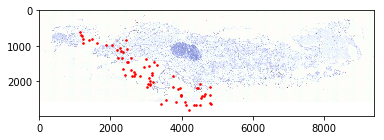

In [39]:
image111 = source_image_array[107]
plt.figure()
source_image_1 = image111
source_image_landmark = 'result/testOutput.csv'
current = pd.read_csv(source_image_landmark)
X = current['X']
Y = current['Y']

show_landmarks(io.imread(source_image_1),X,Y)
plt.show()

In [21]:
model = torch.load('own_model/the_first_time.pt')
x_1,x_2,y_1,y_2 = reg_net(image_tensor,target_image_tensor)
print(x_1)

In [33]:
for epoch in range(1000):
    for i, data in enumerate(loader, 0):
        inputs = data
        # source_image = plt.imread(inputs[0])
        
        optimizer.zero_grad()
        source_image = Image.open(inputs[0]).convert('RGB')
        # image = transform_1(source_image).unsqueeze(0)
        # width, height = source_image.size
        source_image1 = transform_1(source_image)
        # image_tensor = source_image1.to(device, torch.float)
        # source_image1 = torch.from_numpy(source_image).float()
        # source_image1 = source_image1.type(torch.FloatTensor)
        image_tensor= source_image1.unsqueeze(0)
        
        image_tensor = Variable(image_tensor)
        
        
        
        target_image = Image.open(target_image_array[i]).convert('RGB')
        # image = transform_1(target_image).unsqueeze(0)
        target_image1 = transform_1(target_image)
        target_image_tensor= target_image1.unsqueeze(0)
        target_image_tensor = Variable(target_image_tensor)
        
        optimizer.zero_grad()
        
        
        
        x_1,x_2,y_1,y_2 = reg_net(image_tensor,target_image_tensor)
        # plt.imshow(image)
        # plt.imshow(target_image)
        source_image_landmark = source_image_landmarks[i]
        current = pd.read_csv(source_image_landmark)
        X = current['X']
        Y = current['Y']
        # X = X.transpose()
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        loss_1 = loss(x_1, X)
        loss_2 = loss(x_2, Y)
        
        ######
        target_image_landmark = target_image_landmarks[i]
        current = pd.read_csv(target_image_landmark)
        X = current['X']
        Y = current['Y']
        
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        
        loss_3 = loss(y_1, X)
        loss_4 = loss(y_2, Y)
        
        
        loss_all = loss_1+loss_2+loss_3+loss_4
        loss_all.backward()
        
        optimizer.step()
        print("The loss is ",loss_all)
        
    
print(x_1)


The loss is  tensor(1920144.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4156600.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3666352.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8760590., grad_fn=<AddBackward0>)
The loss is  tensor(4887000., grad_fn=<AddBackward0>)
The loss is  tensor(2520500.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3195927., grad_fn=<AddBackward0>)
The loss is  tensor(3578352., grad_fn=<AddBackward0>)
The loss is  tensor(4002252.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3917012., grad_fn=<AddBackward0>)
The loss is  tensor(7804146., grad_fn=<AddBackward0>)
The loss is  tensor(9722599., grad_fn=<AddBackward0>)
The loss is  tensor(9183429., grad_fn=<AddBackward0>)
The loss is  tensor(10418065., grad_fn=<AddBackward0>)
The loss is  tensor(10358576., grad_fn=<AddBackward0>)
The loss is  tensor(13258274., grad_fn=<AddBackward0>)
The loss is  tensor(11781327., grad_fn=<AddBackward0>)
The loss is  tensor(9399170., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3814091.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4603818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6801356., grad_fn=<AddBackward0>)
The loss is  tensor(10023987., grad_fn=<AddBackward0>)
The loss is  tensor(9094332., grad_fn=<AddBackward0>)
The loss is  tensor(4857721., grad_fn=<AddBackward0>)
The loss is  tensor(10513583., grad_fn=<AddBackward0>)
The loss is  tensor(3633436.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5449326., grad_fn=<AddBackward0>)
The loss is  tensor(8496270., grad_fn=<AddBackward0>)
The loss is  tensor(20164946., grad_fn=<AddBackward0>)
The loss is  tensor(7015599., grad_fn=<AddBackward0>)
The loss is  tensor(13045330., grad_fn=<AddBackward0>)
The loss is  tensor(9444894., grad_fn=<AddBackward0>)
The loss is  tensor(9238369., grad_fn=<AddBackward0>)
The loss is  tensor(5022928., grad_fn=<AddBackward0>)
The loss is  tensor(9608188., grad_fn=<AddBackward0>)
The loss is  tensor(12087244., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(4489595., grad_fn=<AddBackward0>)
The loss is  tensor(7210179., grad_fn=<AddBackward0>)
The loss is  tensor(6231234.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13672330., grad_fn=<AddBackward0>)
The loss is  tensor(9990917., grad_fn=<AddBackward0>)
The loss is  tensor(13645910., grad_fn=<AddBackward0>)
The loss is  tensor(11402316., grad_fn=<AddBackward0>)
The loss is  tensor(8770574., grad_fn=<AddBackward0>)
The loss is  tensor(11687824., grad_fn=<AddBackward0>)
The loss is  tensor(4741049., grad_fn=<AddBackward0>)
The loss is  tensor(7152596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10296762., grad_fn=<AddBackward0>)
The loss is  tensor(8727773., grad_fn=<AddBackward0>)
The loss is  tensor(10310095., grad_fn=<AddBackward0>)
The loss is  tensor(13579898., grad_fn=<AddBackward0>)
The loss is  tensor(4101102.7500, grad_fn=<AddBackward0>)
The loss is  tensor(19500606., grad_fn=<AddBackward0>)
The loss is  tensor(18263232., grad_fn=<AddBackward0>)
The los

The loss is  tensor(7936756.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9690996., grad_fn=<AddBackward0>)
The loss is  tensor(8056874., grad_fn=<AddBackward0>)
The loss is  tensor(12294122., grad_fn=<AddBackward0>)
The loss is  tensor(8519394., grad_fn=<AddBackward0>)
The loss is  tensor(9049278., grad_fn=<AddBackward0>)
The loss is  tensor(6127874., grad_fn=<AddBackward0>)
The loss is  tensor(11440024., grad_fn=<AddBackward0>)
The loss is  tensor(11264599., grad_fn=<AddBackward0>)
The loss is  tensor(10834332., grad_fn=<AddBackward0>)
The loss is  tensor(15143822., grad_fn=<AddBackward0>)
The loss is  tensor(15235057., grad_fn=<AddBackward0>)
The loss is  tensor(10652672., grad_fn=<AddBackward0>)
The loss is  tensor(12297596., grad_fn=<AddBackward0>)
The loss is  tensor(18646176., grad_fn=<AddBackward0>)
The loss is  tensor(15825343., grad_fn=<AddBackward0>)
The loss is  tensor(12011835., grad_fn=<AddBackward0>)
The loss is  tensor(10461347., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(8618991., grad_fn=<AddBackward0>)
The loss is  tensor(15246596., grad_fn=<AddBackward0>)
The loss is  tensor(4479014.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4558849.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10168155., grad_fn=<AddBackward0>)
The loss is  tensor(4971964.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2188357.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3065062.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1932624.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6379005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6832621., grad_fn=<AddBackward0>)
The loss is  tensor(4982154., grad_fn=<AddBackward0>)
The loss is  tensor(8248529., grad_fn=<AddBackward0>)
The loss is  tensor(1829587.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4863271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6079315., grad_fn=<AddBackward0>)
The loss is  tensor(7278659., grad_fn=<AddBackward0>)
The loss is  tensor(4301651.5000, grad_fn=<A

The loss is  tensor(10361962., grad_fn=<AddBackward0>)
The loss is  tensor(14502534., grad_fn=<AddBackward0>)
The loss is  tensor(8668718., grad_fn=<AddBackward0>)
The loss is  tensor(10304795., grad_fn=<AddBackward0>)
The loss is  tensor(8992957., grad_fn=<AddBackward0>)
The loss is  tensor(13076515., grad_fn=<AddBackward0>)
The loss is  tensor(4668101., grad_fn=<AddBackward0>)
The loss is  tensor(4418264., grad_fn=<AddBackward0>)
The loss is  tensor(12566820., grad_fn=<AddBackward0>)
The loss is  tensor(9455728., grad_fn=<AddBackward0>)
The loss is  tensor(9412010., grad_fn=<AddBackward0>)
The loss is  tensor(9209108., grad_fn=<AddBackward0>)
The loss is  tensor(12592489., grad_fn=<AddBackward0>)
The loss is  tensor(11432025., grad_fn=<AddBackward0>)
The loss is  tensor(2932036., grad_fn=<AddBackward0>)
The loss is  tensor(2558972.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3243363.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4130341., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(8101042., grad_fn=<AddBackward0>)
The loss is  tensor(14662282., grad_fn=<AddBackward0>)
The loss is  tensor(11462363., grad_fn=<AddBackward0>)
The loss is  tensor(15126839., grad_fn=<AddBackward0>)
The loss is  tensor(12821167., grad_fn=<AddBackward0>)
The loss is  tensor(6613032., grad_fn=<AddBackward0>)
The loss is  tensor(10962616., grad_fn=<AddBackward0>)
The loss is  tensor(16797110., grad_fn=<AddBackward0>)
The loss is  tensor(17717140., grad_fn=<AddBackward0>)
The loss is  tensor(11199639., grad_fn=<AddBackward0>)
The loss is  tensor(18070160., grad_fn=<AddBackward0>)
The loss is  tensor(11675087., grad_fn=<AddBackward0>)
The loss is  tensor(12829525., grad_fn=<AddBackward0>)
The loss is  tensor(14265512., grad_fn=<AddBackward0>)
The loss is  tensor(13254320., grad_fn=<AddBackward0>)
The loss is  tensor(9454699., grad_fn=<AddBackward0>)
The loss is  tensor(2956109.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3156322.2500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(6168430., grad_fn=<AddBackward0>)
The loss is  tensor(2901345.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3114162., grad_fn=<AddBackward0>)
The loss is  tensor(5360384., grad_fn=<AddBackward0>)
The loss is  tensor(4241635.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3660798.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2824477.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4679020., grad_fn=<AddBackward0>)
The loss is  tensor(4391975., grad_fn=<AddBackward0>)
The loss is  tensor(4527596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4148850.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2955372., grad_fn=<AddBackward0>)
The loss is  tensor(1822437.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3274112.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9430802., grad_fn=<AddBackward0>)
The loss is  tensor(4158558., grad_fn=<AddBackward0>)
The loss is  tensor(11621562., grad_fn=<AddBackward0>)
The loss is  tensor(8495972., grad_fn=<AddBackwar

The loss is  tensor(3931114.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13086256., grad_fn=<AddBackward0>)
The loss is  tensor(3121045.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4202191.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2429478.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3944110.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3854704., grad_fn=<AddBackward0>)
The loss is  tensor(5344780., grad_fn=<AddBackward0>)
The loss is  tensor(2312668., grad_fn=<AddBackward0>)
The loss is  tensor(4177885.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3166859.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4099477.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10620225., grad_fn=<AddBackward0>)
The loss is  tensor(3628387.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4562732., grad_fn=<AddBackward0>)
The loss is  tensor(17969726., grad_fn=<AddBackward0>)
The loss is  tensor(10490503., grad_fn=<AddBackward0>)
The loss is  tensor(9434405., grad_fn=<Add

The loss is  tensor(13615685., grad_fn=<AddBackward0>)
The loss is  tensor(13174727., grad_fn=<AddBackward0>)
The loss is  tensor(2469582.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3321005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8143208., grad_fn=<AddBackward0>)
The loss is  tensor(11572835., grad_fn=<AddBackward0>)
The loss is  tensor(2063217.3750, grad_fn=<AddBackward0>)
The loss is  tensor(8733964., grad_fn=<AddBackward0>)
The loss is  tensor(6822279.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4355903.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6533613.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12907214., grad_fn=<AddBackward0>)
The loss is  tensor(4731794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7704611., grad_fn=<AddBackward0>)
The loss is  tensor(11146681., grad_fn=<AddBackward0>)
The loss is  tensor(7786093., grad_fn=<AddBackward0>)
The loss is  tensor(9875505., grad_fn=<AddBackward0>)
The loss is  tensor(8809905., grad_fn=<AddBackwar

The loss is  tensor(4118554.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6455156., grad_fn=<AddBackward0>)
The loss is  tensor(9535224., grad_fn=<AddBackward0>)
The loss is  tensor(14150520., grad_fn=<AddBackward0>)
The loss is  tensor(6364306.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9065918., grad_fn=<AddBackward0>)
The loss is  tensor(13748389., grad_fn=<AddBackward0>)
The loss is  tensor(14221137., grad_fn=<AddBackward0>)
The loss is  tensor(10241258., grad_fn=<AddBackward0>)
The loss is  tensor(14484491., grad_fn=<AddBackward0>)
The loss is  tensor(10140920., grad_fn=<AddBackward0>)
The loss is  tensor(17790446., grad_fn=<AddBackward0>)
The loss is  tensor(13244014., grad_fn=<AddBackward0>)
The loss is  tensor(17925052., grad_fn=<AddBackward0>)
The loss is  tensor(16193017., grad_fn=<AddBackward0>)
The loss is  tensor(6866358., grad_fn=<AddBackward0>)
The loss is  tensor(16120727., grad_fn=<AddBackward0>)
The loss is  tensor(11883374., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(7560812., grad_fn=<AddBackward0>)
The loss is  tensor(8186101., grad_fn=<AddBackward0>)
The loss is  tensor(11299151., grad_fn=<AddBackward0>)
The loss is  tensor(13203310., grad_fn=<AddBackward0>)
The loss is  tensor(3236389., grad_fn=<AddBackward0>)
The loss is  tensor(9080578., grad_fn=<AddBackward0>)
The loss is  tensor(11821218., grad_fn=<AddBackward0>)
The loss is  tensor(11275773., grad_fn=<AddBackward0>)
The loss is  tensor(7809884., grad_fn=<AddBackward0>)
The loss is  tensor(13635238., grad_fn=<AddBackward0>)
The loss is  tensor(11060807., grad_fn=<AddBackward0>)
The loss is  tensor(11253618., grad_fn=<AddBackward0>)
The loss is  tensor(10468824., grad_fn=<AddBackward0>)
The loss is  tensor(12832553., grad_fn=<AddBackward0>)
The loss is  tensor(14909553., grad_fn=<AddBackward0>)
The loss is  tensor(7208776., grad_fn=<AddBackward0>)
The loss is  tensor(13257719., grad_fn=<AddBackward0>)
The loss is  tensor(13584523., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(5392200., grad_fn=<AddBackward0>)
The loss is  tensor(13497818., grad_fn=<AddBackward0>)
The loss is  tensor(5315058.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7824332., grad_fn=<AddBackward0>)
The loss is  tensor(13435298., grad_fn=<AddBackward0>)
The loss is  tensor(6013625., grad_fn=<AddBackward0>)
The loss is  tensor(8797969., grad_fn=<AddBackward0>)
The loss is  tensor(7699933., grad_fn=<AddBackward0>)
The loss is  tensor(4764470.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9243308., grad_fn=<AddBackward0>)
The loss is  tensor(6550285., grad_fn=<AddBackward0>)
The loss is  tensor(6558001.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6550363., grad_fn=<AddBackward0>)
The loss is  tensor(6307750., grad_fn=<AddBackward0>)
The loss is  tensor(1319257., grad_fn=<AddBackward0>)
The loss is  tensor(1576929.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4281571., grad_fn=<AddBackward0>)
The loss is  tensor(5669929.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(11843115., grad_fn=<AddBackward0>)
The loss is  tensor(6928959.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13238604., grad_fn=<AddBackward0>)
The loss is  tensor(8099810.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11108670., grad_fn=<AddBackward0>)
The loss is  tensor(11954740., grad_fn=<AddBackward0>)
The loss is  tensor(4487824.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19115152., grad_fn=<AddBackward0>)
The loss is  tensor(15953664., grad_fn=<AddBackward0>)
The loss is  tensor(9938553., grad_fn=<AddBackward0>)
The loss is  tensor(8451335., grad_fn=<AddBackward0>)
The loss is  tensor(9942152., grad_fn=<AddBackward0>)
The loss is  tensor(11244110., grad_fn=<AddBackward0>)
The loss is  tensor(13068108., grad_fn=<AddBackward0>)
The loss is  tensor(17753182., grad_fn=<AddBackward0>)
The loss is  tensor(11977248., grad_fn=<AddBackward0>)
The loss is  tensor(12916502., grad_fn=<AddBackward0>)
The loss is  tensor(19194602., grad_fn=<AddBackward0>)
The 

The loss is  tensor(8117653.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11880698., grad_fn=<AddBackward0>)
The loss is  tensor(12683086., grad_fn=<AddBackward0>)
The loss is  tensor(11071739., grad_fn=<AddBackward0>)
The loss is  tensor(14635668., grad_fn=<AddBackward0>)
The loss is  tensor(14897179., grad_fn=<AddBackward0>)
The loss is  tensor(20987120., grad_fn=<AddBackward0>)
The loss is  tensor(14566210., grad_fn=<AddBackward0>)
The loss is  tensor(11399276., grad_fn=<AddBackward0>)
The loss is  tensor(1899842.6250, grad_fn=<AddBackward0>)
The loss is  tensor(15728543., grad_fn=<AddBackward0>)
The loss is  tensor(7241083., grad_fn=<AddBackward0>)
The loss is  tensor(7935726.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24109480., grad_fn=<AddBackward0>)
The loss is  tensor(14243804., grad_fn=<AddBackward0>)
The loss is  tensor(15975107., grad_fn=<AddBackward0>)
The loss is  tensor(16660344., grad_fn=<AddBackward0>)
The loss is  tensor(9034279., grad_fn=<AddBackward0>)
The

The loss is  tensor(6647972., grad_fn=<AddBackward0>)
The loss is  tensor(3419565., grad_fn=<AddBackward0>)
The loss is  tensor(7426164., grad_fn=<AddBackward0>)
The loss is  tensor(4564456., grad_fn=<AddBackward0>)
The loss is  tensor(4455546.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3102396.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8345203., grad_fn=<AddBackward0>)
The loss is  tensor(5150568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4092754.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6731966.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5805187.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4821998., grad_fn=<AddBackward0>)
The loss is  tensor(3631924.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3326569.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4564245., grad_fn=<AddBackward0>)
The loss is  tensor(5000143.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5362176.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6292662.5000, grad_fn=

The loss is  tensor(8787245., grad_fn=<AddBackward0>)
The loss is  tensor(5208892.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10207114., grad_fn=<AddBackward0>)
The loss is  tensor(13162585., grad_fn=<AddBackward0>)
The loss is  tensor(9598606., grad_fn=<AddBackward0>)
The loss is  tensor(11869590., grad_fn=<AddBackward0>)
The loss is  tensor(18087298., grad_fn=<AddBackward0>)
The loss is  tensor(8750273., grad_fn=<AddBackward0>)
The loss is  tensor(2209585.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1195052.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3716577.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2347295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3314075.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5146594., grad_fn=<AddBackward0>)
The loss is  tensor(6454799., grad_fn=<AddBackward0>)
The loss is  tensor(3526500.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3909727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6036606., grad_fn=<AddBack

The loss is  tensor(6277650., grad_fn=<AddBackward0>)
The loss is  tensor(12902491., grad_fn=<AddBackward0>)
The loss is  tensor(8801417., grad_fn=<AddBackward0>)
The loss is  tensor(14936553., grad_fn=<AddBackward0>)
The loss is  tensor(4127308.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3128669.7500, grad_fn=<AddBackward0>)
The loss is  tensor(14253297., grad_fn=<AddBackward0>)
The loss is  tensor(5801801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11454933., grad_fn=<AddBackward0>)
The loss is  tensor(6526718., grad_fn=<AddBackward0>)
The loss is  tensor(3155031.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9132973., grad_fn=<AddBackward0>)
The loss is  tensor(19818496., grad_fn=<AddBackward0>)
The loss is  tensor(4015562., grad_fn=<AddBackward0>)
The loss is  tensor(8526446., grad_fn=<AddBackward0>)
The loss is  tensor(3681526.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8806555., grad_fn=<AddBackward0>)
The loss is  tensor(8543054., grad_fn=<AddBackward0>)
The

The loss is  tensor(1971342.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2087237.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5669125., grad_fn=<AddBackward0>)
The loss is  tensor(2536270.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2861773., grad_fn=<AddBackward0>)
The loss is  tensor(6935896., grad_fn=<AddBackward0>)
The loss is  tensor(6522699., grad_fn=<AddBackward0>)
The loss is  tensor(5185179., grad_fn=<AddBackward0>)
The loss is  tensor(13517015., grad_fn=<AddBackward0>)
The loss is  tensor(14269107., grad_fn=<AddBackward0>)
The loss is  tensor(3825098.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8956709., grad_fn=<AddBackward0>)
The loss is  tensor(9096006., grad_fn=<AddBackward0>)
The loss is  tensor(19829360., grad_fn=<AddBackward0>)
The loss is  tensor(9568503., grad_fn=<AddBackward0>)
The loss is  tensor(3149895.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13390833., grad_fn=<AddBackward0>)
The loss is  tensor(13550677., grad_fn=<AddBackward0>)
The

The loss is  tensor(3882508.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6581026.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3536020.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4575381., grad_fn=<AddBackward0>)
The loss is  tensor(11938977., grad_fn=<AddBackward0>)
The loss is  tensor(9435572., grad_fn=<AddBackward0>)
The loss is  tensor(10064404., grad_fn=<AddBackward0>)
The loss is  tensor(7824946., grad_fn=<AddBackward0>)
The loss is  tensor(4861517.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10261530., grad_fn=<AddBackward0>)
The loss is  tensor(10663191., grad_fn=<AddBackward0>)
The loss is  tensor(7267057.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9531969., grad_fn=<AddBackward0>)
The loss is  tensor(18569498., grad_fn=<AddBackward0>)
The loss is  tensor(11560755., grad_fn=<AddBackward0>)
The loss is  tensor(11581726., grad_fn=<AddBackward0>)
The loss is  tensor(8216380., grad_fn=<AddBackward0>)
The loss is  tensor(12870390., grad_fn=<AddBackward0>)


The loss is  tensor(8277361.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20530994., grad_fn=<AddBackward0>)
The loss is  tensor(7620621., grad_fn=<AddBackward0>)
The loss is  tensor(8465904., grad_fn=<AddBackward0>)
The loss is  tensor(10065616., grad_fn=<AddBackward0>)
The loss is  tensor(8109346., grad_fn=<AddBackward0>)
The loss is  tensor(4338703.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4666361.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5844881.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9480092., grad_fn=<AddBackward0>)
The loss is  tensor(13642714., grad_fn=<AddBackward0>)
The loss is  tensor(6745624.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6179050., grad_fn=<AddBackward0>)
The loss is  tensor(4700233.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3516065.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6275174.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2422282., grad_fn=<AddBackward0>)
The loss is  tensor(12244193., grad_fn=<AddBack

The loss is  tensor(2320591., grad_fn=<AddBackward0>)
The loss is  tensor(9989928., grad_fn=<AddBackward0>)
The loss is  tensor(10452474., grad_fn=<AddBackward0>)
The loss is  tensor(8485563., grad_fn=<AddBackward0>)
The loss is  tensor(9964066., grad_fn=<AddBackward0>)
The loss is  tensor(3551136.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7291349., grad_fn=<AddBackward0>)
The loss is  tensor(11803477., grad_fn=<AddBackward0>)
The loss is  tensor(7828407., grad_fn=<AddBackward0>)
The loss is  tensor(8347640., grad_fn=<AddBackward0>)
The loss is  tensor(9678293., grad_fn=<AddBackward0>)
The loss is  tensor(10872639., grad_fn=<AddBackward0>)
The loss is  tensor(8022356.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12438319., grad_fn=<AddBackward0>)
The loss is  tensor(12492769., grad_fn=<AddBackward0>)
The loss is  tensor(11766625., grad_fn=<AddBackward0>)
The loss is  tensor(12363396., grad_fn=<AddBackward0>)
The loss is  tensor(4475949., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(7475794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11552072., grad_fn=<AddBackward0>)
The loss is  tensor(10488119., grad_fn=<AddBackward0>)
The loss is  tensor(9512972., grad_fn=<AddBackward0>)
The loss is  tensor(11239803., grad_fn=<AddBackward0>)
The loss is  tensor(10562059., grad_fn=<AddBackward0>)
The loss is  tensor(13609546., grad_fn=<AddBackward0>)
The loss is  tensor(14463968., grad_fn=<AddBackward0>)
The loss is  tensor(17536234., grad_fn=<AddBackward0>)
The loss is  tensor(11435107., grad_fn=<AddBackward0>)
The loss is  tensor(12768229., grad_fn=<AddBackward0>)
The loss is  tensor(14089173., grad_fn=<AddBackward0>)
The loss is  tensor(12507885., grad_fn=<AddBackward0>)
The loss is  tensor(6456928., grad_fn=<AddBackward0>)
The loss is  tensor(8949171., grad_fn=<AddBackward0>)
The loss is  tensor(14808769., grad_fn=<AddBackward0>)
The loss is  tensor(12679378., grad_fn=<AddBackward0>)
The loss is  tensor(7716116.5000, grad_fn=<AddBackward0>)
The los

The loss is  tensor(3793880.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12316727., grad_fn=<AddBackward0>)
The loss is  tensor(5591624.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2870252.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4901584.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2768842.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5935406.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3771531.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2241529.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1624769.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5861686.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6985720., grad_fn=<AddBackward0>)
The loss is  tensor(9886006., grad_fn=<AddBackward0>)
The loss is  tensor(2035058.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3114430.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1976230., grad_fn=<AddBackward0>)
The loss is  tensor(5222828.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8593325.,

The loss is  tensor(7620394., grad_fn=<AddBackward0>)
The loss is  tensor(6394766., grad_fn=<AddBackward0>)
The loss is  tensor(10557676., grad_fn=<AddBackward0>)
The loss is  tensor(13393159., grad_fn=<AddBackward0>)
The loss is  tensor(3998058.2500, grad_fn=<AddBackward0>)
The loss is  tensor(16385103., grad_fn=<AddBackward0>)
The loss is  tensor(14397085., grad_fn=<AddBackward0>)
The loss is  tensor(8398115., grad_fn=<AddBackward0>)
The loss is  tensor(4495684.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11021602., grad_fn=<AddBackward0>)
The loss is  tensor(12709706., grad_fn=<AddBackward0>)
The loss is  tensor(12027616., grad_fn=<AddBackward0>)
The loss is  tensor(1199018.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4667183., grad_fn=<AddBackward0>)
The loss is  tensor(6528655., grad_fn=<AddBackward0>)
The loss is  tensor(3287598.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3477319., grad_fn=<AddBackward0>)
The loss is  tensor(3580048.7500, grad_fn=<AddBackward0>)
T

The loss is  tensor(8866478., grad_fn=<AddBackward0>)
The loss is  tensor(10676510., grad_fn=<AddBackward0>)
The loss is  tensor(11447145., grad_fn=<AddBackward0>)
The loss is  tensor(4609332., grad_fn=<AddBackward0>)
The loss is  tensor(5871606.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10142243., grad_fn=<AddBackward0>)
The loss is  tensor(12967660., grad_fn=<AddBackward0>)
The loss is  tensor(6738898.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13186431., grad_fn=<AddBackward0>)
The loss is  tensor(11296261., grad_fn=<AddBackward0>)
The loss is  tensor(14082959., grad_fn=<AddBackward0>)
The loss is  tensor(9906529., grad_fn=<AddBackward0>)
The loss is  tensor(14133416., grad_fn=<AddBackward0>)
The loss is  tensor(7957345.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3671888.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3368056.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8456500., grad_fn=<AddBackward0>)
The loss is  tensor(2765513.5000, grad_fn=<AddBackward

The loss is  tensor(6032326.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3527807.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7208146.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3398725.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3899964., grad_fn=<AddBackward0>)
The loss is  tensor(3191751.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5143020.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4545883., grad_fn=<AddBackward0>)
The loss is  tensor(6611017.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4295328., grad_fn=<AddBackward0>)
The loss is  tensor(5328113.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6546926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5156051., grad_fn=<AddBackward0>)
The loss is  tensor(3712617.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10399869., grad_fn=<AddBackward0>)
The loss is  tensor(9149934., grad_fn=<AddBackward0>)
The loss is  tensor(17254550., grad_fn=<AddBackward0>)
The loss is  tensor(12258822., grad_fn=<

The loss is  tensor(3818918.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3981562.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1812648.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2731462.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2470645., grad_fn=<AddBackward0>)
The loss is  tensor(1177240.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1745941.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3736937., grad_fn=<AddBackward0>)
The loss is  tensor(5770918., grad_fn=<AddBackward0>)
The loss is  tensor(5295646., grad_fn=<AddBackward0>)
The loss is  tensor(10659916., grad_fn=<AddBackward0>)
The loss is  tensor(9880975., grad_fn=<AddBackward0>)
The loss is  tensor(6367699., grad_fn=<AddBackward0>)
The loss is  tensor(17624728., grad_fn=<AddBackward0>)
The loss is  tensor(8627522., grad_fn=<AddBackward0>)
The loss is  tensor(8769982., grad_fn=<AddBackward0>)
The loss is  tensor(13574639., grad_fn=<AddBackward0>)
The loss is  tensor(10338624., grad_fn=<AddBackward0>)


The loss is  tensor(2661075.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4082962.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3633417.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8220310., grad_fn=<AddBackward0>)
The loss is  tensor(8777447., grad_fn=<AddBackward0>)
The loss is  tensor(3498269.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11773843., grad_fn=<AddBackward0>)
The loss is  tensor(2095615., grad_fn=<AddBackward0>)
The loss is  tensor(3763884.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8148448.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4226319., grad_fn=<AddBackward0>)
The loss is  tensor(8354162.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4203370., grad_fn=<AddBackward0>)
The loss is  tensor(5765824.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8280505., grad_fn=<AddBackward0>)
The loss is  tensor(13819545., grad_fn=<AddBackward0>)
The loss is  tensor(5816350.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7208894., grad_fn=<AddBa

The loss is  tensor(8083514.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3856034.7500, grad_fn=<AddBackward0>)
The loss is  tensor(14223239., grad_fn=<AddBackward0>)
The loss is  tensor(9093993., grad_fn=<AddBackward0>)
The loss is  tensor(9442947., grad_fn=<AddBackward0>)
The loss is  tensor(9814430., grad_fn=<AddBackward0>)
The loss is  tensor(13333451., grad_fn=<AddBackward0>)
The loss is  tensor(13751171., grad_fn=<AddBackward0>)
The loss is  tensor(14592136., grad_fn=<AddBackward0>)
The loss is  tensor(13255352., grad_fn=<AddBackward0>)
The loss is  tensor(9393139., grad_fn=<AddBackward0>)
The loss is  tensor(8479008., grad_fn=<AddBackward0>)
The loss is  tensor(8784021., grad_fn=<AddBackward0>)
The loss is  tensor(1122213.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12879541., grad_fn=<AddBackward0>)
The loss is  tensor(12322181., grad_fn=<AddBackward0>)
The loss is  tensor(11747536., grad_fn=<AddBackward0>)
The loss is  tensor(14960878., grad_fn=<AddBackward0>)
The los

The loss is  tensor(4856908., grad_fn=<AddBackward0>)
The loss is  tensor(10160240., grad_fn=<AddBackward0>)
The loss is  tensor(6860564.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8946735., grad_fn=<AddBackward0>)
The loss is  tensor(8855777., grad_fn=<AddBackward0>)
The loss is  tensor(10603995., grad_fn=<AddBackward0>)
The loss is  tensor(8647723., grad_fn=<AddBackward0>)
The loss is  tensor(12865713., grad_fn=<AddBackward0>)
The loss is  tensor(9598904., grad_fn=<AddBackward0>)
The loss is  tensor(12828686., grad_fn=<AddBackward0>)
The loss is  tensor(10533763., grad_fn=<AddBackward0>)
The loss is  tensor(13191535., grad_fn=<AddBackward0>)
The loss is  tensor(12306004., grad_fn=<AddBackward0>)
The loss is  tensor(14378866., grad_fn=<AddBackward0>)
The loss is  tensor(14318007., grad_fn=<AddBackward0>)
The loss is  tensor(11848578., grad_fn=<AddBackward0>)
The loss is  tensor(12240319., grad_fn=<AddBackward0>)
The loss is  tensor(14947199., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(9323257., grad_fn=<AddBackward0>)
The loss is  tensor(4131385.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10426490., grad_fn=<AddBackward0>)
The loss is  tensor(9105548., grad_fn=<AddBackward0>)
The loss is  tensor(8242409., grad_fn=<AddBackward0>)
The loss is  tensor(8685633., grad_fn=<AddBackward0>)
The loss is  tensor(16219094., grad_fn=<AddBackward0>)
The loss is  tensor(8046165., grad_fn=<AddBackward0>)
The loss is  tensor(5951249., grad_fn=<AddBackward0>)
The loss is  tensor(5987936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5623783.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3220201.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9160192., grad_fn=<AddBackward0>)
The loss is  tensor(1488867.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1652751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5654137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6951727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3509233.2500, grad_fn=<AddBa

The loss is  tensor(7113369.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3087955.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4099296.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12797473., grad_fn=<AddBackward0>)
The loss is  tensor(7257094., grad_fn=<AddBackward0>)
The loss is  tensor(13413430., grad_fn=<AddBackward0>)
The loss is  tensor(7859650., grad_fn=<AddBackward0>)
The loss is  tensor(12751179., grad_fn=<AddBackward0>)
The loss is  tensor(11738432., grad_fn=<AddBackward0>)
The loss is  tensor(14714696., grad_fn=<AddBackward0>)
The loss is  tensor(20877604., grad_fn=<AddBackward0>)
The loss is  tensor(11201459., grad_fn=<AddBackward0>)
The loss is  tensor(4812578., grad_fn=<AddBackward0>)
The loss is  tensor(12110969., grad_fn=<AddBackward0>)
The loss is  tensor(11102565., grad_fn=<AddBackward0>)
The loss is  tensor(18643230., grad_fn=<AddBackward0>)
The loss is  tensor(3981903.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6070288.5000, grad_fn=<AddBackward0>

The loss is  tensor(14282288., grad_fn=<AddBackward0>)
The loss is  tensor(11377712., grad_fn=<AddBackward0>)
The loss is  tensor(14647014., grad_fn=<AddBackward0>)
The loss is  tensor(9057316., grad_fn=<AddBackward0>)
The loss is  tensor(13338682., grad_fn=<AddBackward0>)
The loss is  tensor(12237732., grad_fn=<AddBackward0>)
The loss is  tensor(6048241., grad_fn=<AddBackward0>)
The loss is  tensor(18171656., grad_fn=<AddBackward0>)
The loss is  tensor(6922556., grad_fn=<AddBackward0>)
The loss is  tensor(10657987., grad_fn=<AddBackward0>)
The loss is  tensor(12368547., grad_fn=<AddBackward0>)
The loss is  tensor(10739464., grad_fn=<AddBackward0>)
The loss is  tensor(14955861., grad_fn=<AddBackward0>)
The loss is  tensor(4390442., grad_fn=<AddBackward0>)
The loss is  tensor(11708810., grad_fn=<AddBackward0>)
The loss is  tensor(18482752., grad_fn=<AddBackward0>)
The loss is  tensor(6705454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13055852., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(4474004.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4082399.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4384395., grad_fn=<AddBackward0>)
The loss is  tensor(2544357.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2744708.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3675809.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4780189.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3870315., grad_fn=<AddBackward0>)
The loss is  tensor(8347282., grad_fn=<AddBackward0>)
The loss is  tensor(7303763.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5114531., grad_fn=<AddBackward0>)
The loss is  tensor(5602362., grad_fn=<AddBackward0>)
The loss is  tensor(3188502., grad_fn=<AddBackward0>)
The loss is  tensor(5190157., grad_fn=<AddBackward0>)
The loss is  tensor(3406272.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7004518.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13847203., grad_fn=<AddBackward0>)
The loss is  tensor(13302235., grad_fn=<AddBa

The loss is  tensor(12700695., grad_fn=<AddBackward0>)
The loss is  tensor(12689414., grad_fn=<AddBackward0>)
The loss is  tensor(13237607., grad_fn=<AddBackward0>)
The loss is  tensor(10889005., grad_fn=<AddBackward0>)
The loss is  tensor(3718519., grad_fn=<AddBackward0>)
The loss is  tensor(4655834., grad_fn=<AddBackward0>)
The loss is  tensor(5736652., grad_fn=<AddBackward0>)
The loss is  tensor(5678180.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4972119., grad_fn=<AddBackward0>)
The loss is  tensor(6410312., grad_fn=<AddBackward0>)
The loss is  tensor(2095689.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3464744., grad_fn=<AddBackward0>)
The loss is  tensor(4406571.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7318182., grad_fn=<AddBackward0>)
The loss is  tensor(11560120., grad_fn=<AddBackward0>)
The loss is  tensor(10601500., grad_fn=<AddBackward0>)
The loss is  tensor(6902087.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17196552., grad_fn=<AddBackward0>)
The l

The loss is  tensor(14303465., grad_fn=<AddBackward0>)
The loss is  tensor(6807108.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5145555.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18168430., grad_fn=<AddBackward0>)
The loss is  tensor(4580863., grad_fn=<AddBackward0>)
The loss is  tensor(8567721., grad_fn=<AddBackward0>)
The loss is  tensor(4395364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8257591., grad_fn=<AddBackward0>)
The loss is  tensor(7698525., grad_fn=<AddBackward0>)
The loss is  tensor(4098257.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4498207., grad_fn=<AddBackward0>)
The loss is  tensor(2343865., grad_fn=<AddBackward0>)
The loss is  tensor(5904126.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9564534., grad_fn=<AddBackward0>)
The loss is  tensor(5069077.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8119669., grad_fn=<AddBackward0>)
The loss is  tensor(7339708., grad_fn=<AddBackward0>)
The loss is  tensor(2684652., grad_fn=<AddBackward0>)
Th

The loss is  tensor(5103383.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7631971., grad_fn=<AddBackward0>)
The loss is  tensor(4587851., grad_fn=<AddBackward0>)
The loss is  tensor(5449140.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9900216., grad_fn=<AddBackward0>)
The loss is  tensor(3830778.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7497797., grad_fn=<AddBackward0>)
The loss is  tensor(8977495., grad_fn=<AddBackward0>)
The loss is  tensor(7990434., grad_fn=<AddBackward0>)
The loss is  tensor(12579511., grad_fn=<AddBackward0>)
The loss is  tensor(876805.0625, grad_fn=<AddBackward0>)
The loss is  tensor(3950040.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8992433., grad_fn=<AddBackward0>)
The loss is  tensor(6728543.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8478708., grad_fn=<AddBackward0>)
The loss is  tensor(15488650., grad_fn=<AddBackward0>)
The loss is  tensor(3992295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13094461., grad_fn=<AddBackward0>

The loss is  tensor(1467451., grad_fn=<AddBackward0>)
The loss is  tensor(4753169., grad_fn=<AddBackward0>)
The loss is  tensor(3581457.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4099414.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11412980., grad_fn=<AddBackward0>)
The loss is  tensor(7582982.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4871077.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8545085., grad_fn=<AddBackward0>)
The loss is  tensor(11841586., grad_fn=<AddBackward0>)
The loss is  tensor(7620108., grad_fn=<AddBackward0>)
The loss is  tensor(11146607., grad_fn=<AddBackward0>)
The loss is  tensor(5077811.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13966491., grad_fn=<AddBackward0>)
The loss is  tensor(13085065., grad_fn=<AddBackward0>)
The loss is  tensor(6923693.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10470905., grad_fn=<AddBackward0>)
The loss is  tensor(9636145., grad_fn=<AddBackward0>)
The loss is  tensor(10762662., grad_fn=<AddBackward0

The loss is  tensor(4553009.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7204239.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7457131., grad_fn=<AddBackward0>)
The loss is  tensor(9839725., grad_fn=<AddBackward0>)
The loss is  tensor(5252820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3553275., grad_fn=<AddBackward0>)
The loss is  tensor(8125170., grad_fn=<AddBackward0>)
The loss is  tensor(13509866., grad_fn=<AddBackward0>)
The loss is  tensor(10538335., grad_fn=<AddBackward0>)
The loss is  tensor(8691728., grad_fn=<AddBackward0>)
The loss is  tensor(10211306., grad_fn=<AddBackward0>)
The loss is  tensor(22477762., grad_fn=<AddBackward0>)
The loss is  tensor(4684246., grad_fn=<AddBackward0>)
The loss is  tensor(3793633.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7185877.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1305339.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10473987., grad_fn=<AddBackward0>)
The loss is  tensor(5480892.5000, grad_fn=<AddBackwar

The loss is  tensor(12471208., grad_fn=<AddBackward0>)
The loss is  tensor(9026637., grad_fn=<AddBackward0>)
The loss is  tensor(7808587., grad_fn=<AddBackward0>)
The loss is  tensor(16520742., grad_fn=<AddBackward0>)
The loss is  tensor(9096975., grad_fn=<AddBackward0>)
The loss is  tensor(8957499., grad_fn=<AddBackward0>)
The loss is  tensor(8799731., grad_fn=<AddBackward0>)
The loss is  tensor(8636285., grad_fn=<AddBackward0>)
The loss is  tensor(13707075., grad_fn=<AddBackward0>)
The loss is  tensor(10928877., grad_fn=<AddBackward0>)
The loss is  tensor(12927340., grad_fn=<AddBackward0>)
The loss is  tensor(8646100., grad_fn=<AddBackward0>)
The loss is  tensor(9385560., grad_fn=<AddBackward0>)
The loss is  tensor(8348895., grad_fn=<AddBackward0>)
The loss is  tensor(9423514., grad_fn=<AddBackward0>)
The loss is  tensor(19441008., grad_fn=<AddBackward0>)
The loss is  tensor(12361694., grad_fn=<AddBackward0>)
The loss is  tensor(5568046., grad_fn=<AddBackward0>)
The loss is  tensor(1

The loss is  tensor(9398118., grad_fn=<AddBackward0>)
The loss is  tensor(2865786.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9895736., grad_fn=<AddBackward0>)
The loss is  tensor(10635912., grad_fn=<AddBackward0>)
The loss is  tensor(10490578., grad_fn=<AddBackward0>)
The loss is  tensor(12975952., grad_fn=<AddBackward0>)
The loss is  tensor(9656199., grad_fn=<AddBackward0>)
The loss is  tensor(12406643., grad_fn=<AddBackward0>)
The loss is  tensor(16617054., grad_fn=<AddBackward0>)
The loss is  tensor(13054667., grad_fn=<AddBackward0>)
The loss is  tensor(12218301., grad_fn=<AddBackward0>)
The loss is  tensor(11418983., grad_fn=<AddBackward0>)
The loss is  tensor(12654308., grad_fn=<AddBackward0>)
The loss is  tensor(20607048., grad_fn=<AddBackward0>)
The loss is  tensor(11287700., grad_fn=<AddBackward0>)
The loss is  tensor(11535648., grad_fn=<AddBackward0>)
The loss is  tensor(12135091., grad_fn=<AddBackward0>)
The loss is  tensor(3848204.2500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(7047524.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4770185.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6520351., grad_fn=<AddBackward0>)
The loss is  tensor(4594486.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1827460.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2233340.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2187240.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6768989., grad_fn=<AddBackward0>)
The loss is  tensor(6279594., grad_fn=<AddBackward0>)
The loss is  tensor(2616994.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2595556.7500, grad_fn=<AddBackward0>)
The loss is  tensor(16045995., grad_fn=<AddBackward0>)
The loss is  tensor(8904958., grad_fn=<AddBackward0>)
The loss is  tensor(3848796., grad_fn=<AddBackward0>)
The loss is  tensor(2999882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4597988., grad_fn=<AddBackward0>)
The loss is  tensor(1848656.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3714214.5000, grad_fn

The loss is  tensor(16609534., grad_fn=<AddBackward0>)
The loss is  tensor(6672593.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12866792., grad_fn=<AddBackward0>)
The loss is  tensor(15055854., grad_fn=<AddBackward0>)
The loss is  tensor(16361379., grad_fn=<AddBackward0>)
The loss is  tensor(9780191., grad_fn=<AddBackward0>)
The loss is  tensor(14713105., grad_fn=<AddBackward0>)
The loss is  tensor(12836998., grad_fn=<AddBackward0>)
The loss is  tensor(5527494., grad_fn=<AddBackward0>)
The loss is  tensor(12565860., grad_fn=<AddBackward0>)
The loss is  tensor(12712702., grad_fn=<AddBackward0>)
The loss is  tensor(15259564., grad_fn=<AddBackward0>)
The loss is  tensor(2209202.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3868944., grad_fn=<AddBackward0>)
The loss is  tensor(3365901.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2714273.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4791609.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2440514.5000, grad_fn=<AddBackwar

The loss is  tensor(14078250., grad_fn=<AddBackward0>)
The loss is  tensor(13998928., grad_fn=<AddBackward0>)
The loss is  tensor(15769284., grad_fn=<AddBackward0>)
The loss is  tensor(10502864., grad_fn=<AddBackward0>)
The loss is  tensor(17840930., grad_fn=<AddBackward0>)
The loss is  tensor(7981618., grad_fn=<AddBackward0>)
The loss is  tensor(16955746., grad_fn=<AddBackward0>)
The loss is  tensor(18769430., grad_fn=<AddBackward0>)
The loss is  tensor(12949681., grad_fn=<AddBackward0>)
The loss is  tensor(10681594., grad_fn=<AddBackward0>)
The loss is  tensor(8181826., grad_fn=<AddBackward0>)
The loss is  tensor(14005457., grad_fn=<AddBackward0>)
The loss is  tensor(12694144., grad_fn=<AddBackward0>)
The loss is  tensor(3484318.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12328066., grad_fn=<AddBackward0>)
The loss is  tensor(10266979., grad_fn=<AddBackward0>)
The loss is  tensor(7465104., grad_fn=<AddBackward0>)
The loss is  tensor(2480337.7500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(5254787.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5990957.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3975050.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3649842.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3740381.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3147503.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8429021., grad_fn=<AddBackward0>)
The loss is  tensor(4328529., grad_fn=<AddBackward0>)
The loss is  tensor(4687501., grad_fn=<AddBackward0>)
The loss is  tensor(2508716.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4547979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5128539.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8931063., grad_fn=<AddBackward0>)
The loss is  tensor(9260727., grad_fn=<AddBackward0>)
The loss is  tensor(2542939.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10438447., grad_fn=<AddBackward0>)
The loss is  tensor(4021530.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12519543., grad_f

The loss is  tensor(2559477.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3675359., grad_fn=<AddBackward0>)
The loss is  tensor(3950246.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2712406.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3955124.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3729534.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2929027.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3468862.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3421267.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4755128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12777181., grad_fn=<AddBackward0>)
The loss is  tensor(3438670.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6556077., grad_fn=<AddBackward0>)
The loss is  tensor(9008463., grad_fn=<AddBackward0>)
The loss is  tensor(8186084.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5841868., grad_fn=<AddBackward0>)
The loss is  tensor(12104098., grad_fn=<AddBackward0>)
The loss is  tensor(9064844., grad_f

The loss is  tensor(9182039., grad_fn=<AddBackward0>)
The loss is  tensor(13200092., grad_fn=<AddBackward0>)
The loss is  tensor(5519339.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7613527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9768418., grad_fn=<AddBackward0>)
The loss is  tensor(6183518.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7146346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8056045.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11876442., grad_fn=<AddBackward0>)
The loss is  tensor(9767902., grad_fn=<AddBackward0>)
The loss is  tensor(4576803.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5846853.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9943885., grad_fn=<AddBackward0>)
The loss is  tensor(8232308., grad_fn=<AddBackward0>)
The loss is  tensor(10245621., grad_fn=<AddBackward0>)
The loss is  tensor(10096793., grad_fn=<AddBackward0>)
The loss is  tensor(7572713., grad_fn=<AddBackward0>)
The loss is  tensor(3882922.7500, grad_fn=<AddBack

The loss is  tensor(5612288.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12114737., grad_fn=<AddBackward0>)
The loss is  tensor(9952518., grad_fn=<AddBackward0>)
The loss is  tensor(8085527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17563736., grad_fn=<AddBackward0>)
The loss is  tensor(11552717., grad_fn=<AddBackward0>)
The loss is  tensor(12290784., grad_fn=<AddBackward0>)
The loss is  tensor(15376506., grad_fn=<AddBackward0>)
The loss is  tensor(10453817., grad_fn=<AddBackward0>)
The loss is  tensor(11711574., grad_fn=<AddBackward0>)
The loss is  tensor(13362249., grad_fn=<AddBackward0>)
The loss is  tensor(13998953., grad_fn=<AddBackward0>)
The loss is  tensor(4833154., grad_fn=<AddBackward0>)
The loss is  tensor(7645122.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9237940., grad_fn=<AddBackward0>)
The loss is  tensor(7886211., grad_fn=<AddBackward0>)
The loss is  tensor(15560173., grad_fn=<AddBackward0>)
The loss is  tensor(9943346., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(8815432., grad_fn=<AddBackward0>)
The loss is  tensor(10538261., grad_fn=<AddBackward0>)
The loss is  tensor(9202991., grad_fn=<AddBackward0>)
The loss is  tensor(8985654., grad_fn=<AddBackward0>)
The loss is  tensor(12529615., grad_fn=<AddBackward0>)
The loss is  tensor(9268451., grad_fn=<AddBackward0>)
The loss is  tensor(7845169., grad_fn=<AddBackward0>)
The loss is  tensor(12712198., grad_fn=<AddBackward0>)
The loss is  tensor(9331249., grad_fn=<AddBackward0>)
The loss is  tensor(9152327., grad_fn=<AddBackward0>)
The loss is  tensor(4999594., grad_fn=<AddBackward0>)
The loss is  tensor(11089453., grad_fn=<AddBackward0>)
The loss is  tensor(11247421., grad_fn=<AddBackward0>)
The loss is  tensor(9842588., grad_fn=<AddBackward0>)
The loss is  tensor(10783065., grad_fn=<AddBackward0>)
The loss is  tensor(12149681., grad_fn=<AddBackward0>)
The loss is  tensor(13469987., grad_fn=<AddBackward0>)
The loss is  tensor(9548136., grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(6847384., grad_fn=<AddBackward0>)
The loss is  tensor(4387927., grad_fn=<AddBackward0>)
The loss is  tensor(9289206., grad_fn=<AddBackward0>)
The loss is  tensor(6531705.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2827463.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6458317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13418229., grad_fn=<AddBackward0>)
The loss is  tensor(9862651., grad_fn=<AddBackward0>)
The loss is  tensor(2172218.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2831696., grad_fn=<AddBackward0>)
The loss is  tensor(6142082., grad_fn=<AddBackward0>)
The loss is  tensor(6601044., grad_fn=<AddBackward0>)
The loss is  tensor(2393224.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3289901.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4033525.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6123776., grad_fn=<AddBackward0>)
The loss is  tensor(4228700.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4916448.5000, grad_fn=<AddBac

The loss is  tensor(14350385., grad_fn=<AddBackward0>)
The loss is  tensor(7721944., grad_fn=<AddBackward0>)
The loss is  tensor(20026930., grad_fn=<AddBackward0>)
The loss is  tensor(6574918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3935817., grad_fn=<AddBackward0>)
The loss is  tensor(8722938., grad_fn=<AddBackward0>)
The loss is  tensor(13611658., grad_fn=<AddBackward0>)
The loss is  tensor(12551114., grad_fn=<AddBackward0>)
The loss is  tensor(4897366., grad_fn=<AddBackward0>)
The loss is  tensor(11068052., grad_fn=<AddBackward0>)
The loss is  tensor(12590301., grad_fn=<AddBackward0>)
The loss is  tensor(7129993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7491253., grad_fn=<AddBackward0>)
The loss is  tensor(17733776., grad_fn=<AddBackward0>)
The loss is  tensor(4791346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3301440.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3123917.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3337493.2500, grad_fn=<AddBackward0

The loss is  tensor(13955153., grad_fn=<AddBackward0>)
The loss is  tensor(10862202., grad_fn=<AddBackward0>)
The loss is  tensor(12819705., grad_fn=<AddBackward0>)
The loss is  tensor(11454985., grad_fn=<AddBackward0>)
The loss is  tensor(9516379., grad_fn=<AddBackward0>)
The loss is  tensor(15448023., grad_fn=<AddBackward0>)
The loss is  tensor(4330988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11203218., grad_fn=<AddBackward0>)
The loss is  tensor(14414009., grad_fn=<AddBackward0>)
The loss is  tensor(11666457., grad_fn=<AddBackward0>)
The loss is  tensor(21765986., grad_fn=<AddBackward0>)
The loss is  tensor(11819238., grad_fn=<AddBackward0>)
The loss is  tensor(12471626., grad_fn=<AddBackward0>)
The loss is  tensor(14896617., grad_fn=<AddBackward0>)
The loss is  tensor(8666155., grad_fn=<AddBackward0>)
The loss is  tensor(14259161., grad_fn=<AddBackward0>)
The loss is  tensor(8834742., grad_fn=<AddBackward0>)
The loss is  tensor(9679556., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(3321007.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4558102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2752445.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3056205., grad_fn=<AddBackward0>)
The loss is  tensor(3280061.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2365642., grad_fn=<AddBackward0>)
The loss is  tensor(3048950.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4124111.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8013343., grad_fn=<AddBackward0>)
The loss is  tensor(4070903., grad_fn=<AddBackward0>)
The loss is  tensor(1964363., grad_fn=<AddBackward0>)
The loss is  tensor(4759058.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4376260., grad_fn=<AddBackward0>)
The loss is  tensor(4151811., grad_fn=<AddBackward0>)
The loss is  tensor(4762124., grad_fn=<AddBackward0>)
The loss is  tensor(6620790.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7183638.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9225692., grad_fn=<AddBack

The loss is  tensor(9888617., grad_fn=<AddBackward0>)
The loss is  tensor(5306709.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14955248., grad_fn=<AddBackward0>)
The loss is  tensor(10549671., grad_fn=<AddBackward0>)
The loss is  tensor(4819546., grad_fn=<AddBackward0>)
The loss is  tensor(6334440.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9504093., grad_fn=<AddBackward0>)
The loss is  tensor(3741323.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4470165., grad_fn=<AddBackward0>)
The loss is  tensor(2734463.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2758820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2817463.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3341187.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4951004., grad_fn=<AddBackward0>)
The loss is  tensor(8971019., grad_fn=<AddBackward0>)
The loss is  tensor(8722279., grad_fn=<AddBackward0>)
The loss is  tensor(6859610.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11557963., grad_fn=<AddBackw

The loss is  tensor(11359795., grad_fn=<AddBackward0>)
The loss is  tensor(6506828., grad_fn=<AddBackward0>)
The loss is  tensor(17307018., grad_fn=<AddBackward0>)
The loss is  tensor(10933318., grad_fn=<AddBackward0>)
The loss is  tensor(7969634., grad_fn=<AddBackward0>)
The loss is  tensor(7908302.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2987814.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12816939., grad_fn=<AddBackward0>)
The loss is  tensor(4422025.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4419215.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7116136., grad_fn=<AddBackward0>)
The loss is  tensor(9888670., grad_fn=<AddBackward0>)
The loss is  tensor(8953866., grad_fn=<AddBackward0>)
The loss is  tensor(6750626., grad_fn=<AddBackward0>)
The loss is  tensor(12678590., grad_fn=<AddBackward0>)
The loss is  tensor(7157702., grad_fn=<AddBackward0>)
The loss is  tensor(7001673.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9798048., grad_fn=<AddBackward0>)
The

The loss is  tensor(7894176., grad_fn=<AddBackward0>)
The loss is  tensor(5334523., grad_fn=<AddBackward0>)
The loss is  tensor(3776947.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7282236., grad_fn=<AddBackward0>)
The loss is  tensor(8419805., grad_fn=<AddBackward0>)
The loss is  tensor(9240874., grad_fn=<AddBackward0>)
The loss is  tensor(7977861., grad_fn=<AddBackward0>)
The loss is  tensor(13563854., grad_fn=<AddBackward0>)
The loss is  tensor(7150005., grad_fn=<AddBackward0>)
The loss is  tensor(3302231.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11136923., grad_fn=<AddBackward0>)
The loss is  tensor(11008646., grad_fn=<AddBackward0>)
The loss is  tensor(9440042., grad_fn=<AddBackward0>)
The loss is  tensor(9750909., grad_fn=<AddBackward0>)
The loss is  tensor(19634126., grad_fn=<AddBackward0>)
The loss is  tensor(12993739., grad_fn=<AddBackward0>)
The loss is  tensor(6947830.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3137557.7500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(3259201.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3909511., grad_fn=<AddBackward0>)
The loss is  tensor(8794450., grad_fn=<AddBackward0>)
The loss is  tensor(7808139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7913510., grad_fn=<AddBackward0>)
The loss is  tensor(8988596., grad_fn=<AddBackward0>)
The loss is  tensor(11745560., grad_fn=<AddBackward0>)
The loss is  tensor(9069584., grad_fn=<AddBackward0>)
The loss is  tensor(17401928., grad_fn=<AddBackward0>)
The loss is  tensor(9098294., grad_fn=<AddBackward0>)
The loss is  tensor(11380995., grad_fn=<AddBackward0>)
The loss is  tensor(11354410., grad_fn=<AddBackward0>)
The loss is  tensor(13166516., grad_fn=<AddBackward0>)
The loss is  tensor(16671164., grad_fn=<AddBackward0>)
The loss is  tensor(12287585., grad_fn=<AddBackward0>)
The loss is  tensor(9846554., grad_fn=<AddBackward0>)
The loss is  tensor(10915573., grad_fn=<AddBackward0>)
The loss is  tensor(10541567., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(3848470.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5404589., grad_fn=<AddBackward0>)
The loss is  tensor(9084095., grad_fn=<AddBackward0>)
The loss is  tensor(6696324.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8901019., grad_fn=<AddBackward0>)
The loss is  tensor(4690158.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9768208., grad_fn=<AddBackward0>)
The loss is  tensor(13391084., grad_fn=<AddBackward0>)
The loss is  tensor(9389549., grad_fn=<AddBackward0>)
The loss is  tensor(5332358.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7255805., grad_fn=<AddBackward0>)
The loss is  tensor(10416326., grad_fn=<AddBackward0>)
The loss is  tensor(5592358.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5555792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2141381.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4886828., grad_fn=<AddBackward0>)
The loss is  tensor(1853198.8750, grad_fn=<AddBackward0>)
The loss is  tensor(4668733.5000, grad_fn=<AddBa

The loss is  tensor(10902752., grad_fn=<AddBackward0>)
The loss is  tensor(4337916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4703190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14225559., grad_fn=<AddBackward0>)
The loss is  tensor(17304336., grad_fn=<AddBackward0>)
The loss is  tensor(13518169., grad_fn=<AddBackward0>)
The loss is  tensor(1426974., grad_fn=<AddBackward0>)
The loss is  tensor(8304019., grad_fn=<AddBackward0>)
The loss is  tensor(15396244., grad_fn=<AddBackward0>)
The loss is  tensor(9965085., grad_fn=<AddBackward0>)
The loss is  tensor(10184956., grad_fn=<AddBackward0>)
The loss is  tensor(12442295., grad_fn=<AddBackward0>)
The loss is  tensor(10697556., grad_fn=<AddBackward0>)
The loss is  tensor(10816402., grad_fn=<AddBackward0>)
The loss is  tensor(13873170., grad_fn=<AddBackward0>)
The loss is  tensor(8732780., grad_fn=<AddBackward0>)
The loss is  tensor(9884673., grad_fn=<AddBackward0>)
The loss is  tensor(9425086., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(9615106., grad_fn=<AddBackward0>)
The loss is  tensor(10053074., grad_fn=<AddBackward0>)
The loss is  tensor(11656534., grad_fn=<AddBackward0>)
The loss is  tensor(11504388., grad_fn=<AddBackward0>)
The loss is  tensor(10129994., grad_fn=<AddBackward0>)
The loss is  tensor(10774421., grad_fn=<AddBackward0>)
The loss is  tensor(10904137., grad_fn=<AddBackward0>)
The loss is  tensor(12853054., grad_fn=<AddBackward0>)
The loss is  tensor(14837186., grad_fn=<AddBackward0>)
The loss is  tensor(8299325., grad_fn=<AddBackward0>)
The loss is  tensor(10958295., grad_fn=<AddBackward0>)
The loss is  tensor(15087984., grad_fn=<AddBackward0>)
The loss is  tensor(5892774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7195942.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16037244., grad_fn=<AddBackward0>)
The loss is  tensor(10796517., grad_fn=<AddBackward0>)
The loss is  tensor(12551118., grad_fn=<AddBackward0>)
The loss is  tensor(4176735., grad_fn=<AddBackward0>)
The los

The loss is  tensor(18078826., grad_fn=<AddBackward0>)
The loss is  tensor(9673106., grad_fn=<AddBackward0>)
The loss is  tensor(1977395.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5414452., grad_fn=<AddBackward0>)
The loss is  tensor(2083184.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8765224., grad_fn=<AddBackward0>)
The loss is  tensor(6108916., grad_fn=<AddBackward0>)
The loss is  tensor(8822361., grad_fn=<AddBackward0>)
The loss is  tensor(3200916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10648278., grad_fn=<AddBackward0>)
The loss is  tensor(2700795.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2782806.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4233090.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3914536.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4387997.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2290347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4069672.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2520571., grad_fn=<A

The loss is  tensor(9203425., grad_fn=<AddBackward0>)
The loss is  tensor(10052037., grad_fn=<AddBackward0>)
The loss is  tensor(18259296., grad_fn=<AddBackward0>)
The loss is  tensor(9170947., grad_fn=<AddBackward0>)
The loss is  tensor(12977500., grad_fn=<AddBackward0>)
The loss is  tensor(13555924., grad_fn=<AddBackward0>)
The loss is  tensor(17129998., grad_fn=<AddBackward0>)
The loss is  tensor(10663294., grad_fn=<AddBackward0>)
The loss is  tensor(3518893.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4166845.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6286304., grad_fn=<AddBackward0>)
The loss is  tensor(3574581.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3285466., grad_fn=<AddBackward0>)
The loss is  tensor(2805830.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3491932.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3764888., grad_fn=<AddBackward0>)
The loss is  tensor(4489310., grad_fn=<AddBackward0>)
The loss is  tensor(3764259., grad_fn=<AddBackward0>)
Th

The loss is  tensor(10630371., grad_fn=<AddBackward0>)
The loss is  tensor(11801107., grad_fn=<AddBackward0>)
The loss is  tensor(10297823., grad_fn=<AddBackward0>)
The loss is  tensor(8061334.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10718368., grad_fn=<AddBackward0>)
The loss is  tensor(7643531., grad_fn=<AddBackward0>)
The loss is  tensor(6549979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1620750.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8215291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16418094., grad_fn=<AddBackward0>)
The loss is  tensor(7364233., grad_fn=<AddBackward0>)
The loss is  tensor(8877057., grad_fn=<AddBackward0>)
The loss is  tensor(3576519.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11490428., grad_fn=<AddBackward0>)
The loss is  tensor(8312952.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4282136.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9352001., grad_fn=<AddBackward0>)
The loss is  tensor(7430816., grad_fn=<AddBackwa

The loss is  tensor(2829472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1408829.1250, grad_fn=<AddBackward0>)
The loss is  tensor(2305678., grad_fn=<AddBackward0>)
The loss is  tensor(4071391., grad_fn=<AddBackward0>)
The loss is  tensor(3833775.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4248814.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4125502., grad_fn=<AddBackward0>)
The loss is  tensor(7569836., grad_fn=<AddBackward0>)
The loss is  tensor(8513388., grad_fn=<AddBackward0>)
The loss is  tensor(10389132., grad_fn=<AddBackward0>)
The loss is  tensor(12388739., grad_fn=<AddBackward0>)
The loss is  tensor(17659684., grad_fn=<AddBackward0>)
The loss is  tensor(13104121., grad_fn=<AddBackward0>)
The loss is  tensor(8580708., grad_fn=<AddBackward0>)
The loss is  tensor(9239495., grad_fn=<AddBackward0>)
The loss is  tensor(12171243., grad_fn=<AddBackward0>)
The loss is  tensor(9563045., grad_fn=<AddBackward0>)
The loss is  tensor(15076706., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(2910563., grad_fn=<AddBackward0>)
The loss is  tensor(2806698., grad_fn=<AddBackward0>)
The loss is  tensor(4349541., grad_fn=<AddBackward0>)
The loss is  tensor(4353428.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7140243.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11213384., grad_fn=<AddBackward0>)
The loss is  tensor(9195220., grad_fn=<AddBackward0>)
The loss is  tensor(6396583., grad_fn=<AddBackward0>)
The loss is  tensor(11160466., grad_fn=<AddBackward0>)
The loss is  tensor(7402034., grad_fn=<AddBackward0>)
The loss is  tensor(10023866., grad_fn=<AddBackward0>)
The loss is  tensor(12169744., grad_fn=<AddBackward0>)
The loss is  tensor(11272626., grad_fn=<AddBackward0>)
The loss is  tensor(12031417., grad_fn=<AddBackward0>)
The loss is  tensor(11078966., grad_fn=<AddBackward0>)
The loss is  tensor(10196036., grad_fn=<AddBackward0>)
The loss is  tensor(8135834.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7872255., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(3130312.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6772189., grad_fn=<AddBackward0>)
The loss is  tensor(4278280.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7427796.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9605965., grad_fn=<AddBackward0>)
The loss is  tensor(3873156.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5061975., grad_fn=<AddBackward0>)
The loss is  tensor(8545129., grad_fn=<AddBackward0>)
The loss is  tensor(7949299.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12866682., grad_fn=<AddBackward0>)
The loss is  tensor(4975903., grad_fn=<AddBackward0>)
The loss is  tensor(3916137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11961230., grad_fn=<AddBackward0>)
The loss is  tensor(11261407., grad_fn=<AddBackward0>)
The loss is  tensor(5494519., grad_fn=<AddBackward0>)
The loss is  tensor(6602457.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2904809.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2023788.1250, grad_fn=<AddB

The loss is  tensor(4140244.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7546161.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17841838., grad_fn=<AddBackward0>)
The loss is  tensor(18260416., grad_fn=<AddBackward0>)
The loss is  tensor(4619340.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7718852.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8293648.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10463392., grad_fn=<AddBackward0>)
The loss is  tensor(17766648., grad_fn=<AddBackward0>)
The loss is  tensor(6370046., grad_fn=<AddBackward0>)
The loss is  tensor(2543902.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12096608., grad_fn=<AddBackward0>)
The loss is  tensor(16306560., grad_fn=<AddBackward0>)
The loss is  tensor(7221338., grad_fn=<AddBackward0>)
The loss is  tensor(7797289., grad_fn=<AddBackward0>)
The loss is  tensor(4382675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20364134., grad_fn=<AddBackward0>)
The loss is  tensor(13273813., grad_fn=<AddBack

The loss is  tensor(9072857., grad_fn=<AddBackward0>)
The loss is  tensor(8793990., grad_fn=<AddBackward0>)
The loss is  tensor(13170783., grad_fn=<AddBackward0>)
The loss is  tensor(14139270., grad_fn=<AddBackward0>)
The loss is  tensor(10216753., grad_fn=<AddBackward0>)
The loss is  tensor(10043747., grad_fn=<AddBackward0>)
The loss is  tensor(9398095., grad_fn=<AddBackward0>)
The loss is  tensor(11690069., grad_fn=<AddBackward0>)
The loss is  tensor(9065966., grad_fn=<AddBackward0>)
The loss is  tensor(9934552., grad_fn=<AddBackward0>)
The loss is  tensor(10418600., grad_fn=<AddBackward0>)
The loss is  tensor(13985682., grad_fn=<AddBackward0>)
The loss is  tensor(12242805., grad_fn=<AddBackward0>)
The loss is  tensor(13139706., grad_fn=<AddBackward0>)
The loss is  tensor(12388474., grad_fn=<AddBackward0>)
The loss is  tensor(10778793., grad_fn=<AddBackward0>)
The loss is  tensor(10566975., grad_fn=<AddBackward0>)
The loss is  tensor(10553932., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(5844662., grad_fn=<AddBackward0>)
The loss is  tensor(7229297., grad_fn=<AddBackward0>)
The loss is  tensor(8048250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4724231., grad_fn=<AddBackward0>)
The loss is  tensor(5084403., grad_fn=<AddBackward0>)
The loss is  tensor(6827396.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5403901., grad_fn=<AddBackward0>)
The loss is  tensor(2105760., grad_fn=<AddBackward0>)
The loss is  tensor(1270071.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4978367., grad_fn=<AddBackward0>)
The loss is  tensor(3317340.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9783689., grad_fn=<AddBackward0>)
The loss is  tensor(5953132., grad_fn=<AddBackward0>)
The loss is  tensor(9496714., grad_fn=<AddBackward0>)
The loss is  tensor(3849079.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4731163.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5103736., grad_fn=<AddBackward0>)
The loss is  tensor(1879859.6250, grad_fn=<AddBackward0>)


The loss is  tensor(4779601., grad_fn=<AddBackward0>)
The loss is  tensor(9176889., grad_fn=<AddBackward0>)
The loss is  tensor(19376484., grad_fn=<AddBackward0>)
The loss is  tensor(14270231., grad_fn=<AddBackward0>)
The loss is  tensor(11171064., grad_fn=<AddBackward0>)
The loss is  tensor(9663795., grad_fn=<AddBackward0>)
The loss is  tensor(14272224., grad_fn=<AddBackward0>)
The loss is  tensor(8849203., grad_fn=<AddBackward0>)
The loss is  tensor(10588667., grad_fn=<AddBackward0>)
The loss is  tensor(5393220., grad_fn=<AddBackward0>)
The loss is  tensor(13419562., grad_fn=<AddBackward0>)
The loss is  tensor(5416022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3008283., grad_fn=<AddBackward0>)
The loss is  tensor(6376949., grad_fn=<AddBackward0>)
The loss is  tensor(5731879., grad_fn=<AddBackward0>)
The loss is  tensor(3483011.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3563351.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3771052.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(16811212., grad_fn=<AddBackward0>)
The loss is  tensor(7155397.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7486037., grad_fn=<AddBackward0>)
The loss is  tensor(9608363., grad_fn=<AddBackward0>)
The loss is  tensor(7528644., grad_fn=<AddBackward0>)
The loss is  tensor(11369470., grad_fn=<AddBackward0>)
The loss is  tensor(10701823., grad_fn=<AddBackward0>)
The loss is  tensor(12838934., grad_fn=<AddBackward0>)
The loss is  tensor(10088389., grad_fn=<AddBackward0>)
The loss is  tensor(12512479., grad_fn=<AddBackward0>)
The loss is  tensor(13349687., grad_fn=<AddBackward0>)
The loss is  tensor(6482520.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17387306., grad_fn=<AddBackward0>)
The loss is  tensor(3713842., grad_fn=<AddBackward0>)
The loss is  tensor(2695018.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4202465.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5623156.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8074020., grad_fn=<AddBackward0>)


The loss is  tensor(3948722.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2222237., grad_fn=<AddBackward0>)
The loss is  tensor(2474862., grad_fn=<AddBackward0>)
The loss is  tensor(4181232.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1482201.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4750458., grad_fn=<AddBackward0>)
The loss is  tensor(5687679.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5811162.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5688446.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4377835., grad_fn=<AddBackward0>)
The loss is  tensor(3773250., grad_fn=<AddBackward0>)
The loss is  tensor(9194752., grad_fn=<AddBackward0>)
The loss is  tensor(8158620., grad_fn=<AddBackward0>)
The loss is  tensor(8877518., grad_fn=<AddBackward0>)
The loss is  tensor(8121454., grad_fn=<AddBackward0>)
The loss is  tensor(12726205., grad_fn=<AddBackward0>)
The loss is  tensor(12124283., grad_fn=<AddBackward0>)
The loss is  tensor(7824421., grad_fn=<AddBackward0>)
Th

The loss is  tensor(4292954.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3384452.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3501929., grad_fn=<AddBackward0>)
The loss is  tensor(2665040., grad_fn=<AddBackward0>)
The loss is  tensor(2292954.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3437182.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3020977.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3191540., grad_fn=<AddBackward0>)
The loss is  tensor(6666165., grad_fn=<AddBackward0>)
The loss is  tensor(5939391., grad_fn=<AddBackward0>)
The loss is  tensor(9364806., grad_fn=<AddBackward0>)
The loss is  tensor(5433155.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10282699., grad_fn=<AddBackward0>)
The loss is  tensor(8018262., grad_fn=<AddBackward0>)
The loss is  tensor(2920050., grad_fn=<AddBackward0>)
The loss is  tensor(9168362., grad_fn=<AddBackward0>)
The loss is  tensor(9990954., grad_fn=<AddBackward0>)
The loss is  tensor(15855818., grad_fn=<AddBackward0>)
Th

The loss is  tensor(4123994.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7312958.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5943664., grad_fn=<AddBackward0>)
The loss is  tensor(9527070., grad_fn=<AddBackward0>)
The loss is  tensor(3520625.2500, grad_fn=<AddBackward0>)
The loss is  tensor(15940051., grad_fn=<AddBackward0>)
The loss is  tensor(7823123.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6303258., grad_fn=<AddBackward0>)
The loss is  tensor(7680620.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7295827.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3041738.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7201257., grad_fn=<AddBackward0>)
The loss is  tensor(4819946., grad_fn=<AddBackward0>)
The loss is  tensor(4874529., grad_fn=<AddBackward0>)
The loss is  tensor(9763650., grad_fn=<AddBackward0>)
The loss is  tensor(11999627., grad_fn=<AddBackward0>)
The loss is  tensor(8881032., grad_fn=<AddBackward0>)
The loss is  tensor(6542708., grad_fn=<AddBackward0>

The loss is  tensor(11482945., grad_fn=<AddBackward0>)
The loss is  tensor(6685819.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8142613., grad_fn=<AddBackward0>)
The loss is  tensor(11590104., grad_fn=<AddBackward0>)
The loss is  tensor(11455398., grad_fn=<AddBackward0>)
The loss is  tensor(12608662., grad_fn=<AddBackward0>)
The loss is  tensor(13146966., grad_fn=<AddBackward0>)
The loss is  tensor(8734110., grad_fn=<AddBackward0>)
The loss is  tensor(9801426., grad_fn=<AddBackward0>)
The loss is  tensor(10673909., grad_fn=<AddBackward0>)
The loss is  tensor(8313256.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14375562., grad_fn=<AddBackward0>)
The loss is  tensor(6728876., grad_fn=<AddBackward0>)
The loss is  tensor(6917402., grad_fn=<AddBackward0>)
The loss is  tensor(11149647., grad_fn=<AddBackward0>)
The loss is  tensor(11478053., grad_fn=<AddBackward0>)
The loss is  tensor(8639637., grad_fn=<AddBackward0>)
The loss is  tensor(7629099., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(12768515., grad_fn=<AddBackward0>)
The loss is  tensor(15698102., grad_fn=<AddBackward0>)
The loss is  tensor(8591121., grad_fn=<AddBackward0>)
The loss is  tensor(14958617., grad_fn=<AddBackward0>)
The loss is  tensor(8023538., grad_fn=<AddBackward0>)
The loss is  tensor(13459388., grad_fn=<AddBackward0>)
The loss is  tensor(8179636.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11931592., grad_fn=<AddBackward0>)
The loss is  tensor(12226227., grad_fn=<AddBackward0>)
The loss is  tensor(12066804., grad_fn=<AddBackward0>)
The loss is  tensor(9285960., grad_fn=<AddBackward0>)
The loss is  tensor(10405915., grad_fn=<AddBackward0>)
The loss is  tensor(10385162., grad_fn=<AddBackward0>)
The loss is  tensor(11076837., grad_fn=<AddBackward0>)
The loss is  tensor(11108869., grad_fn=<AddBackward0>)
The loss is  tensor(12749411., grad_fn=<AddBackward0>)
The loss is  tensor(11928681., grad_fn=<AddBackward0>)
The loss is  tensor(13791575., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(12272371., grad_fn=<AddBackward0>)
The loss is  tensor(7983217., grad_fn=<AddBackward0>)
The loss is  tensor(9086875., grad_fn=<AddBackward0>)
The loss is  tensor(10443650., grad_fn=<AddBackward0>)
The loss is  tensor(8097516.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8032640., grad_fn=<AddBackward0>)
The loss is  tensor(8444120., grad_fn=<AddBackward0>)
The loss is  tensor(5063594.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17907732., grad_fn=<AddBackward0>)
The loss is  tensor(6811945., grad_fn=<AddBackward0>)
The loss is  tensor(5202991., grad_fn=<AddBackward0>)
The loss is  tensor(9125150., grad_fn=<AddBackward0>)
The loss is  tensor(2659007.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2276811.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3243270.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2137532.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5603784., grad_fn=<AddBackward0>)
The loss is  tensor(2956359.2500, grad_fn=<AddBackward0

The loss is  tensor(2662967.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1033448.5625, grad_fn=<AddBackward0>)
The loss is  tensor(14753099., grad_fn=<AddBackward0>)
The loss is  tensor(3826831.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6006237.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9197040., grad_fn=<AddBackward0>)
The loss is  tensor(11224278., grad_fn=<AddBackward0>)
The loss is  tensor(11206559., grad_fn=<AddBackward0>)
The loss is  tensor(11255152., grad_fn=<AddBackward0>)
The loss is  tensor(13245668., grad_fn=<AddBackward0>)
The loss is  tensor(9980536., grad_fn=<AddBackward0>)
The loss is  tensor(10914717., grad_fn=<AddBackward0>)
The loss is  tensor(5390368.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13402726., grad_fn=<AddBackward0>)
The loss is  tensor(13129536., grad_fn=<AddBackward0>)
The loss is  tensor(3517086.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3523617., grad_fn=<AddBackward0>)
The loss is  tensor(3747256.5000, grad_fn=<AddBack

The loss is  tensor(9473438., grad_fn=<AddBackward0>)
The loss is  tensor(9649745., grad_fn=<AddBackward0>)
The loss is  tensor(11095870., grad_fn=<AddBackward0>)
The loss is  tensor(10688625., grad_fn=<AddBackward0>)
The loss is  tensor(9597815., grad_fn=<AddBackward0>)
The loss is  tensor(7543095., grad_fn=<AddBackward0>)
The loss is  tensor(5773530., grad_fn=<AddBackward0>)
The loss is  tensor(4687080.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6225561., grad_fn=<AddBackward0>)
The loss is  tensor(7686310., grad_fn=<AddBackward0>)
The loss is  tensor(10835803., grad_fn=<AddBackward0>)
The loss is  tensor(7572727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(28638534., grad_fn=<AddBackward0>)
The loss is  tensor(5056406., grad_fn=<AddBackward0>)
The loss is  tensor(15328990., grad_fn=<AddBackward0>)
The loss is  tensor(10900665., grad_fn=<AddBackward0>)
The loss is  tensor(6886393., grad_fn=<AddBackward0>)
The loss is  tensor(5747864., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(1373990.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3800296.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5441429., grad_fn=<AddBackward0>)
The loss is  tensor(6539353.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14260643., grad_fn=<AddBackward0>)
The loss is  tensor(2032275.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4067989., grad_fn=<AddBackward0>)
The loss is  tensor(3816133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5037109.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2332745.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3835761.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3957661.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3151208.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5144530., grad_fn=<AddBackward0>)
The loss is  tensor(5307936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2836508., grad_fn=<AddBackward0>)
The loss is  tensor(4247560., grad_fn=<AddBackward0>)
The loss is  tensor(2651958.5000, gra

The loss is  tensor(8906716., grad_fn=<AddBackward0>)
The loss is  tensor(18659912., grad_fn=<AddBackward0>)
The loss is  tensor(8711032., grad_fn=<AddBackward0>)
The loss is  tensor(2892610.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5865321.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3861974.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3977472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3434142.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3914897.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3514353.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2400478., grad_fn=<AddBackward0>)
The loss is  tensor(3984549., grad_fn=<AddBackward0>)
The loss is  tensor(4418314.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8595072., grad_fn=<AddBackward0>)
The loss is  tensor(8780347., grad_fn=<AddBackward0>)
The loss is  tensor(6101101.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10208640., grad_fn=<AddBackward0>)
The loss is  tensor(10440389., grad_fn=<AddB

The loss is  tensor(16404799., grad_fn=<AddBackward0>)
The loss is  tensor(11385358., grad_fn=<AddBackward0>)
The loss is  tensor(12159789., grad_fn=<AddBackward0>)
The loss is  tensor(6893372., grad_fn=<AddBackward0>)
The loss is  tensor(3425191.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4461801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7315585., grad_fn=<AddBackward0>)
The loss is  tensor(7356394.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8415864., grad_fn=<AddBackward0>)
The loss is  tensor(7915095., grad_fn=<AddBackward0>)
The loss is  tensor(3480095., grad_fn=<AddBackward0>)
The loss is  tensor(6744092.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5838034., grad_fn=<AddBackward0>)
The loss is  tensor(2492667.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10078506., grad_fn=<AddBackward0>)
The loss is  tensor(3595630.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9457887., grad_fn=<AddBackward0>)
The loss is  tensor(8092020., grad_fn=<AddBackward0>)


The loss is  tensor(5002744., grad_fn=<AddBackward0>)
The loss is  tensor(4301983.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8928093., grad_fn=<AddBackward0>)
The loss is  tensor(7988068.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11607915., grad_fn=<AddBackward0>)
The loss is  tensor(5848180.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14398022., grad_fn=<AddBackward0>)
The loss is  tensor(12221470., grad_fn=<AddBackward0>)
The loss is  tensor(13409748., grad_fn=<AddBackward0>)
The loss is  tensor(6585800., grad_fn=<AddBackward0>)
The loss is  tensor(4560351., grad_fn=<AddBackward0>)
The loss is  tensor(10062407., grad_fn=<AddBackward0>)
The loss is  tensor(14317257., grad_fn=<AddBackward0>)
The loss is  tensor(11635480., grad_fn=<AddBackward0>)
The loss is  tensor(17709120., grad_fn=<AddBackward0>)
The loss is  tensor(10520289., grad_fn=<AddBackward0>)
The loss is  tensor(965768.1250, grad_fn=<AddBackward0>)
The loss is  tensor(11713757., grad_fn=<AddBackward0>)
The

The loss is  tensor(7288778.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8165859., grad_fn=<AddBackward0>)
The loss is  tensor(8840346., grad_fn=<AddBackward0>)
The loss is  tensor(7364381., grad_fn=<AddBackward0>)
The loss is  tensor(7401250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8924771., grad_fn=<AddBackward0>)
The loss is  tensor(10483290., grad_fn=<AddBackward0>)
The loss is  tensor(13687760., grad_fn=<AddBackward0>)
The loss is  tensor(8935392., grad_fn=<AddBackward0>)
The loss is  tensor(11766837., grad_fn=<AddBackward0>)
The loss is  tensor(13166003., grad_fn=<AddBackward0>)
The loss is  tensor(9081198., grad_fn=<AddBackward0>)
The loss is  tensor(9509084., grad_fn=<AddBackward0>)
The loss is  tensor(8372772., grad_fn=<AddBackward0>)
The loss is  tensor(11704402., grad_fn=<AddBackward0>)
The loss is  tensor(11050169., grad_fn=<AddBackward0>)
The loss is  tensor(10442609., grad_fn=<AddBackward0>)
The loss is  tensor(11251333., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(7890426., grad_fn=<AddBackward0>)
The loss is  tensor(8456571., grad_fn=<AddBackward0>)
The loss is  tensor(5310983., grad_fn=<AddBackward0>)
The loss is  tensor(2781940., grad_fn=<AddBackward0>)
The loss is  tensor(10934327., grad_fn=<AddBackward0>)
The loss is  tensor(4037293.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5297419.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11894689., grad_fn=<AddBackward0>)
The loss is  tensor(6256781., grad_fn=<AddBackward0>)
The loss is  tensor(12723554., grad_fn=<AddBackward0>)
The loss is  tensor(3337144.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6563784., grad_fn=<AddBackward0>)
The loss is  tensor(4803699.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8816210., grad_fn=<AddBackward0>)
The loss is  tensor(6268668., grad_fn=<AddBackward0>)
The loss is  tensor(5554065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6250172.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5724577.5000, grad_fn=<AddBackward0

The loss is  tensor(4551198., grad_fn=<AddBackward0>)
The loss is  tensor(8899635., grad_fn=<AddBackward0>)
The loss is  tensor(14128229., grad_fn=<AddBackward0>)
The loss is  tensor(11993723., grad_fn=<AddBackward0>)
The loss is  tensor(13166533., grad_fn=<AddBackward0>)
The loss is  tensor(8327057., grad_fn=<AddBackward0>)
The loss is  tensor(11043164., grad_fn=<AddBackward0>)
The loss is  tensor(13265494., grad_fn=<AddBackward0>)
The loss is  tensor(3764271.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13992901., grad_fn=<AddBackward0>)
The loss is  tensor(9449786., grad_fn=<AddBackward0>)
The loss is  tensor(8336071.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11769551., grad_fn=<AddBackward0>)
The loss is  tensor(5856657.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14886545., grad_fn=<AddBackward0>)
The loss is  tensor(7612265.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10006627., grad_fn=<AddBackward0>)
The loss is  tensor(10211344., grad_fn=<AddBackward0>)
Th

The loss is  tensor(10113807., grad_fn=<AddBackward0>)
The loss is  tensor(2534914.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9844087., grad_fn=<AddBackward0>)
The loss is  tensor(10434007., grad_fn=<AddBackward0>)
The loss is  tensor(9760686., grad_fn=<AddBackward0>)
The loss is  tensor(11041181., grad_fn=<AddBackward0>)
The loss is  tensor(11033928., grad_fn=<AddBackward0>)
The loss is  tensor(14393582., grad_fn=<AddBackward0>)
The loss is  tensor(13858472., grad_fn=<AddBackward0>)
The loss is  tensor(4111019.5000, grad_fn=<AddBackward0>)
The loss is  tensor(26068234., grad_fn=<AddBackward0>)
The loss is  tensor(3907770.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12326729., grad_fn=<AddBackward0>)
The loss is  tensor(6834798.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5487761., grad_fn=<AddBackward0>)
The loss is  tensor(13187418., grad_fn=<AddBackward0>)
The loss is  tensor(10527926., grad_fn=<AddBackward0>)
The loss is  tensor(7270816., grad_fn=<AddBackward0>)
Th

The loss is  tensor(3650130., grad_fn=<AddBackward0>)
The loss is  tensor(5355407., grad_fn=<AddBackward0>)
The loss is  tensor(6137069.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5140466.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3160997.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5092119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3397044.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2021417.8750, grad_fn=<AddBackward0>)
The loss is  tensor(9434460., grad_fn=<AddBackward0>)
The loss is  tensor(2083638., grad_fn=<AddBackward0>)
The loss is  tensor(4821597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5277098., grad_fn=<AddBackward0>)
The loss is  tensor(3872229., grad_fn=<AddBackward0>)
The loss is  tensor(3480229.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4104001.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2675744.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4562805., grad_fn=<AddBackward0>)
The loss is  tensor(1556852.5000, grad_fn=

The loss is  tensor(12233566., grad_fn=<AddBackward0>)
The loss is  tensor(12264866., grad_fn=<AddBackward0>)
The loss is  tensor(14902303., grad_fn=<AddBackward0>)
The loss is  tensor(13760155., grad_fn=<AddBackward0>)
The loss is  tensor(8880363., grad_fn=<AddBackward0>)
The loss is  tensor(9294564., grad_fn=<AddBackward0>)
The loss is  tensor(4664151., grad_fn=<AddBackward0>)
The loss is  tensor(11804878., grad_fn=<AddBackward0>)
The loss is  tensor(13149339., grad_fn=<AddBackward0>)
The loss is  tensor(6581140.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3586988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3814469.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3718689., grad_fn=<AddBackward0>)
The loss is  tensor(2565296.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3447670.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3831845.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3953711.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4485591.5000, grad_fn=<AddBa

The loss is  tensor(6679015.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6353244., grad_fn=<AddBackward0>)
The loss is  tensor(15207832., grad_fn=<AddBackward0>)
The loss is  tensor(4869998.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9726649., grad_fn=<AddBackward0>)
The loss is  tensor(13127739., grad_fn=<AddBackward0>)
The loss is  tensor(9821098., grad_fn=<AddBackward0>)
The loss is  tensor(13165271., grad_fn=<AddBackward0>)
The loss is  tensor(12652378., grad_fn=<AddBackward0>)
The loss is  tensor(4277217., grad_fn=<AddBackward0>)
The loss is  tensor(2706470.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4716231., grad_fn=<AddBackward0>)
The loss is  tensor(8111450., grad_fn=<AddBackward0>)
The loss is  tensor(5603029.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7261622.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8604218., grad_fn=<AddBackward0>)
The loss is  tensor(7989983., grad_fn=<AddBackward0>)
The loss is  tensor(12661332., grad_fn=<AddBackward0>)
The

The loss is  tensor(2875177.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3288849.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3923157., grad_fn=<AddBackward0>)
The loss is  tensor(1216757.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3806270.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4171983.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4954755., grad_fn=<AddBackward0>)
The loss is  tensor(4848885., grad_fn=<AddBackward0>)
The loss is  tensor(3142381.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3614026.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11212572., grad_fn=<AddBackward0>)
The loss is  tensor(2856398.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9955713., grad_fn=<AddBackward0>)
The loss is  tensor(8987733., grad_fn=<AddBackward0>)
The loss is  tensor(9536062., grad_fn=<AddBackward0>)
The loss is  tensor(17567428., grad_fn=<AddBackward0>)
The loss is  tensor(1245602.8750, grad_fn=<AddBackward0>)
The loss is  tensor(6759478., grad_fn=<AddBa

The loss is  tensor(2792769.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1879597.1250, grad_fn=<AddBackward0>)
The loss is  tensor(1763528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3799728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4514074., grad_fn=<AddBackward0>)
The loss is  tensor(4467313., grad_fn=<AddBackward0>)
The loss is  tensor(4313427., grad_fn=<AddBackward0>)
The loss is  tensor(12966444., grad_fn=<AddBackward0>)
The loss is  tensor(7309652., grad_fn=<AddBackward0>)
The loss is  tensor(10123357., grad_fn=<AddBackward0>)
The loss is  tensor(10578972., grad_fn=<AddBackward0>)
The loss is  tensor(8691960., grad_fn=<AddBackward0>)
The loss is  tensor(9782135., grad_fn=<AddBackward0>)
The loss is  tensor(8822600., grad_fn=<AddBackward0>)
The loss is  tensor(7839323., grad_fn=<AddBackward0>)
The loss is  tensor(10516262., grad_fn=<AddBackward0>)
The loss is  tensor(13268333., grad_fn=<AddBackward0>)
The loss is  tensor(9224332., grad_fn=<AddBackward0>)
The los

The loss is  tensor(20342834., grad_fn=<AddBackward0>)
The loss is  tensor(9165352., grad_fn=<AddBackward0>)
The loss is  tensor(4085139., grad_fn=<AddBackward0>)
The loss is  tensor(3341362., grad_fn=<AddBackward0>)
The loss is  tensor(7394527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3989601.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5356960., grad_fn=<AddBackward0>)
The loss is  tensor(4973000., grad_fn=<AddBackward0>)
The loss is  tensor(9785827., grad_fn=<AddBackward0>)
The loss is  tensor(8628615., grad_fn=<AddBackward0>)
The loss is  tensor(8000435., grad_fn=<AddBackward0>)
The loss is  tensor(6063129., grad_fn=<AddBackward0>)
The loss is  tensor(10968310., grad_fn=<AddBackward0>)
The loss is  tensor(13017654., grad_fn=<AddBackward0>)
The loss is  tensor(7124874.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6711087., grad_fn=<AddBackward0>)
The loss is  tensor(4088011., grad_fn=<AddBackward0>)
The loss is  tensor(3549221.7500, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(816428.4375, grad_fn=<AddBackward0>)
The loss is  tensor(8670377., grad_fn=<AddBackward0>)
The loss is  tensor(8286217.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9109029., grad_fn=<AddBackward0>)
The loss is  tensor(14898884., grad_fn=<AddBackward0>)
The loss is  tensor(9275688., grad_fn=<AddBackward0>)
The loss is  tensor(6643034., grad_fn=<AddBackward0>)
The loss is  tensor(10325751., grad_fn=<AddBackward0>)
The loss is  tensor(11512019., grad_fn=<AddBackward0>)
The loss is  tensor(7639432.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10252861., grad_fn=<AddBackward0>)
The loss is  tensor(10258195., grad_fn=<AddBackward0>)
The loss is  tensor(8392196., grad_fn=<AddBackward0>)
The loss is  tensor(7678301.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3722504.7500, grad_fn=<AddBackward0>)
The loss is  tensor(13323855., grad_fn=<AddBackward0>)
The loss is  tensor(5295901., grad_fn=<AddBackward0>)
The loss is  tensor(11714717., grad_fn=<AddBackward0>)
Th

The loss is  tensor(13386324., grad_fn=<AddBackward0>)
The loss is  tensor(11016104., grad_fn=<AddBackward0>)
The loss is  tensor(8949473., grad_fn=<AddBackward0>)
The loss is  tensor(11302413., grad_fn=<AddBackward0>)
The loss is  tensor(10589587., grad_fn=<AddBackward0>)
The loss is  tensor(11845209., grad_fn=<AddBackward0>)
The loss is  tensor(9385217., grad_fn=<AddBackward0>)
The loss is  tensor(9078578., grad_fn=<AddBackward0>)
The loss is  tensor(9234269., grad_fn=<AddBackward0>)
The loss is  tensor(11742298., grad_fn=<AddBackward0>)
The loss is  tensor(9171250., grad_fn=<AddBackward0>)
The loss is  tensor(12076852., grad_fn=<AddBackward0>)
The loss is  tensor(11168021., grad_fn=<AddBackward0>)
The loss is  tensor(12741538., grad_fn=<AddBackward0>)
The loss is  tensor(10573417., grad_fn=<AddBackward0>)
The loss is  tensor(10503460., grad_fn=<AddBackward0>)
The loss is  tensor(13659500., grad_fn=<AddBackward0>)
The loss is  tensor(3767274.2500, grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(5539295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5556633., grad_fn=<AddBackward0>)
The loss is  tensor(3650291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6892917., grad_fn=<AddBackward0>)
The loss is  tensor(8300637., grad_fn=<AddBackward0>)
The loss is  tensor(5216804.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8845112., grad_fn=<AddBackward0>)
The loss is  tensor(4873569.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5251866., grad_fn=<AddBackward0>)
The loss is  tensor(5798276.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2721550.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7353659.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2811902., grad_fn=<AddBackward0>)
The loss is  tensor(3092413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4145929., grad_fn=<AddBackward0>)
The loss is  tensor(8722339., grad_fn=<AddBackward0>)
The loss is  tensor(1247419.8750, grad_fn=<AddBackward0>)
The loss is  tensor(8998647., grad_fn=<AddBack

The loss is  tensor(5978663.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11161113., grad_fn=<AddBackward0>)
The loss is  tensor(6646528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11435624., grad_fn=<AddBackward0>)
The loss is  tensor(13198567., grad_fn=<AddBackward0>)
The loss is  tensor(4280519., grad_fn=<AddBackward0>)
The loss is  tensor(17465240., grad_fn=<AddBackward0>)
The loss is  tensor(9945295., grad_fn=<AddBackward0>)
The loss is  tensor(12638680., grad_fn=<AddBackward0>)
The loss is  tensor(9150967., grad_fn=<AddBackward0>)
The loss is  tensor(9638994., grad_fn=<AddBackward0>)
The loss is  tensor(9946233., grad_fn=<AddBackward0>)
The loss is  tensor(11015834., grad_fn=<AddBackward0>)
The loss is  tensor(3142230.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6254784.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6600168., grad_fn=<AddBackward0>)
The loss is  tensor(2949954.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2971715.2500, grad_fn=<AddBackward0>

The loss is  tensor(13123144., grad_fn=<AddBackward0>)
The loss is  tensor(12796147., grad_fn=<AddBackward0>)
The loss is  tensor(10512662., grad_fn=<AddBackward0>)
The loss is  tensor(16008378., grad_fn=<AddBackward0>)
The loss is  tensor(7870200., grad_fn=<AddBackward0>)
The loss is  tensor(9633620., grad_fn=<AddBackward0>)
The loss is  tensor(11909752., grad_fn=<AddBackward0>)
The loss is  tensor(7521960.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11093998., grad_fn=<AddBackward0>)
The loss is  tensor(5924139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6388269., grad_fn=<AddBackward0>)
The loss is  tensor(10313176., grad_fn=<AddBackward0>)
The loss is  tensor(6631358.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2499860.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10989207., grad_fn=<AddBackward0>)
The loss is  tensor(7085652., grad_fn=<AddBackward0>)
The loss is  tensor(6763709.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7792375.5000, grad_fn=<AddBackward

PermissionError: [WinError 5] 拒绝访问。

In [ ]:
9935435
50788820
1689682
10893537